<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Volkswagen/Volkswagen_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VOW3.DE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   39.26   40.82   38.70   40.51      31.14   218716
2009-01-05   41.59   42.14   40.01   41.25      31.71   209067
2009-01-06   41.75   45.72   41.68   43.29      33.28   288578
2009-01-07   43.92   43.92   39.96   40.11      30.84   361894
2009-01-08   39.76   41.38   38.02   40.61      31.22   412698
...            ...     ...     ...     ...        ...      ...
2018-12-19  146.68  148.84  146.42  146.88     142.09   986274
2018-12-20  145.00  145.64  143.10  143.90     139.21  1328154
2018-12-21  142.48  146.74  141.12  143.30     138.63  2650052
2018-12-27  143.38  143.50  136.28  137.44     132.96  1608052
2018-12-28  138.40  140.08  138.00  138.92     134.39   614699

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean    135.353954   137.014762   133.395002   135.225821   119.724931  1.213240e+06
std      45.234245    45.417521    44.947795    45.181281    42.615989  8.427740e+05
min      30.420000    31.230000    29.370000    30.060000    23.110000  0.000000e+00
25%     113.050000   115.000000   110.550000   112.700000    96.400000  7.832235e+05
50%     137.450000   138.920000   136.040000   137.450000   123.370000  1.049929e+06
75%     168.400000   170.425000   166.725000   168.400000   151.550000  1.442698e+06
max     259.500000   262.450000   249.550000   255.200000   227.360000  1.419737e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   37.21   37.24   35.43   36.17      27.81   275564   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   34.527874   34.699004   29.805312   34.686089   34.406214   34.391442      33.115      33.305   30.473296   33.61125   35.533463   32.7025   34.022500   33.61125   35.886667   34.693839               38.531336                 33.61125               28.691164               40.991379                 33.61125               26.231121               43.451421                 33.61125               23.771079               45.911464                 33.61125               21.311036   34.406214   35.426659   34.477538               39.326300                34.406214               29.486128               41.786343                34.406214               27.026085               44.246385                34.406214               24.566042               46.706428   
2009-03-16   37.23   38.10   35.79   36.54      28.09   256645   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   34.628480   34.697241   30.251393   35.466872   34.880389   34.405964      33.300      33.735   31.014632   33.65750   36.364414   33.3960   34.673333   33.65750   36.355000   34.604965               38.678842                 33.65750               28.636158               41.189513                 33.65750               26.125487               43.700184                 33.65750               23.614816               46.210855                 33.65750               21.104145   34.880389   36.326528   34.418129               39.901731                34.880389               29.859047               42.412402                34.880389               27.348376               44.923073                34.880389               24.837705               47.433744   
2009-03-17   36.28   36.45   34.64   35.50      27.29   404533

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean    137.331748   139.005147   135.361410   137.206043   121.563978  1.232620e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020   137.149943   136.840632    -6.201593   137.209500   137.053010   137.189260   137.028365   136.852151   136.460588   137.053702   137.208762   137.054483   137.105705   137.053702   137.162378   136.739291              142.759089               137.053702              131.348314              145.611783               137.053702              128.495620              148.464477               137.053702              125.642927              151.317171               137.053702              122.790233   137.053010   137.171210   136.786470              142.758397               137.053010              131.347622              145.611091               137.053010              128.494928              148.463785   
std      43.455707    43.621256    43.178022    43.393970    40.996706  8.397361e+05     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    43.344917    43.356178   143.968355    43.457886    43.365660    43.523754    43.409125    43.353092    43.779427    43.434783    43.428249    43.465111    43.397943    43.434783    43.391670    43.522842               44.242137                43.434783               42.931093               44.754794                43.434783               42.796726               45.336936                43.434783               42.741806               45.985922                43.434783               42.766638    43.365660    43.374699    43.510302               44.166384                43.365660               42.869291               44.676009                43.365660               42.738808               45.255312   
min      34.670000    35.680000    33.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.011297  0.006879  0.008474  0.006396   0.005433   275564   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000012  0.582182  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.003414  0.000584                0.007893                 0.000000                0.000258                0.015766                 0.000000                0.000496                0.023075                 0.000000                0.000733                0.029879                 0.000000                0.090261  0.000000  0.001119  0.000281                0.013363                 0.000000                0.000000                0.021002                 0.000000                0.000000                0.028098                 0.000000                0.017781                0.034708                 0.000000   
2009-03-16  0.011386  0.010672  0.010141  0.008075   0.006828   256645   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000474  0.000003  0.583071  0.003593  0.002222  0.000068    0.000859    0.001981  0.002334  0.000216  0.003795  0.003207  0.003031  0.000216  0.005556  0.000163                0.008554                 0.000216                0.000000                0.016621                 0.000216                0.000000                0.024110                 0.000216                0.000000                0.031082                 0.000216                0.089379  0.002222  0.005265  0.000000                0.015916                 0.002222                0.001758                0.023678                 0.002222                0.001521                0.030888                 0.002222                0.019038                0.037603                 0.002222   
2009-03-17  0.007161  0.003396  0.004816  0.003357  

139956

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcejrcotm
  JVM stdout: /tmp/tmpcejrcotm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcejrcotm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_zue9la
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.731449  0.680965              0.291328  0.466896  0.217991
1  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.728158  0.629696              0.338076  0.461097  0.212610
2  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.726868  0.609652              0.322203  0.457712  0.209500
3  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.724997  0.623902              0.318331  0.461580  0.213056
4  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.721674  1.648489              0.357820  0.537548  0.288958
5  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.717899  0.671648              0.318331  0.470508  0.221378
6  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.716415  0.654528              0.311072  0.471427  0.222243
7  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.713447  0.813738              0.334882  0.491911  0.241977
8              DeepLearning_1_AutoML_20190828_181721  0.665570  0.864592              0.412892  0.526963  0.277691
9  DeepLearning_grid_1_AutoML_20190828_181721_mod...  0.626145  0.737727              0.436992  0.516381  0.266649

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005039
1              CDLLADDERBOTTOM             0.603999           0.603999    0.003044
2                  CDLPIERCING             0.586276           0.586276    0.002954
3           CDLMORNINGDOJISTAR             0.580778           0.580778    0.002927
4               CDLMORNINGSTAR             0.577372           0.577372    0.002910
...                        ...                  ...                ...         ...
1033   BBANDS_lowerband_20_3_3             0.150907           0.150907    0.000760
1034  BBANDS_middleband_12_1_4             0.150311           0.150311    0.000757
1035  BBANDS_middleband_14_5_5             0.150289           0.150289    0.000757
1036   BBANDS_upperband_12_4_5             0.150205           0.150205    0.000757
1037   BBANDS_middleband_8_5_2             0.149793           0.149793    0.000755

[1038 rows x 4 columns]

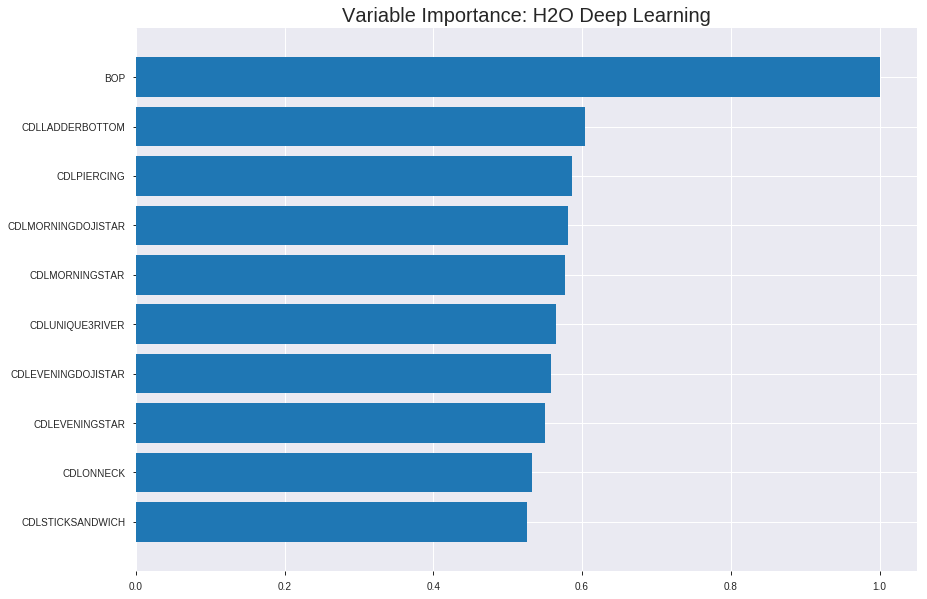

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_181721_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1893917121965183
RMSE: 0.4351915810266994
LogLoss: 0.5694492421069332
Mean Per-Class Error: 0.2822880694372776
AUC: 0.7881792561425793
pr_auc: 0.7834922065868477
Gini: 0.5763585122851587
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3480989500000926: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      415  411   0.4976   (411.0/826.0)
1      99   816   0.1082   (99.0/915.0)
Total  514  1227  0.2929   (510.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348099     0.761905  265
max f2                       0.128762     0.862768  347
max f0point5                 0.597801     0.737112  167
max accuracy                 0.459634     0.723148  225
max precision                0.999013     1         0
max recall                   0.00058093   1         399
max specificity              0.999013     1         0
max absolute_mcc             0.459634     0.447375  225
max min_per_class_accuracy   0.573864     0.715496  178
max mean_per_class_accuracy  0.459634     0.717712  225

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 54.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.994439           1.90273   1.90273            1                0.997392   1                           0.997392            0.0196721       0.0196721                  90.2732    90.2732
    2        0.0201034                   0.987837           1.67888   1.794              0.882353         0.9903     0.942857                    0.993947            0.0163934       0.0360656                  67.8881    79.4005
    3        0.0304423                   0.980789           1.90273   1.83093            1                0.984545   0.962264                    0.990754            0.0196721       0.0557377                  90.2732    83.0931
    4        0.0402068                   0.974922           1.67888   1.794              0.882353         0.978064   0.942857                    0.987672            0.0163934       0.0721311                  67.8881    79.4005
    5        0.0505457                   0.968871           1.79702   1.79462            0.944444         0.971781   0.943182                    0.984422            0.0185792       0.0907104                  79.7025    79.4622
    6        0.100517                    0.926908           1.66216   1.72877            0.873563         0.949141   0.908571                    0.966882            0.0830601       0.17377                    66.2157    72.8768
    7        0.150488                    0.889661           1.46532   1.64129            0.770115         0.909457   0.862595                    0.947813            0.073224        0.246995                   46.5323    64.1288
    8        0.20046                     0.844313           1.42158   1.58652            0.747126         0.869976   0.833811                    0.92841             0.0710383       0.318033                   42.1582    58.6519
    9        0.300402                    0.769263           1.45439   1.54256            0.764368         0.808038   0.810707                    0.888362            0.145355        0.463388                   45.4387    54.2559
    10       0.400345                    0.676878           1.22475   1.46322            0.643678         0.721855   0.76901                     0.846795            0.122404        0.585792                   22.4747    46.322
    11       0.500287                    0.583608           1.19194   1.40903            0.626437         0.629278   0.740528                    0.803342            0.119126        0.704918                   19.1941    40.9027
    12       0.60023                     0.475189           0.995107  1.34011            0.522989         0.5306     0.704306                    0.757928            0.0994536       0.804372                   -0.489291  34.0106
    13       0.700172                    0.352133           0.831078  1.26745            0.436782         0.414423   0.66612                     0.708897            0.0830601       0.887432                   -16.8922   26.7448
    14       0.800115                    0.223153           0.568633  1.18016            0.298851         0.287323   0.620244                    0.656238            0.0568306       0.944262                   -43.1367   18.0158
    15       0.900057                    0.100383           0.371798  1.0904             0.195402         0.155693   0.57307                     0.600657            0.0371585       0.981421                   -62.8202   9.03979
    16       1                           1.89273e-05        0.185899  1                  0.0977011        0.0508589  0.52556    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19355790717012328
RMSE: 0.4399521646385244
LogLoss: 0.5756589765794314
Mean Per-Class Error: 0.2857096648984345
AUC: 0.7758442230560229
pr_auc: 0.7966742729478875
Gini: 0.5516884461120457
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39587424686285955: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  117  0.4958   (117.0/236.0)
1      36   226  0.1374   (36.0/262.0)
Total  155  343  0.3072   (153.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395874     0.747107  272
max f2                       0.109494     0.86161   363
max f0point5                 0.600474     0.734295  180
max accuracy                 0.557818     0.714859  205
max precision                0.999696     1         0
max recall                   0.000368655  1         398
max specificity              0.999696     1         0
max absolute_mcc             0.557818     0.428414  205
max min_per_class_accuracy   0.560367     0.70339   202
max mean_per_class_accuracy  0.557818     0.71429   205

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 53.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.997956           1.90076   1.90076            1                0.999113   1                           0.999113            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.99432            1.90076   1.90076            1                0.9955     1                           0.997307            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.982434           1.90076   1.90076            1                0.99043    1                           0.995015            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.969234           1.90076   1.90076            1                0.976819   1                           0.990466            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.965187           1.90076   1.90076            1                0.968205   1                           0.986014            0.019084        0.0954198                  90.0763   90.0763
    6        0.100402                    0.905047           1.7487    1.82473            0.92             0.937179   0.96                        0.961596            0.0877863       0.183206                   74.8702   82.4733
    7        0.150602                    0.842852           1.59664   1.7487             0.84             0.871423   0.92                        0.931539            0.0801527       0.263359                   59.6641   74.8702
    8        0.200803                    0.799226           1.44458   1.67267            0.76             0.824722   0.88                        0.904834            0.0725191       0.335878                   44.458    67.2672
    9        0.301205                    0.708566           1.10244   1.4826             0.58             0.754563   0.78                        0.854744            0.110687        0.446565                   10.2443   48.2595
    10       0.399598                    0.63806            1.39648   1.46139            0.734694         0.667976   0.768844                    0.808756            0.137405        0.583969                   39.6479   46.1391
    11       0.5                         0.567075           1.10244   1.38931            0.58             0.605735   0.730924                    0.767988            0.110687        0.694656                   10.2443   38.9313
    12       0.600402                    0.495434           0.798321  1.29048            0.42             0.534147   0.67893                     0.728885            0.0801527       0.774809                   -20.1679  29.0485
    13       0.698795                    0.376691           0.892195  1.2344             0.469388         0.446162   0.649425                    0.689076            0.0877863       0.862595                   -10.7805  23.4404
    14       0.799197                    0.277544           0.684275  1.16529            0.36             0.324659   0.613065                    0.643295            0.0687023       0.931298                   -31.5725  16.5292
    15       0.899598                    0.122359           0.456183  1.08615            0.24             0.196816   0.571429                    0.593465            0.0458015       0.977099                   -54.3817  8.61505
    16       1                           8.87772e-06        0.228092  1                  0.12             0.0584381  0.526104                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:19:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:20:00  2 min 32.323 sec  419 obs/sec       0.284319  1             495        0.569195         1.60337             -0.299326      0.683442        0.644065           1.69132          0.396324                         0.551896           1.41088               -0.221689        0.688018          0.679989             1.90076            0.369478
    2019-08-28 18:20:10  2 min 42.237 sec  492 obs/sec       2.85353   10            4968       0.548078         2.21783             -0.204704      0.723577        0.477821           1.69132          0.356117                         0.524572           1.71132               -0.103712        0.762801          0.683123             1.90076            0.323293
    2019-08-28 18:20:21  2 min 52.868 sec  503 obs/sec       5.69328   20            9912       0.5024           1.40783             -0.0122668     0.765846        0.595813           1.79702          0.29753                          0.510098           1.42895               -0.0436442       0.748189          0.659304             1.90076            0.325301
    2019-08-28 18:20:31  3 min  3.524 sec  508 obs/sec       8.5606    30            14904      0.481727         1.13035             0.0693257      0.79278         0.629483           1.90273          0.296381                         0.511784           1.29256               -0.0505556       0.761944          0.719749             1.90076            0.317269
    2019-08-28 18:20:42  3 min 14.091 sec  512 obs/sec       11.44     40            19917      0.538437         1.44441             -0.162697      0.780335        0.748333           1.90273          0.326249                         0.49591            0.95358               0.0136035        0.763504          0.733582             1.90076            0.305221
    2019-08-28 18:20:52  3 min 24.430 sec  517 obs/sec       14.3435   50            24972      0.474246         0.867685            0.0980061      0.777875        0.71176            1.79702          0.318782                         0.483318           0.802423              0.063061         0.771097          0.751645             1.90076            0.351406
    2019-08-28 18:21:02  3 min 34.606 sec  522 obs/sec       17.22     60            29980      0.442424         0.623986            0.214994       0.795206        0.769141           1.90273          0.291212                         0.461045           0.647356              0.147424         0.763634          0.7735               1.90076            0.327309
    2019-08-28 18:21:13  3 min 45.015 sec  523 obs/sec       20.085    70            34968      0.449725         0.620571            0.188871       0.791558        0.79685            1.79702          0.293509                         0.45241            0.61595               0.179062         0.767839          0.792246             1.90076            0.329317
    2019-08-28 18:21:23

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.005039256223821651
CDLLADDERBOTTOM           0.6039986610412598     0.6039986610412598   0.003043704011832112
CDLPIERCING               0.5862762928009033     0.5862762928009033   0.0029543964573760365
CDLMORNINGDOJISTAR        0.5807780027389526     0.5807780027389526   0.002926689164960975
CDLMORNINGSTAR            0.5773716568946838     0.5773716568946838   0.0029095237154647545
---                       ---                    ---                  ---
BBANDS_lowerband_20_3_3   0.15090668201446533    0.15090668201446533  0.0007604574365576692
BBANDS_middleband_12_1_4  0.1503114104270935     0.1503114104270935   0.0007574577105061416
BBANDS_middleband_14_5_5  0.15028902888298035    0.15028902888298035  0.0007573449241706706
BBANDS_upperband_12_4_5   0.15020494163036346    0.15020494163036346  0.0007569211869595769
BBANDS_middleband_8_5_2   0.14979320764541626    0.14979320764541626  0.0007548463539133728


See the whole table with table.as_data_frame()


('accuracy', 0.7068273092369478)

('F1', 0.743859649122807)

('auc', 0.7314492192540972)

('logloss', 0.6809650349235923)

('mean_per_class_error', 0.29132791327913277)

('rmse', 0.46689552674920604)

('mse', 0.21799143289841855)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


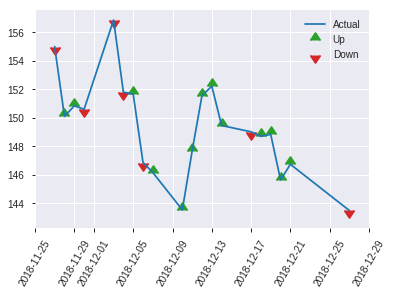


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21799143289841855
RMSE: 0.46689552674920604
LogLoss: 0.6809650349235923
Mean Per-Class Error: 0.29132791327913277
AUC: 0.7314492192540972
pr_auc: 0.6658025533220476
Gini: 0.46289843850819445
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726994488356826: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   56   0.4444   (56.0/126.0)
1      17   106  0.1382   (17.0/123.0)
Total  87   162  0.2932   (73.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472699     0.74386   161
max f2                       0.220418     0.84517   211
max f0point5                 0.489237     0.688742  157
max accuracy                 0.489237     0.706827  157
max precision                0.886002     0.8       24
max recall                   0.00313371   1         246
max specificity              0.999532     0.992063  0
max absolute_mcc             0.472699     0.437638  161
max min_per_class_accuracy   0.626294     0.674797  122
max mean_per_class_accuracy  0.472699     0.708672  161

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 56.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.98426            0.674797  0.674797           0.333333         0.991424   0.333333                    0.991424            0.00813008      0.00813008                 -32.5203  -32.5203
    2        0.0200803                   0.97998            1.0122    0.809756           0.5              0.981241   0.4                         0.987351            0.00813008      0.0162602                  1.21951   -19.0244
    3        0.0321285                   0.970613           2.02439   1.26524            1                0.977717   0.625                       0.983738            0.0243902       0.0406504                  102.439   26.5244
    4        0.0401606                   0.94524            2.02439   1.41707            1                0.963561   0.7                         0.979702            0.0162602       0.0569106                  102.439   41.7073
    5        0.0522088                   0.934384           2.02439   1.55722            1                0.940179   0.769231                    0.970582            0.0243902       0.0813008                  102.439   55.7223
    6        0.100402                    0.884963           1.68699   1.61951            0.833333         0.903405   0.8                         0.938337            0.0813008       0.162602                   68.6992   61.9512
    7        0.15261                     0.847543           1.24578   1.49166            0.615385         0.864525   0.736842                    0.913085            0.0650407       0.227642                   24.5779   49.1656
    8        0.200803                    0.821906           1.34959   1.45756            0.666667         0.834528   0.72                        0.894232            0.0650407       0.292683                   34.9593   45.7561
    9        0.301205                    0.773084           1.21463   1.37659            0.6              0.792724   0.68                        0.860396            0.121951        0.414634                   21.4634   37.6585
    10       0.401606                    0.678957           1.13366   1.31585            0.56             0.729939   0.65                        0.827782            0.113821        0.528455                   13.3659   31.5854
    11       0.502008                    0.620137           1.53854   1.36039            0.76             0.642192   0.672                       0.790664            0.154472        0.682927                   53.8537   36.039
    12       0.598394                    0.516652           1.18089   1.33148            0.583333         0.567164   0.657718                    0.754664            0.113821        0.796748                   18.0894   33.1478
    13       0.698795                    0.426198           0.890732  1.26815            0.44             0.474974   0.626437                    0.714479            0.0894309       0.886179                   -10.9268  26.8153
    14       0.799197                    0.312937           0.485854  1.16987            0.24             0.371795   0.577889                    0.671428            0.0487805       0.934959                   -51.4146  16.9874
    15       0.899598                    0.151631           0.323902  1.07546            0.16             0.227865   0.53125                     0.621923            0.0325203       0.96748                    -67.6098  7.54573
    16       1                           0.00221842         0.323902  1                  0.16             0.0855637  0.493976                  

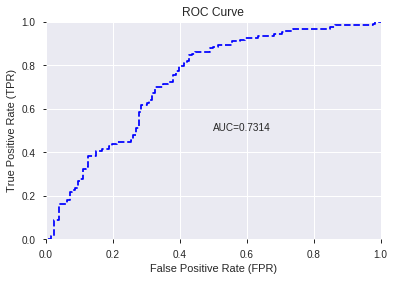

This function is available for GLM models only


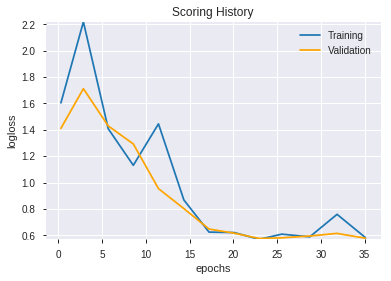

--2019-08-28 18:48:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  54.0MB/s    in 7.0s    

2019-08-28 18:48:16 (50.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_181721_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_181721_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_184910_model_4  0.739579  0.719690              0.314654  0.464358  0.215629
1  DeepLearning_grid_1_AutoML_20190828_184910_model_8  0.738224  0.613374              0.310395  0.455906  0.207850
2               DeepLearning_1_AutoML_20190828_184910  0.737127  0.636471              0.330043  0.461601  0.213075
3  DeepLearning_grid_1_AutoML_20190828_184910_model_5  0.737063  0.615750              0.326074  0.456871  0.208732
4  DeepLearning_grid_1_AutoML_20190828_184910_model_3  0.735708  0.692484              0.330139  0.458939  0.210625
5  DeepLearning_grid_1_AutoML_20190828_184910_model_9  0.734482  0.613387              0.333817  0.457243  0.209071
6  DeepLearning_grid_1_AutoML_20190828_184910_model_6  0.730417  0.608557              0.334011  0.457343  0.209163
7  DeepLearning_grid_1_AutoML_20190828_184910_model_7  0.718996  0.638962              0.357627  0.461594  0.213069
8  DeepLearning_grid_1_AutoML_20190828_184910_model_1  0.716480  0.761518              0.315234  0.472846  0.223583
9  DeepLearning_grid_1_AutoML_20190828_184910_model_2  0.712221  0.726823              0.354239  0.474520  0.225169

variable  relative_importance  scaled_importance  percentage
0    CDLEVENINGDOJISTAR             1.000000           1.000000    0.026943
1       CDLUNIQUE3RIVER             0.988034           0.988034    0.026621
2          CDLTASUKIGAP             0.965171           0.965171    0.026005
3         CDLHIKKAKEMOD             0.956346           0.956346    0.025767
4                   EXP             0.946497           0.946497    0.025502
5       CDLLADDERBOTTOM             0.938929           0.938929    0.025298
6             CDLONNECK             0.935231           0.935231    0.025198
7    CDLSEPARATINGLINES             0.929062           0.929062    0.025032
8      CDLSTICKSANDWICH             0.922451           0.922451    0.024854
9             CDLINNECK             0.922389           0.922389    0.024852
10            CDL2CROWS             0.921863           0.921863    0.024838
11          CDLPIERCING             0.919662           0.919662    0.024779
12   CDLMORNINGDOJISTAR             0.895733           0.895733    0.024134
13                 COSH             0.881900           0.881900    0.023761
14                 SINH             0.865075           0.865075    0.023308
15  CDLGAPSIDESIDEWHITE             0.843710           0.843710    0.022732
16  CDLXSIDEGAP3METHODS             0.826007           0.826007    0.022255
17    CDLINVERTEDHAMMER             0.820024           0.820024    0.022094
18       CDLEVENINGSTAR             0.811812           0.811812    0.021873
19    CDLSTALLEDPATTERN             0.795837           0.795837    0.021442
20       CDLMORNINGSTAR             0.795169           0.795169    0.021424
21         CDLTHRUSTING             0.771817           0.771817    0.020795
22     is_quarter_start             0.764282           0.764282    0.020592
23           CDL3INSIDE             0.759724           0.759724    0.020469
24      CDLADVANCEBLOCK             0.751855           0.751855    0.020257
25       is_quarter_end             0.725922           0.725922    0.019559
26     CDLDRAGONFLYDOJI             0.723624           0.723624    0.019497
27            CDLHAMMER             0.684291           0.684291    0.018437
28    CDLGRAVESTONEDOJI             0.681277           0.681277    0.018356
29            CDLTAKURI             0.677127           0.677127    0.018244
30      CDLHOMINGPIGEON             0.675083           0.675083    0.018189
31        CDLHANGINGMAN             0.665856           0.665856    0.017940
32       CDLMATCHINGLOW             0.646792           0.646792    0.017427
33    CDLDARKCLOUDCOVER             0.643764           0.643764    0.017345
34   CDLCLOSINGMARUBOZU             0.643055           0.643055    0.017326
35       is_month_start             0.620758           0.620758    0.016725
36      CDLSHOOTINGSTAR             0.614530           0.614530    0.016557
37         CDLENGULFING             0.607034           0.607034    0.016355
38                  SUB             0.588932           0.588932    0.015868
39               VAR_12             0.587203           0.587203    0.015821
40                  BOP             0.584136           0.584136    0.015738
41         is_month_end             0.574635           0.574635    0.015482
42          CDLBELTHOLD             0.559311           0.559311    0.015070
43                  DIV             0.555181           0.555181    0.014958
44            CORREL_24             0.553247           0.553247    0.014906
45          CDLLONGLINE             0.551707           0.551707    0.014865
46       STOCHRSI_fastk             0.513811           0.513811    0.013844
47         weekday_name             0.513080           0.513080    0.013824
48         STOCHF_fastk             0.504618           0.504618    0.013596
49              WILLR_8             0.491624           0.491624    0.013246

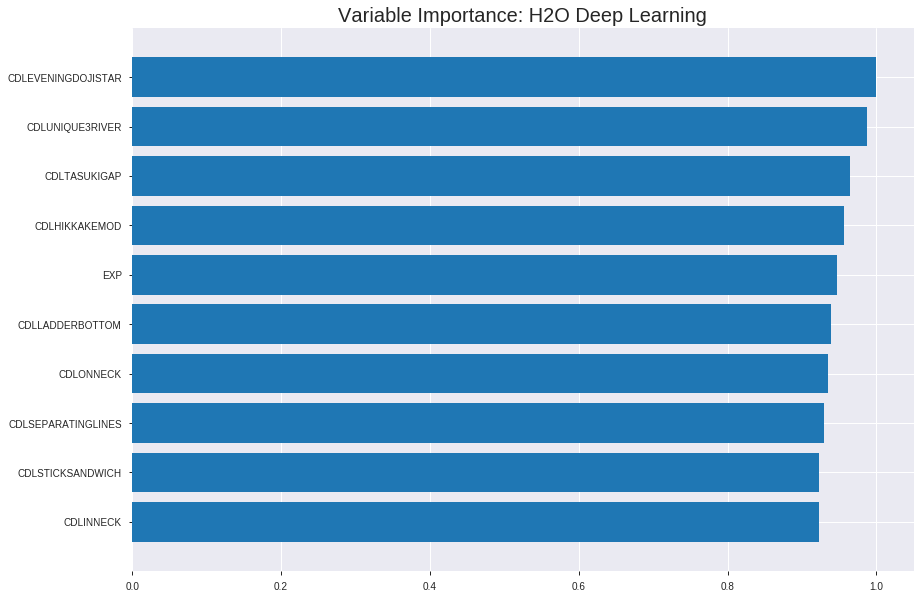

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_184910_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1819615244303543
RMSE: 0.426569483707349
LogLoss: 0.5791424946994534
Mean Per-Class Error: 0.25827544688339354
AUC: 0.8127886053004142
pr_auc: 0.8004431469738653
Gini: 0.6255772106008284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23834391952979953: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      417  409   0.4952   (409.0/826.0)
1      86   829   0.094    (86.0/915.0)
Total  503  1238  0.2843   (495.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238344     0.770088  296
max f2                       0.0878449    0.862854  347
max f0point5                 0.680769     0.765544  142
max accuracy                 0.522425     0.743251  202
max precision                0.995707     0.982456  3
max recall                   0.000237902  1         399
max specificity              0.999604     0.998789  0
max absolute_mcc             0.522425     0.484547  202
max min_per_class_accuracy   0.556026     0.733656  189
max mean_per_class_accuracy  0.522425     0.741725  202

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 51.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.998435           1.79702   1.79702            0.944444         0.999544    0.944444                    0.999544            0.0185792       0.0185792                  79.7025   79.7025
    2        0.0201034                   0.996698           1.90273   1.84837            1                0.997372    0.971429                    0.998489            0.0185792       0.0371585                  90.2732   84.8368
    3        0.0304423                   0.995508           1.90273   1.86683            1                0.996104    0.981132                    0.997679            0.0196721       0.0568306                  90.2732   86.6832
    4        0.0402068                   0.993304           1.79081   1.84837            0.941176         0.994292    0.971429                    0.996856            0.0174863       0.0743169                  79.0807   84.8368
    5        0.0505457                   0.991796           1.3742    1.75138            0.722222         0.992551    0.920455                    0.995976            0.0142077       0.0885246                  37.4196   75.1379
    6        0.100517                    0.97584            1.7059    1.72877            0.896552         0.984236    0.908571                    0.99014             0.0852459       0.17377                    70.5898   72.8768
    7        0.150488                    0.93932            1.68403   1.71391            0.885057         0.960329    0.900763                    0.980241            0.084153        0.257923                   68.4027   71.3911
    8        0.20046                     0.880555           1.5528    1.67375            0.816092         0.91091     0.879656                    0.962958            0.0775956       0.335519                   55.2804   67.375
    9        0.300402                    0.768839           1.39971   1.58258            0.735632         0.8236      0.83174                     0.916594            0.139891        0.47541                    39.9711   58.2578
    10       0.400345                    0.672499           1.42158   1.54239            0.747126         0.72079     0.810617                    0.867713            0.142077        0.617486                   42.1582   54.2387
    11       0.500287                    0.571466           1.03885   1.44179            0.545977         0.626077    0.75775                     0.819441            0.103825        0.721311                   3.88481   44.1795
    12       0.60023                     0.444912           0.984172  1.3656             0.517241         0.511855    0.717703                    0.768226            0.0983607       0.819672                   -1.58282  36.5597
    13       0.700172                    0.250658           0.743597  1.27681            0.390805         0.355652    0.671042                    0.709335            0.0743169       0.893989                   -25.6403  27.6813
    14       0.800115                    0.0872657          0.590503  1.19109            0.310345         0.166532    0.625987                    0.641534            0.0590164       0.953005                   -40.9497  19.1086
    15       0.900057                    0.0230354          0.295252  1.09161            0.155172         0.0519934   0.573708                    0.576071            0.0295082       0.982514                   -70.4748  9.16122
    16       1                           1.0662e-12         0.174964  1                  0.091954         0.00923519  0.52556   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2107690853001736
RMSE: 0.45909594345863436
LogLoss: 0.6683788502971917
Mean Per-Class Error: 0.28698732048130426
AUC: 0.7634072971923923
pr_auc: 0.7601226335450229
Gini: 0.5268145943847846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26764569480305445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  132  0.5593   (132.0/236.0)
1      29   233  0.1107   (29.0/262.0)
Total  133  365  0.3233   (161.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267646     0.743222  290
max f2                       0.0203456    0.852122  376
max f0point5                 0.65308      0.730706  175
max accuracy                 0.616299     0.712851  189
max precision                0.999938     1         0
max recall                   2.79015e-05  1         399
max specificity              0.999938     1         0
max absolute_mcc             0.616299     0.425499  189
max min_per_class_accuracy   0.614727     0.711864  191
max mean_per_class_accuracy  0.616299     0.713013  189

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.999926           1.90076   1.90076            1                0.99998    1                           0.99998             0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.998572           1.90076   1.90076            1                0.999207   1                           0.999594            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.996943           1.90076   1.90076            1                0.997604   1                           0.99893             0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.995704           1.90076   1.90076            1                0.996632   1                           0.998356            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.994179           1.90076   1.90076            1                0.994919   1                           0.997669            0.019084        0.0954198                  90.0763   90.0763
    6        0.100402                    0.973848           1.52061   1.71069            0.8              0.985355   0.9                         0.991512            0.0763359       0.171756                   52.0611   71.0687
    7        0.150602                    0.918686           1.67267   1.69802            0.88             0.950375   0.893333                    0.9778              0.0839695       0.255725                   67.2672   69.8015
    8        0.200803                    0.871366           1.52061   1.65366            0.8              0.892158   0.87                        0.956389            0.0763359       0.332061                   52.0611   65.3664
    9        0.301205                    0.792461           1.21649   1.50794            0.64             0.829405   0.793333                    0.914061            0.122137        0.454198                   21.6489   50.7939
    10       0.399598                    0.708091           1.04736   1.39453            0.55102          0.750058   0.733668                    0.873678            0.103053        0.557252                   4.73594   39.453
    11       0.5                         0.6307             1.36855   1.38931            0.72             0.673847   0.730924                    0.833552            0.137405        0.694656                   36.855    38.9313
    12       0.600402                    0.489401           0.798321  1.29048            0.42             0.567942   0.67893                     0.789135            0.0801527       0.774809                   -20.1679  29.0485
    13       0.698795                    0.357351           0.814613  1.22348            0.428571         0.431958   0.643678                    0.738843            0.0801527       0.854962                   -18.5387  22.348
    14       0.799197                    0.141361           0.64626   1.15096            0.34             0.251118   0.605528                    0.677571            0.0648855       0.919847                   -35.374   15.0965
    15       0.899598                    0.0337144          0.494198  1.07766            0.26             0.0705849  0.566964                    0.609827            0.0496183       0.969466                   -50.5802  7.76649
    16       1                           3.35793e-06        0.304122  1                  0.16             0.0136426  0.526104                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:51:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:51:25  4.795 sec         309 obs/sec       0.746123  1             1299       0.548927         1.70348             -0.208442      0.748079        0.731788           1.26849          0.323377                         0.53177            1.69496               -0.134207        0.760949          0.771269             1.90076            0.311245
    2019-08-28 18:51:32  12.387 sec        355 obs/sec       2.29581   3             3997       0.525792         1.16628             -0.108726      0.781268        0.77282            1.58561          0.304997                         0.521591           1.26491               -0.0912036       0.759178          0.776694             1.90076            0.315261
    2019-08-28 18:51:39  18.832 sec        387 obs/sec       3.82252   5             6655       0.49988          1.00616             -0.00214029    0.753906        0.772112           1.79702          0.329696                         0.500221           1.06873               -0.00361949      0.739391          0.761624             1.90076            0.341365
    2019-08-28 18:51:44  24.586 sec        417 obs/sec       5.36416   7             9339       0.497427         0.891496            0.00767093     0.795472        0.780322           1.90273          0.303274                         0.504612           0.955569              -0.0213185       0.771833          0.757456             1.52061            0.323293
    2019-08-28 18:51:51  31.304 sec        420 obs/sec       6.89604   9             12006      0.510603         1.07178             -0.0455929     0.763651        0.785253           1.90273          0.308443                         0.502912           1.07986               -0.0144473       0.754933          0.777831             1.90076            0.305221
    2019-08-28 18:51:58  38.521 sec        453 obs/sec       9.1884    12            15997      0.472494         0.750029            0.104657       0.800022        0.73597            1.90273          0.266513                         0.511745           0.898484              -0.0503961       0.752523          0.726822             1.90076            0.317269
    2019-08-28 18:52:05  45.246 sec        484 obs/sec       11.5215   15            20059      0.435641         0.60876             0.238878       0.806521        0.785694           1.69132          0.263067                         0.459672           0.690157              0.152497         0.761596          0.751558             1.90076            0.315261
    2019-08-28 18:52:11  51.330 sec        512 obs/sec       13.8306   18            24079      0.426569         0.579142            0.270247       0.812789        0.800443           1.79702          0.284319                         0.459096           0.668379              0.154619         0.763407          0.760123             1.90076            0.323293
    2019-08-28 18:52:17

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLEVENINGDOJISTAR  1.0                    1.0                  0.026943153078998142
CDLUNIQUE3RIVER     0.9880335927009583     0.9880335927009583   0.026620740335334417
CDLTASUKIGAP        0.9651713967323303     0.9651713967323303   0.026004760689629623
CDLHIKKAKEMOD       0.9563464522361755     0.9563464522361755   0.02576698885915606
EXP                 0.9464965462684631     0.9464965462684631   0.025501601334854247
---                 ---                    ---                  ---
CDLLONGLINE         0.5517070889472961     0.5517070889472961   0.014864728552275443
STOCHRSI_fastk      0.5138109922409058     0.5138109922409058   0.01384368821761865
weekday_name        0.5130804181098938     0.5130804181098938   0.01382400424697124
STOCHF_fastk        0.5046176910400391     0.5046176910400391   0.01359599169606236
WILLR_8             0.49162396788597107    0.49162396788597107  0.013245899824056185


See the whole table with table.as_data_frame()


('accuracy', 0.6867469879518072)

('F1', 0.7375415282392027)

('auc', 0.7395793005549103)

('logloss', 0.7196901438280525)

('mean_per_class_error', 0.3130081300813008)

('rmse', 0.46435823349941485)

('mse', 0.2156285690186971)

deeplearning prediction progress: |███████████████████████████████████████| 100%


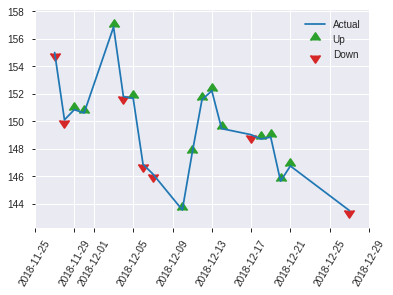


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2156285690186971
RMSE: 0.46435823349941485
LogLoss: 0.7196901438280525
Mean Per-Class Error: 0.3130081300813008
AUC: 0.7395793005549103
pr_auc: 0.6769996704559065
Gini: 0.47915860110982056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2868119650565738: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   67   0.5317   (67.0/126.0)
1      12   111  0.0976   (12.0/123.0)
Total  71   178  0.3173   (79.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286812     0.737542  177
max f2                       0.03296      0.847339  221
max f0point5                 0.563356     0.685279  116
max accuracy                 0.563356     0.686747  116
max precision                0.786455     0.804348  45
max recall                   5.91589e-05  1         248
max specificity              0.999707     0.992063  0
max absolute_mcc             0.286812     0.4105    177
max min_per_class_accuracy   0.55278      0.682927  122
max mean_per_class_accuracy  0.519497     0.686992  128

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 49.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.995374           1.34959   1.34959            0.666667         0.997278   0.666667                    0.997278            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.993715           1.0122    1.21463            0.5              0.994796   0.6                         0.996285            0.00813008      0.0243902                  1.21951   21.4634
    3        0.0321285                   0.990697           0.674797  1.0122             0.333333         0.992286   0.5                         0.994785            0.00813008      0.0325203                  -32.5203  1.21951
    4        0.0401606                   0.980173           2.02439   1.21463            1                0.986054   0.6                         0.993039            0.0162602       0.0487805                  102.439   21.4634
    5        0.0522088                   0.976006           1.34959   1.24578            0.666667         0.977836   0.615385                    0.989531            0.0162602       0.0650407                  34.9593   24.5779
    6        0.100402                    0.935055           1.85569   1.53854            0.916667         0.957212   0.76                        0.974018            0.0894309       0.154472                   85.5691   53.8537
    7        0.15261                     0.831211           1.55722   1.54493            0.769231         0.887414   0.763158                    0.94439             0.0813008       0.235772                   55.7223   54.4929
    8        0.200803                    0.776981           1.51829   1.53854            0.75             0.801235   0.76                        0.910033            0.0731707       0.308943                   51.8293   53.8537
    9        0.301205                    0.680167           1.29561   1.45756            0.64             0.727679   0.72                        0.849248            0.130081        0.439024                   29.561    45.7561
    10       0.401606                    0.633126           1.21463   1.39683            0.6              0.656227   0.69                        0.800993            0.121951        0.560976                   21.4634   39.6829
    11       0.502008                    0.536993           1.29561   1.37659            0.64             0.581583   0.68                        0.757111            0.130081        0.691057                   29.561    37.6585
    12       0.598394                    0.415815           0.674797  1.26355            0.333333         0.475459   0.624161                    0.711744            0.0650407       0.756098                   -32.5203  26.3546
    13       0.698795                    0.305928           1.21463   1.25652            0.6              0.370154   0.62069                     0.662665            0.121951        0.878049                   21.4634   25.6518
    14       0.799197                    0.132972           0.566829  1.16987            0.28             0.223276   0.577889                    0.607466            0.0569106       0.934959                   -43.3171  16.9874
    15       0.899598                    0.0283499          0.485854  1.09353            0.24             0.0597694  0.540179                    0.546339            0.0487805       0.98374                    -51.4146  9.35322
    16       1                           5.91589e-05        0.161951  1                  0.08             0.0136475  0.493976                   

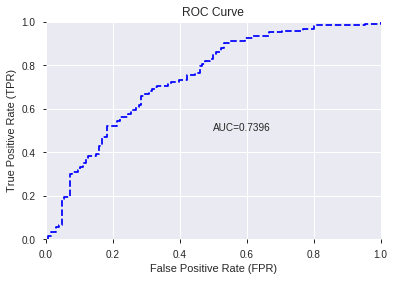

This function is available for GLM models only


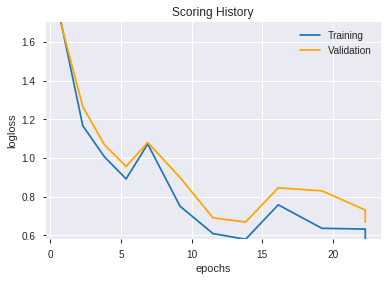

--2019-08-28 18:57:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_184910_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_184910_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'CDLHIKKAKEMOD',
 'EXP',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CDLSTICKSANDWICH',
 'CDLINNECK',
 'CDL2CROWS',
 'CDLPIERCING',
 'CDLMORNINGDOJISTAR',
 'COSH',
 'SINH',
 'CDLGAPSIDESIDEWHITE',
 'CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'is_quarter_start',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLHOMINGPIGEON',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'CDLCLOSINGMARUBOZU',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLENGULFING',
 'SUB',
 'VAR_12',
 'BOP',
 'is_month_end',
 'CDLBELTHOLD',
 'DIV',
 'CORREL_24',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'weekday_name',
 'STOCHF_fastk',
 'WILLR_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_185820_model_1  0.731965  0.612425              0.318719  0.457567  0.209368

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.776889           1.000000    0.189686
1             CDLHAMMER             0.211097           0.271720    0.051542
2                   SUB             0.203967           0.262543    0.049801
3           CDLLONGLINE             0.193029           0.248464    0.047130
4          STOCHF_fastk             0.161922           0.208423    0.039535
5                   DIV             0.154727           0.199163    0.037778
6             CDLONNECK             0.153470           0.197545    0.037471
7    CDLCLOSINGMARUBOZU             0.150686           0.193961    0.036792
8          CDLTASUKIGAP             0.132796           0.170933    0.032424
9         CDLHIKKAKEMOD             0.131704           0.169527    0.032157
10               VAR_12             0.116726           0.150248    0.028500
11        CDLHANGINGMAN             0.112108           0.144304    0.027372
12      CDLUNIQUE3RIVER             0.111844           0.143964    0.027308
13          CDLPIERCING             0.106810           0.137484    0.026079
14      CDLLADDERBOTTOM             0.096086           0.123680    0.023460
15              WILLR_8             0.095169           0.122500    0.023237
16           CDL3INSIDE             0.078206           0.100665    0.019095
17            CORREL_24             0.077719           0.100039    0.018976
18      CDLSHOOTINGSTAR             0.072706           0.093586    0.017752
19   CDLEVENINGDOJISTAR             0.072535           0.093366    0.017710
20  CDLGAPSIDESIDEWHITE             0.069972           0.090067    0.017084
21   CDLSEPARATINGLINES             0.066321           0.085367    0.016193
22            CDLINNECK             0.064994           0.083659    0.015869
23     is_quarter_start             0.064385           0.082876    0.015720
24         weekday_name             0.059460           0.076536    0.014518
25       is_quarter_end             0.057777           0.074370    0.014107
26         CDLENGULFING             0.057565           0.074096    0.014055
27       CDLMATCHINGLOW             0.056753           0.073052    0.013857
28       is_month_start             0.041501           0.053420    0.010133
29            CDL2CROWS             0.040068           0.051575    0.009783
30    CDLDARKCLOUDCOVER             0.039123           0.050359    0.009552
31    CDLSTALLEDPATTERN             0.034780           0.044768    0.008492
32       CDLMORNINGSTAR             0.033420           0.043017    0.008160
33     CDLDRAGONFLYDOJI             0.027599           0.035525    0.006739
34       CDLEVENINGSTAR             0.027034           0.034798    0.006601
35   CDLMORNINGDOJISTAR             0.026051           0.033533    0.006361
36  CDLXSIDEGAP3METHODS             0.023086           0.029715    0.005637
37       STOCHRSI_fastk             0.023071           0.029696    0.005633
38      CDLHOMINGPIGEON             0.021046           0.027091    0.005139
39          CDLBELTHOLD             0.018969           0.024416    0.004631
40         CDLTHRUSTING             0.008550           0.011006    0.002088
41      CDLADVANCEBLOCK             0.004590           0.005909    0.001121
42         is_month_end             0.003818           0.004914    0.000932
43                 COSH             0.002972           0.003826    0.000726
44                 SINH             0.002890           0.003720    0.000706
45                  EXP             0.002878           0.003704    0.000703
46            CDLTAKURI             0.002809           0.003615    0.000686
47    CDLINVERTEDHAMMER             0.001724           0.002219    0.000421
48    CDLGRAVESTONEDOJI             0.001230           0.001583    0.000300
49     CDLSTICKSANDWICH             0.001030           0.001325    0.000251

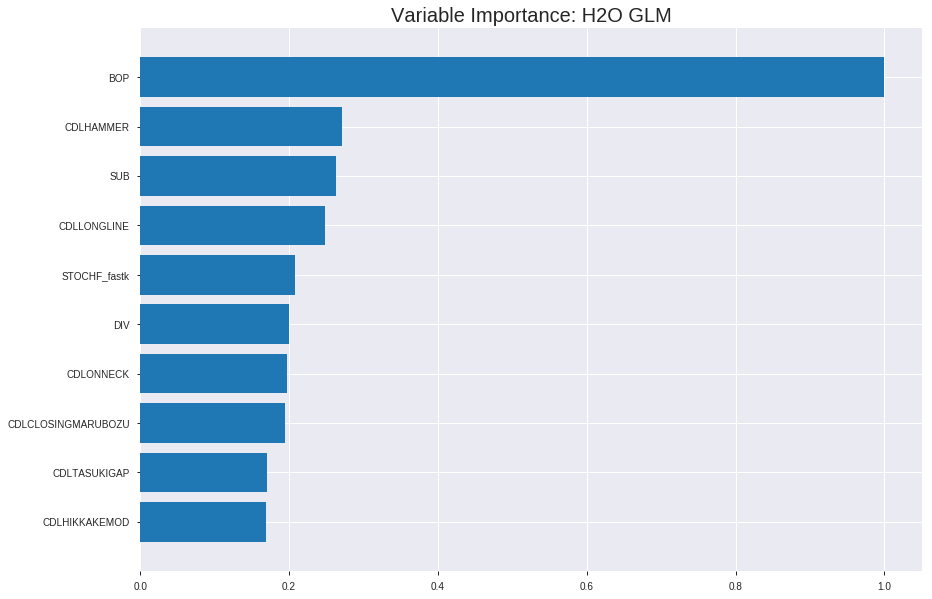

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_185820_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18086826445632123
RMSE: 0.42528609718202787
LogLoss: 0.5372961172246098
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2408.986814961971
Residual deviance: 1870.8650801760914
AIC: 1972.8650801760914
AUC: 0.802723640164596
pr_auc: 0.8132553016395921
Gini: 0.6054472803291919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33341261186041243: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      379  447   0.5412   (447.0/826.0)
1      78   837   0.0852   (78.0/915.0)
Total  457  1284  0.3016   (525.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333413     0.761255  279
max f2                       0.247663     0.864064  316
max f0point5                 0.57724      0.74659   176
max accuracy                 0.489446     0.730615  215
max precision                0.992232     1         0
max recall                   0.0720274    1         383
max specificity              0.992232     1         0
max absolute_mcc             0.477297     0.459516  220
max min_per_class_accuracy   0.545176     0.723971  191
max mean_per_class_accuracy  0.489446     0.727642  215

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.942686           1.90273   1.90273            1                0.964857  1                           0.964857            0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.924629           1.90273   1.90273            1                0.931836  1                           0.948818            0.0185792       0.0382514                  90.2732   90.2732
    3        0.0304423                   0.916129           1.90273   1.90273            1                0.919413  1                           0.938831            0.0196721       0.0579235                  90.2732   90.2732
    4        0.0402068                   0.90251            1.56696   1.82119            0.823529         0.909215  0.957143                    0.931639            0.0153005       0.073224                   56.6956   82.1187
    5        0.0505457                   0.892326           1.79702   1.81624            0.944444         0.897197  0.954545                    0.924594            0.0185792       0.0918033                  79.7025   81.6244
    6        0.100517                    0.844647           1.7059    1.76139            0.896552         0.865154  0.925714                    0.895044            0.0852459       0.177049                   70.5898   76.1386
    7        0.150488                    0.803595           1.5528    1.69212            0.816092         0.823564  0.889313                    0.871308            0.0775956       0.254645                   55.2804   69.2124
    8        0.20046                     0.769791           1.64029   1.6792             0.862069         0.787098  0.882521                    0.850316            0.0819672       0.336612                   64.0286   67.9202
    9        0.300402                    0.698953           1.41065   1.58985            0.741379         0.732383  0.835564                    0.81108             0.140984        0.477596                   41.0646   58.9855
    10       0.400345                    0.629146           1.17007   1.48506            0.614943         0.663937  0.780488                    0.774347            0.11694         0.594536                   17.0071   48.5059
    11       0.500287                    0.55309            1.18101   1.42432            0.62069          0.590828  0.748565                    0.737685            0.118033        0.712568                   18.1006   42.4319
    12       0.60023                     0.459421           0.951366  1.34557            0.5              0.507235  0.707177                    0.699314            0.095082        0.80765                    -4.86339  34.5569
    13       0.700172                    0.3636             0.787337  1.26589            0.413793         0.409253  0.665299                    0.657911            0.0786885       0.886339                   -21.2663  26.5887
    14       0.800115                    0.271416           0.623309  1.18562            0.327586         0.319985  0.623116                    0.6157              0.0622951       0.948634                   -37.6691  18.5622
    15       0.900057                    0.168903           0.317122  1.08918            0.166667         0.222501  0.572431                    0.572039            0.031694        0.980328                   -68.2878  8.91837
    16       1                           0.00591905         0.196834  1                  0.103448         0.106978  0.52556                     0.52556          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18780073306183045
RMSE: 0.433359819390112
LogLoss: 0.5530174276690482
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.0171367028406
Residual deviance: 550.8053579583719
AIC: 652.8053579583719
AUC: 0.7867528140768534
pr_auc: 0.802295203296524
Gini: 0.5735056281537068
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2970020726173405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      87   149  0.6314   (149.0/236.0)
1      14   248  0.0534   (14.0/262.0)
Total  101  397  0.3273   (163.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297002     0.752656  311
max f2                       0.199542     0.868984  354
max f0point5                 0.649014     0.736739  146
max accuracy                 0.537716     0.716867  192
max precision                0.995157     1         0
max recall                   0.0391233    1         396
max specificity              0.995157     1         0
max absolute_mcc             0.537716     0.434761  192
max min_per_class_accuracy   0.532369     0.709924  196
max mean_per_class_accuracy  0.537716     0.71767   192

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.985603           1.90076    1.90076            1                0.990414  1                           0.990414            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.947365           1.52061    1.71069            0.8              0.968639  0.9                         0.979526            0.0152672       0.0343511                  52.0611   71.0687
    3        0.0301205                   0.930599           1.90076    1.77405            1                0.939096  0.933333                    0.96605             0.019084        0.0534351                  90.0763   77.4046
    4        0.0401606                   0.919561           1.90076    1.80573            1                0.925303  0.95                        0.955863            0.019084        0.0725191                  90.0763   80.5725
    5        0.0502008                   0.909033           1.52061    1.7487             0.8              0.916552  0.92                        0.948001            0.0152672       0.0877863                  52.0611   74.8702
    6        0.100402                    0.871227           1.82473    1.78672            0.96             0.887893  0.94                        0.917947            0.0916031       0.179389                   82.4733   78.6718
    7        0.150602                    0.825793           1.59664    1.72336            0.84             0.848026  0.906667                    0.89464             0.0801527       0.259542                   59.6641   72.3359
    8        0.200803                    0.770072           1.59664    1.69168            0.84             0.803868  0.89                        0.871947            0.0801527       0.339695                   59.6641   69.1679
    9        0.301205                    0.70318            1.36855    1.58397            0.72             0.737365  0.833333                    0.827086            0.137405        0.477099                   36.855    58.3969
    10       0.399598                    0.623246           1.16373    1.48049            0.612245         0.668577  0.778894                    0.788056            0.114504        0.591603                   16.3733   48.0494
    11       0.5                         0.535436           1.10244    1.40458            0.58             0.574761  0.738956                    0.745226            0.110687        0.70229                    10.2443   40.458
    12       0.600402                    0.463304           0.874351   1.31591            0.46             0.500314  0.692308                    0.704271            0.0877863       0.790076                   -12.5649  31.5913
    13       0.698795                    0.372055           0.737031   1.2344             0.387755         0.420358  0.649425                    0.664294            0.0725191       0.862595                   -26.2969  23.4404
    14       0.799197                    0.295587           0.836336   1.1844             0.44             0.34115   0.623116                    0.623698            0.0839695       0.946565                   -16.3664  18.4395
    15       0.899598                    0.199394           0.456183   1.10312            0.24             0.243856  0.580357                    0.581305            0.0458015       0.992366                   -54.3817  10.3122
    16       1                           0.0113983          0.0760305  1                  0.04             0.122769  0.526104                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 18:58:21  0.000 sec   2            .24E2     51            1.3665995788132843  1.3668505755379152
     2019-08-28 18:58:21  0.028 sec   4            .15E2     51            1.3571587405497127  1.3576117028554475
     2019-08-28 18:58:21  0.048 sec   6            .93E1     51            1.3433075883936425  1.3440646443865825
     2019-08-28 18:58:21  0.072 sec   8            .58E1     51            1.3239023390150804  1.3250910404434288
     2019-08-28 18:58:21  0.088 sec   10           .36E1     51            1.2985401490669077  1.3003323902149326
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 18:58:21  0.281 sec   34           .12E-1    51            1.0719404666924612  1.107381077125152
     2019-08-28 18:58:21  0.298 sec   36           .73E-2    51            1.0703944977801503  1.1096574128550984
     2019-08-28 18:58:21  0.314 sec   38           .45E-2    51            1.069522663395749   1.1124318725654536
     2019-08-28 18:58:21  0.330 sec   40           .28E-2    51            1.0690344511407455  1.115444347250516
     2019-08-28 18:58:21  0.341 sec   41           .18E-2    51            1.0687756177078684  1.1181732521438745


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.7333333333333334)

('auc', 0.7319654148922442)

('logloss', 0.6124254343464994)

('mean_per_class_error', 0.3088463027487418)

('rmse', 0.4575674799849286)

('mse', 0.20936799873975803)

glm prediction progress: |████████████████████████████████████████████████| 100%


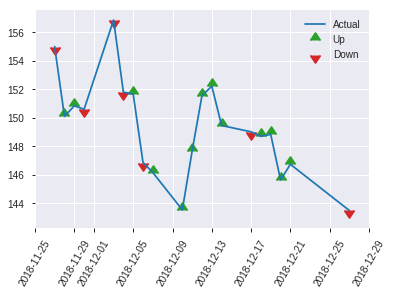


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20936799873975803
RMSE: 0.4575674799849286
LogLoss: 0.6124254343464994
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.14583701949294
Residual deviance: 304.98786630455663
AIC: 406.98786630455663
AUC: 0.7319654148922442
pr_auc: 0.6899147878670765
Gini: 0.4639308297844884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3467424563782642: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   67   0.5317   (67.0/126.0)
1      13   110  0.1057   (13.0/123.0)
Total  72   177  0.3213   (80.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346742     0.733333  176
max f2                       0.200303     0.849858  213
max f0point5                 0.472971     0.683564  131
max accuracy                 0.472971     0.690763  131
max precision                0.843065     0.866667  14
max recall                   0.0410167    1         248
max specificity              0.972173     0.992063  0
max absolute_mcc             0.346742     0.399824  176
max min_per_class_accuracy   0.502534     0.666667  123
max mean_per_class_accuracy  0.472971     0.691154  131

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.929939           1.34959   1.34959            0.666667         0.947342  0.666667                    0.947342            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.921485           1.0122    1.21463            0.5              0.926373  0.6                         0.938954            0.00813008      0.0243902                  1.21951   21.4634
    3        0.0321285                   0.889474           2.02439   1.51829            1                0.908971  0.75                        0.927711            0.0243902       0.0487805                  102.439   51.8293
    4        0.0401606                   0.869172           2.02439   1.61951            1                0.880933  0.8                         0.918355            0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.852612           2.02439   1.71295            1                0.861388  0.846154                    0.905209            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.7972             1.51829   1.61951            0.75             0.818333  0.8                         0.863509            0.0731707       0.162602                   51.8293   61.9512
    7        0.15261                     0.740741           1.71295   1.65148            0.846154         0.769722  0.815789                    0.831424            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.705026           1.34959   1.57902            0.666667         0.72346   0.78                        0.805512            0.0650407       0.317073                   34.9593   57.9024
    9        0.301205                    0.649188           0.890732  1.34959            0.44             0.671234  0.666667                    0.760753            0.0894309       0.406504                   -10.9268  34.9593
    10       0.401606                    0.579448           1.37659   1.35634            0.68             0.61645   0.67                        0.724677            0.138211        0.544715                   37.6585   35.6341
    11       0.502008                    0.499096           1.29561   1.3442             0.64             0.536232  0.664                       0.686988            0.130081        0.674797                   29.561    34.4195
    12       0.598394                    0.407893           0.843496  1.26355            0.416667         0.449875  0.624161                    0.648796            0.0813008       0.756098                   -15.6504  26.3546
    13       0.698795                    0.353068           1.13366   1.24488            0.56             0.385042  0.614943                    0.6109              0.113821        0.869919                   13.3659   24.4884
    14       0.799197                    0.273518           0.72878   1.18005            0.36             0.313443  0.582915                    0.573531            0.0731707       0.943089                   -27.122   18.0047
    15       0.899598                    0.178904           0.404878  1.09353            0.2              0.216035  0.540179                    0.533632            0.0406504       0.98374                    -59.5122  9.35322
    16       1                           0.0410167          0.161951  1                  0.08             0.123697  0.493976                    0.492474         

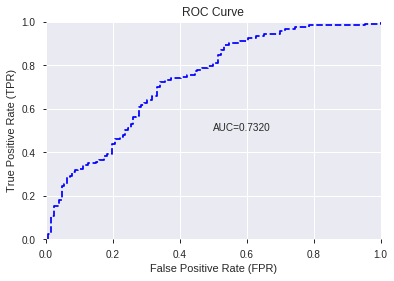

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


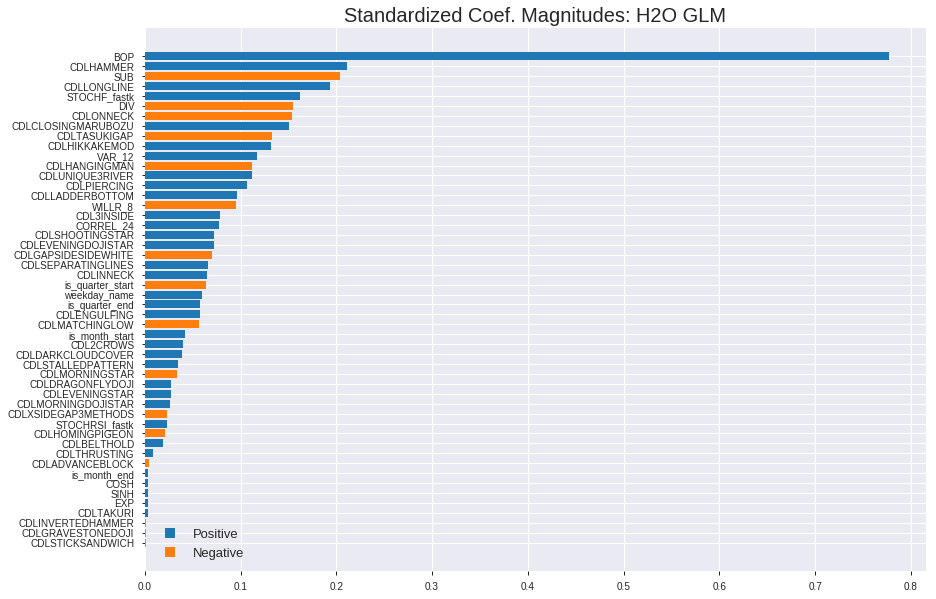

'log_likelihood'
--2019-08-28 18:58:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.100|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_185820_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_185820_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLHAMMER',
 'SUB',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'DIV',
 'CDLONNECK',
 'CDLCLOSINGMARUBOZU',
 'CDLTASUKIGAP',
 'CDLHIKKAKEMOD',
 'VAR_12',
 'CDLHANGINGMAN',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'WILLR_8',
 'CDL3INSIDE',
 'CORREL_24',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDLINNECK',
 'is_quarter_start',
 'weekday_name',
 'is_quarter_end',
 'CDLENGULFING',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDL2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'CDLBELTHOLD',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'is_month_end',
 'COSH',
 'SINH',
 'EXP',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH']

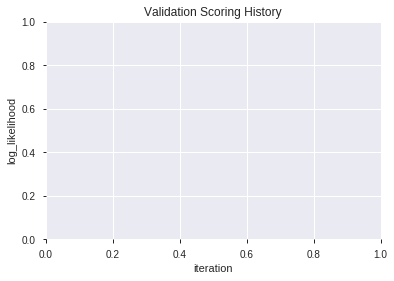

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_185928_model_4  0.742870  0.593479              0.345819  0.452436  0.204699
1  XGBoost_grid_1_AutoML_20190828_185928_model_6  0.742031  0.595803              0.322396  0.452704  0.204941
2  XGBoost_grid_1_AutoML_20190828_185928_model_7  0.740741  0.599044              0.322784  0.453419  0.205589
3  XGBoost_grid_1_AutoML_20190828_185928_model_3  0.740289  0.597652              0.326171  0.452238  0.204519
4  XGBoost_grid_1_AutoML_20190828_185928_model_2  0.734998  0.600432              0.306233  0.455133  0.207146
5               XGBoost_2_AutoML_20190828_185928  0.730417  0.607071              0.322784  0.457939  0.209708
6               XGBoost_3_AutoML_20190828_185928  0.728481  0.606721              0.322396  0.457026  0.208873
7               XGBoost_1_AutoML_20190828_185928  0.724739  0.608233              0.322590  0.458992  0.210674
8  XGBoost_grid_1_AutoML_20190828_185928_model_1  0.723448  0.612292              0.322203  0.459190  0.210855
9  XGBoost_grid_1_AutoML_20190828_185928_model_5  0.695186  0.642921              0.330527  0.473276  0.223990

variable  relative_importance  scaled_importance  percentage
0                  BOP          3227.393799           1.000000    0.637945
1                  SUB           349.627502           0.108331    0.069109
2                  DIV           318.996307           0.098840    0.063055
3         STOCHF_fastk           291.832214           0.090423    0.057685
4               VAR_12           235.897476           0.073092    0.046629
5              WILLR_8           210.014450           0.065072    0.041513
6                 COSH           127.919022           0.039635    0.025285
7            CORREL_24           124.841606           0.038682    0.024677
8         weekday_name            74.006607           0.022931    0.014629
9       STOCHRSI_fastk            71.542877           0.022167    0.014142
10         CDLLONGLINE            17.139202           0.005311    0.003388
11  CDLCLOSINGMARUBOZU             9.834364           0.003047    0.001944

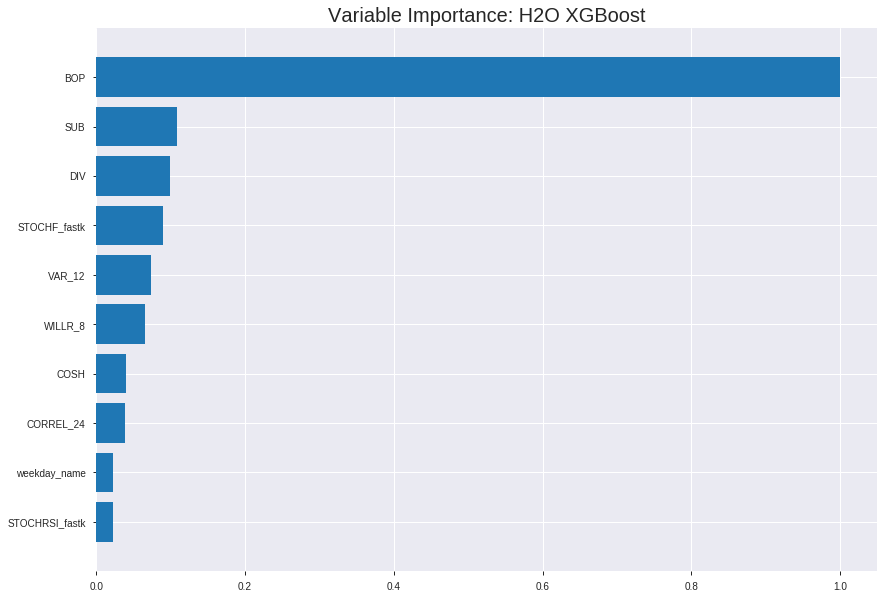

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_185928_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17069250914365805
RMSE: 0.41314949974997917
LogLoss: 0.5165382512827983
Mean Per-Class Error: 0.24457918204792328
AUC: 0.8278761296127232
pr_auc: 0.8254620873099918
Gini: 0.6557522592254463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38968729972839355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      467  359   0.4346   (359.0/826.0)
1      98   817   0.1071   (98.0/915.0)
Total  565  1176  0.2625   (457.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389687     0.781444  258
max f2                       0.188604     0.87225   346
max f0point5                 0.579876     0.774878  170
max accuracy                 0.568644     0.754739  177
max precision                0.884447     1         0
max recall                   0.0979221    1         391
max specificity              0.884447     1         0
max absolute_mcc             0.568644     0.510174  177
max min_per_class_accuracy   0.55911      0.751913  182
max mean_per_class_accuracy  0.568644     0.755421  177

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.871336           1.69132    1.69132            0.888889         0.875473  0.888889                    0.875473            0.0174863       0.0174863                  69.1318   69.1318
    2        0.0201034                   0.865057           1.90273    1.794              1                0.868078  0.942857                    0.871881            0.0185792       0.0360656                  90.2732   79.4005
    3        0.0304423                   0.861024           1.79702    1.79503            0.944444         0.862897  0.943396                    0.86883             0.0185792       0.0546448                  79.7025   79.503
    4        0.0402068                   0.855236           1.79081    1.794              0.941176         0.857907  0.942857                    0.866177            0.0174863       0.0721311                  79.0807   79.4005
    5        0.0505457                   0.850782           1.90273    1.81624            1                0.853779  0.954545                    0.863641            0.0196721       0.0918033                  90.2732   81.6244
    6        0.100517                    0.819634           1.66216    1.73964            0.873563         0.835262  0.914286                    0.849533            0.0830601       0.174863                   66.2157   73.9641
    7        0.150488                    0.789557           1.7059     1.72844            0.896552         0.80521   0.908397                    0.834815            0.0852459       0.260109                   70.5898   72.8436
    8        0.20046                     0.764706           1.50906    1.67375            0.793103         0.777143  0.879656                    0.820438            0.0754098       0.335519                   50.9064   67.375
    9        0.300402                    0.703193           1.53093    1.62624            0.804598         0.734583  0.854685                    0.791874            0.153005        0.488525                   53.0934   62.6236
    10       0.400345                    0.643138           1.32316    1.55058            0.695402         0.674587  0.814921                    0.762594            0.13224         0.620765                   32.3164   55.0577
    11       0.500287                    0.566912           1.22475    1.48549            0.643678         0.607468  0.780712                    0.731605            0.122404        0.743169                   22.4747   48.5486
    12       0.60023                     0.471066           0.874819   1.38381            0.45977          0.521449  0.727273                    0.696612            0.0874317       0.830601                   -12.5181  38.3805
    13       0.700172                    0.357976           0.721726   1.2893             0.37931          0.416317  0.677605                    0.656603            0.0721311       0.902732                   -27.8274  28.93
    14       0.800115                    0.260045           0.513956   1.19245            0.270115         0.312904  0.626705                    0.613671            0.0513661       0.954098                   -48.6044  19.2452
    15       0.900057                    0.156699           0.360863   1.10011            0.189655         0.2136    0.578175                    0.569247            0.0360656       0.990164                   -63.9137  10.0112
    16       1                           0.0833176          0.0984172  1                  0.0517241        0.118763  0.52556                     0.5



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19521205318884075
RMSE: 0.4418280810324766
LogLoss: 0.5709240514763235
Mean Per-Class Error: 0.28381744080734894
AUC: 0.7727956397981628
pr_auc: 0.7875145708804241
Gini: 0.5455912795963256
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29418623447418213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   151  0.6398   (151.0/236.0)
1      16   246  0.0611   (16.0/262.0)
Total  101  397  0.3353   (167.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294186     0.746586  316
max f2                       0.233124     0.870881  347
max f0point5                 0.587207     0.735772  187
max accuracy                 0.587207     0.714859  187
max precision                0.882721     1         0
max recall                   0.123622     1         385
max specificity              0.882721     1         0
max absolute_mcc             0.587207     0.431946  187
max min_per_class_accuracy   0.566475     0.709924  194
max mean_per_class_accuracy  0.587207     0.716183  187

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 54.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.87146            1.90076   1.90076            1                0.878116  1                           0.878116            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.866121           1.90076   1.90076            1                0.868394  1                           0.873255            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.861638           1.90076   1.90076            1                0.864718  1                           0.870409            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.85942            1.90076   1.90076            1                0.86106   1                           0.868072            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.855643           1.52061   1.82473            0.8              0.857885  0.96                        0.866035            0.0152672       0.0916031                  52.0611   82.4733
    6        0.100402                    0.825418           1.67267   1.7487             0.88             0.84195   0.92                        0.853992            0.0839695       0.175573                   67.2672   74.8702
    7        0.150602                    0.798064           1.44458   1.64733            0.76             0.810051  0.866667                    0.839345            0.0725191       0.248092                   44.458    64.7328
    8        0.200803                    0.769326           1.59664   1.63466            0.84             0.783555  0.86                        0.825398            0.0801527       0.328244                   59.6641   63.4656
    9        0.301205                    0.708984           1.40656   1.55863            0.74             0.741161  0.82                        0.797319            0.141221        0.469466                   40.6565   55.8626
    10       0.399598                    0.6592             0.969777  1.41363            0.510204         0.684194  0.743719                    0.769464            0.0954198       0.564885                   -3.02228  41.3633
    11       0.5                         0.571904           1.33053   1.39695            0.7              0.623279  0.73494                     0.740109            0.133588        0.698473                   33.0534   39.6947
    12       0.600402                    0.511741           0.64626   1.27141            0.34             0.54078   0.668896                    0.706777            0.0648855       0.763359                   -35.374   27.1414
    13       0.698795                    0.443086           0.892195  1.21802            0.469388         0.47416   0.640805                    0.674023            0.0877863       0.851145                   -10.7805  21.8018
    14       0.799197                    0.291508           0.874351  1.17484            0.46             0.371024  0.61809                     0.635958            0.0877863       0.938931                   -12.5649  17.4844
    15       0.899598                    0.213936           0.494198  1.09888            0.26             0.250233  0.578125                    0.592908            0.0496183       0.98855                    -50.5802  9.88788
    16       1                           0.0849741          0.114046  1                  0.06             0.143929  0.526104                    0.54783          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:59:39  4.063 sec   0                  0.5              0.693147            0.5             0                  1                0.47444                          0.5                0.693147              0.5               0                    1                  0.473896
    2019-08-28 18:59:39  4.161 sec   5                  0.47293          0.640071            0.801273        0.744573           1.74417          0.299828                         0.476277           0.646469              0.770467          0.738402             1.66317            0.343373
    2019-08-28 18:59:39  4.215 sec   10                 0.454631         0.604574            0.807926        0.789471           1.80259          0.284319                         0.461803           0.618003              0.774292          0.774411             1.90076            0.339357
    2019-08-28 18:59:39  4.290 sec   15                 0.442752         0.581025            0.811312        0.809815           1.80259          0.272832                         0.453069           0.600232              0.776693          0.792661             1.90076            0.333333
    2019-08-28 18:59:39  4.352 sec   20                 0.434323         0.563661            0.813447        0.810748           1.80259          0.278001                         0.447617           0.588398              0.775747          0.789279             1.90076            0.339357
    2019-08-28 18:59:39  4.417 sec   25                 0.428792         0.55184             0.814802        0.81188            1.79702          0.261918                         0.444619           0.581396              0.774995          0.785056             1.90076            0.337349
    2019-08-28 18:59:39  4.479 sec   30                 0.425291         0.544005            0.816147        0.809611           1.69132          0.26077                          0.442921           0.57691               0.776305          0.788574             1.90076            0.345382
    2019-08-28 18:59:39  4.562 sec   35                 0.422471         0.537432            0.81723         0.813679           1.69132          0.261344                         0.442308           0.574697              0.774656          0.786625             1.90076            0.329317
    2019-08-28 18:59:40  4.642 sec   40                 0.420406         0.53255             0.818557        0.816198           1.79702          0.268811                         0.441208           0.57185               0.775149          0.78378              1.90076            0.349398
    2019-08-28 18:59:40  4.710 sec   45                 0.418081         0.527388            0.821163        0.819537           1.90273          0.265365                         0.440723           0.57024               0.775311          0.786099             1.90076            0.331325
    2019-08-28 18:59:40  4.790 sec   50                 0.416423         0.523725            0.823534        0.82306            1.90273          0.260195                         0.441335           0.570852              0.774017          0.788607             1.90076            0.331325
    2019-08-28 18:59:40  4.863 sec   55                 0.414738         0.519918            0.824988        0.822045           1.90273          0.264216                         0.441568           0.570733              0.773022          0

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 3227.39                1                    0.637945
SUB                 349.628                0.108331             0.0691094
DIV                 318.996                0.0988402            0.0630546
STOCHF_fastk        291.832                0.0904235            0.0576852
VAR_12              235.897                0.0730923            0.0466289
WILLR_8             210.014                0.0650725            0.0415127
COSH                127.919                0.0396354            0.0252852
CORREL_24           124.842                0.0386819            0.0246769
weekday_name        74.0066                0.0229308            0.0146286
STOCHRSI_fastk      71.5429                0.0221674            0.0141416
CDLLONGLINE         17.1392                0.00531054           0.00338783
CDLCLOSINGMARUBOZU  9.83436                0.00304715           0.00194392

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7289719626168225)

('auc', 0.7428700477480966)

('logloss', 0.5934792903846644)

('mean_per_class_error', 0.30497483546264026)

('rmse', 0.45243626073755255)

('mse', 0.20469857003017866)

xgboost prediction progress: |████████████████████████████████████████████| 100%


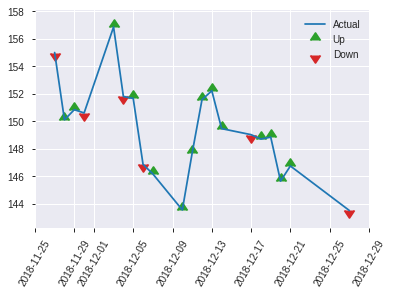


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20469857003017866
RMSE: 0.45243626073755255
LogLoss: 0.5934792903846644
Mean Per-Class Error: 0.30497483546264026
AUC: 0.7428700477480966
pr_auc: 0.7018135944981728
Gini: 0.48574009549619324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27433082461357117: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   81   0.6429   (81.0/126.0)
1      6    117  0.0488   (6.0/123.0)
Total  51   198  0.3494   (87.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274331     0.728972  197
max f2                       0.211916     0.853315  216
max f0point5                 0.535649     0.689382  126
max accuracy                 0.535649     0.694779  126
max precision                0.871194     1         0
max recall                   0.0930752    1         244
max specificity              0.871194     1         0
max absolute_mcc             0.52906      0.390277  128
max min_per_class_accuracy   0.55023      0.682927  121
max mean_per_class_accuracy  0.52906      0.695025  128

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.86664            1.34959   1.34959            0.666667         0.868992  0.666667                    0.868992            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.864143           2.02439   1.61951            1                0.865752  0.8                         0.867696            0.0162602       0.0325203                  102.439   61.9512
    3        0.0321285                   0.850822           1.34959   1.51829            0.666667         0.858999  0.75                        0.864434            0.0162602       0.0487805                  34.9593   51.8293
    4        0.0401606                   0.823417           2.02439   1.61951            1                0.841912  0.8                         0.85993             0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.810866           2.02439   1.71295            1                0.819787  0.846154                    0.850666            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.760902           1.68699   1.70049            0.833333         0.781163  0.84                        0.817305            0.0813008       0.170732                   68.6992   70.0488
    7        0.15261                     0.730492           1.4015    1.5982             0.692308         0.74528   0.789474                    0.792665            0.0731707       0.243902                   40.1501   59.8203
    8        0.200803                    0.709694           1.68699   1.61951            0.833333         0.720698  0.8                         0.775392            0.0813008       0.325203                   68.6992   61.9512
    9        0.301205                    0.666741           1.05268   1.43057            0.52             0.691339  0.706667                    0.747375            0.105691        0.430894                   5.26829   43.0569
    10       0.401606                    0.610374           1.21463   1.37659            0.6              0.642614  0.68                        0.721185            0.121951        0.552846                   21.4634   37.6585
    11       0.502008                    0.539635           1.37659   1.37659            0.68             0.579655  0.68                        0.692879            0.138211        0.691057                   37.6585   37.6585
    12       0.598394                    0.470785           0.759146  1.27713            0.375            0.502255  0.630872                    0.662174            0.0731707       0.764228                   -24.0854  27.7132
    13       0.698795                    0.362562           0.971707  1.23325            0.48             0.423491  0.609195                    0.627881            0.097561        0.861789                   -2.82927  23.3249
    14       0.799197                    0.272908           0.890732  1.19022            0.44             0.305097  0.58794                     0.58733             0.0894309       0.95122                    -10.9268  19.0219
    15       0.899598                    0.166198           0.323902  1.09353            0.16             0.224987  0.540179                    0.54689             0.0325203       0.98374                    -67.6098  9.35322
    16       1                           0.0898337          0.161951  1                  0.08             0.116807  0.493976                    0.503709         

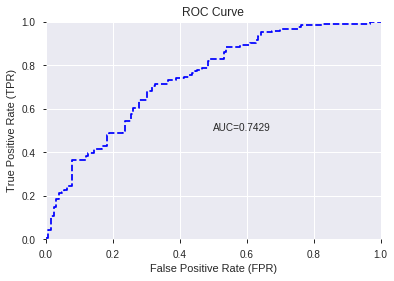

This function is available for GLM models only


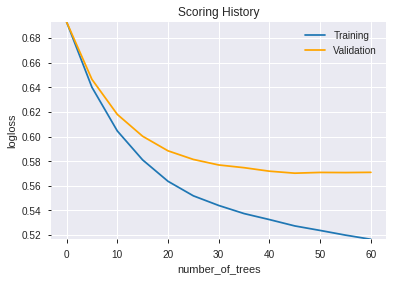

--2019-08-28 18:59:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_185928_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_185928_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'VAR_12',
 'WILLR_8',
 'COSH',
 'CORREL_24',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_190053_model_1  0.74358  0.605128              0.306911  0.454234  0.206328

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.513681           1.000000  3.994248e-02
1                STOCHF_fastk             0.207106           0.403180  1.610401e-02
2                         DIV             0.201643           0.392546  1.567925e-02
3                 CDLLONGLINE             0.186345           0.362763  1.448967e-02
4                         SUB             0.174437           0.339583  1.356377e-02
...                       ...                  ...                ...           ...
1033  BBANDS_lowerband_20_6_4             0.000047           0.000092  3.684058e-06
1034                MAVP_14_6             0.000040           0.000078  3.112241e-06
1035  BBANDS_lowerband_14_3_3             0.000021           0.000041  1.647424e-06
1036                  TRIMA_8             0.000021           0.000040  1.603162e-06
1037  BBANDS_lowerband_20_7_4             0.000007           0.000013  5.391469e-07

[1038 rows x 4 columns]

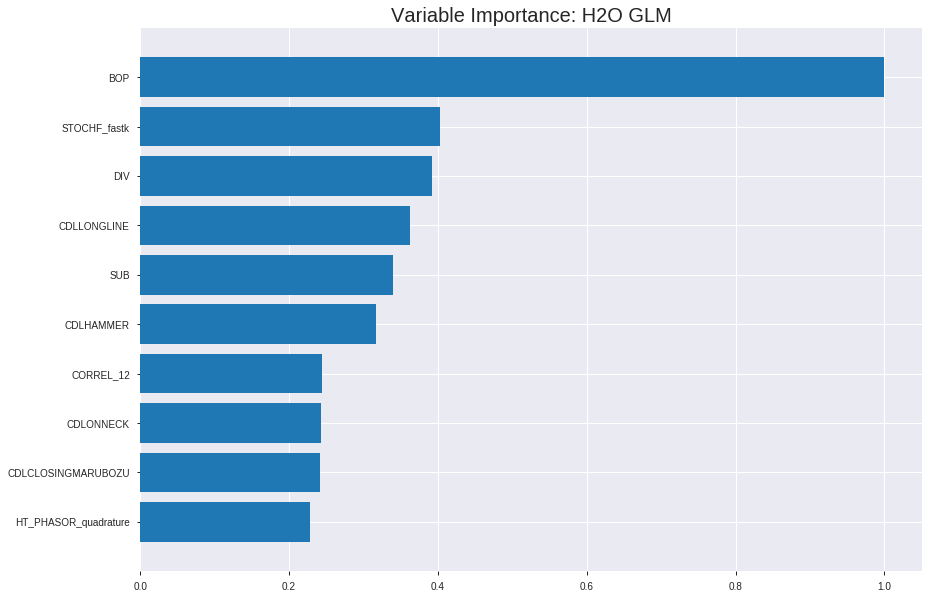

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_190053_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1707599901405554
RMSE: 0.413231158240222
LogLoss: 0.5148494427961181
Null degrees of freedom: 1740
Residual degrees of freedom: 702
Null deviance: 2408.986814961971
Residual deviance: 1792.7057598160832
AIC: 3870.705759816083
AUC: 0.826276478916101
pr_auc: 0.82839397777304
Gini: 0.652552957832202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3764911281921852: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  376   0.4552   (376.0/826.0)
1      87   828   0.0951   (87.0/915.0)
Total  537  1204  0.2659   (463.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376491     0.781501  267
max f2                       0.221417     0.868123  327
max f0point5                 0.655072     0.771649  141
max accuracy                 0.486407     0.750144  217
max precision                0.97839      1         0
max recall                   0.0712107    1         384
max specificity              0.97839      1         0
max absolute_mcc             0.486407     0.498679  217
max min_per_class_accuracy   0.544736     0.746973  192
max mean_per_class_accuracy  0.569566     0.748494  182

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.940265           1.90273   1.90273            1                0.958336  1                           0.958336            0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.924288           1.79081   1.84837            0.941176         0.93228   0.971429                    0.94568             0.0174863       0.0371585                  79.0807   84.8368
    3        0.0304423                   0.91337            1.90273   1.86683            1                0.91995   0.981132                    0.936942            0.0196721       0.0568306                  90.2732   86.6832
    4        0.0402068                   0.902863           1.67888   1.82119            0.882353         0.906931  0.957143                    0.929654            0.0163934       0.073224                   67.8881   82.1187
    5        0.0505457                   0.889482           1.58561   1.773              0.833333         0.89636   0.931818                    0.922844            0.0163934       0.0896175                  58.561    77.3
    6        0.100517                    0.844282           1.74964   1.76139            0.91954          0.8656    0.925714                    0.894385            0.0874317       0.177049                   74.9639   76.1386
    7        0.150488                    0.799683           1.61842   1.71391            0.850575         0.820912  0.900763                    0.869988            0.0808743       0.257923                   61.8416   71.3911
    8        0.20046                     0.769957           1.57467   1.6792             0.827586         0.784169  0.882521                    0.848595            0.0786885       0.336612                   57.4675   67.9202
    9        0.300402                    0.702743           1.5528    1.63715            0.816092         0.737076  0.860421                    0.811493            0.155191        0.491803                   55.2804   63.715
    10       0.400345                    0.634519           1.25755   1.54239            0.66092          0.66888   0.810617                    0.775891            0.125683        0.617486                   25.7553   54.2387
    11       0.500287                    0.558486           1.17007   1.46801            0.614943         0.598928  0.771527                    0.740539            0.11694         0.734426                   17.0071   46.8009
    12       0.60023                     0.459553           0.951366  1.38198            0.5              0.506433  0.726316                    0.701559            0.095082        0.829508                   -4.86339  38.1984
    13       0.700172                    0.366783           0.798273  1.29867            0.41954          0.41033   0.682527                    0.659989            0.0797814       0.90929                    -20.1727  29.8665
    14       0.800115                    0.272788           0.470215  1.19518            0.247126         0.318314  0.628141                    0.61731             0.0469945       0.956284                   -52.9785  19.5184
    15       0.900057                    0.164672           0.284316  1.09404            0.149425         0.215266  0.574984                    0.572667            0.0284153       0.984699                   -71.5684  9.40407
    16       1                           0.0128486          0.153093  1                  0.0804598        0.101327  0.52556                     0.52556             0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18414230371130244
RMSE: 0.42911805335047654
LogLoss: 0.5442773452180538
Null degrees of freedom: 497
Residual degrees of freedom: -541
Null deviance: 689.0171367028406
Residual deviance: 542.1002358371816
AIC: 2620.1002358371816
AUC: 0.794944365377151
pr_auc: 0.8093116547858675
Gini: 0.5898887307543019
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28444679314761234: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   147  0.6229   (147.0/236.0)
1      13   249  0.0496   (13.0/262.0)
Total  102  396  0.3213   (160.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284447     0.756839  318
max f2                       0.22028      0.870596  342
max f0point5                 0.606862     0.761682  169
max accuracy                 0.495849     0.726908  227
max precision                0.984708     1         0
max recall                   0.0497934    1         397
max specificity              0.984708     1         0
max absolute_mcc             0.606862     0.464612  169
max min_per_class_accuracy   0.530085     0.71374   207
max mean_per_class_accuracy  0.606862     0.728442  169

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 52.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.966624           1.90076   1.90076            1                0.979304  1                           0.979304            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.935552           1.90076   1.90076            1                0.948237  1                           0.963771            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.929987           1.90076   1.90076            1                0.933462  1                           0.953668            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.918663           1.90076   1.90076            1                0.923398  1                           0.9461              0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.912978           1.90076   1.90076            1                0.916779  1                           0.940236            0.019084        0.0954198                  90.0763   90.0763
    6        0.100402                    0.862937           1.67267   1.78672            0.88             0.886004  0.94                        0.91312             0.0839695       0.179389                   67.2672   78.6718
    7        0.150602                    0.814946           1.52061   1.69802            0.8              0.837847  0.893333                    0.888029            0.0763359       0.255725                   52.0611   69.8015
    8        0.200803                    0.774526           1.52061   1.65366            0.8              0.794526  0.87                        0.864653            0.0763359       0.332061                   52.0611   65.3664
    9        0.301205                    0.699428           1.36855   1.55863            0.72             0.729907  0.82                        0.819738            0.137405        0.469466                   36.855    55.8626
    10       0.399598                    0.611798           1.43527   1.52825            0.755102         0.655899  0.80402                     0.779396            0.141221        0.610687                   43.527    52.8252
    11       0.5                         0.533993           0.874351  1.39695            0.46             0.572729  0.73494                     0.737896            0.0877863       0.698473                   -12.5649  39.6947
    12       0.600402                    0.461372           0.950382  1.32227            0.5              0.501927  0.695652                    0.698437            0.0954198       0.793893                   -4.96183  32.227
    13       0.698795                    0.382416           0.659449  1.22894            0.346939         0.423602  0.646552                    0.659739            0.0648855       0.858779                   -34.0551  22.8942
    14       0.799197                    0.279402           0.912366  1.18917            0.48             0.332064  0.625628                    0.618573            0.0916031       0.950382                   -8.76336  18.9171
    15       0.899598                    0.170039           0.342137  1.09464            0.18             0.228605  0.575893                    0.57505             0.0343511       0.984733                   -65.7863  9.4636
    16       1                           0.0153336          0.152061  1                  0.08             0.108559  0.526104                    0.528214           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:00:58  0.000 sec   2            .24E2     1039          1.3560890606828326  1.3573174719096157
     2019-08-28 19:01:00  2.224 sec   4            .18E2     1039          1.3482622685280874  1.3499309548177423
     2019-08-28 19:01:02  4.594 sec   6            .13E2     1039          1.3385656834256525  1.3408101460965531
     2019-08-28 19:01:05  6.873 sec   8            .93E1     1039          1.3267658566145928  1.329715543888701
     2019-08-28 19:01:07  9.166 sec   10           .68E1     1039          1.3126448911315427  1.3164456923626806
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:01:45  47.553 sec  44           .31E-1    1039          1.0218658626188155  1.0892358160127544
     2019-08-28 19:01:48  49.842 sec  46           .22E-1    1039          1.0147553133101037  1.0911477915978027
     2019-08-28 19:01:50  52.165 sec  48           .16E-1    1039          1.008263128108485   1.0940940908569312
     2019-08-28 19:01:53  54.989 sec  50           .12E-1    1039          1.0022456200329142  1.097995256044237
     2019-08-28 19:01:56  58.247 sec  52           .86E-2    1039          0.9966307234786237  1.1027376915174483


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.7389830508474576)

('auc', 0.7435798167505484)

('logloss', 0.6051277297043508)

('mean_per_class_error', 0.30691056910569103)

('rmse', 0.45423388114234786)

('mse', 0.2063284187776406)

glm prediction progress: |████████████████████████████████████████████████| 100%


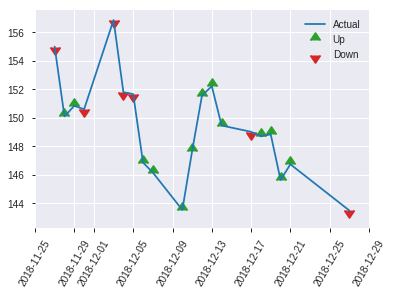


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2063284187776406
RMSE: 0.45423388114234786
LogLoss: 0.6051277297043508
Null degrees of freedom: 248
Residual degrees of freedom: -790
Null deviance: 346.14583701949294
Residual deviance: 301.35360939276666
AIC: 2379.353609392767
AUC: 0.7435798167505484
pr_auc: 0.693682017458318
Gini: 0.4871596335010968
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3169289504760736: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   63   0.5      (63.0/126.0)
1      14   109  0.1138   (14.0/123.0)
Total  77   172  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316929     0.738983  171
max f2                       0.197151     0.846373  210
max f0point5                 0.52994      0.691769  111
max accuracy                 0.52994      0.690763  111
max precision                0.883515     0.888889  8
max recall                   0.0596199    1         244
max specificity              0.974053     0.992063  0
max absolute_mcc             0.316929     0.41775   171
max min_per_class_accuracy   0.500202     0.690476  123
max mean_per_class_accuracy  0.316929     0.693089  171

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 47.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.910511           1.34959   1.34959            0.666667         0.936552   0.666667                    0.936552            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.897631           2.02439   1.61951            1                0.905904   0.8                         0.924293            0.0162602       0.0325203                  102.439   61.9512
    3        0.0321285                   0.88387            2.02439   1.77134            1                0.891217   0.875                       0.91189             0.0243902       0.0569106                  102.439   77.1341
    4        0.0401606                   0.872408           1.0122    1.61951            0.5              0.879716   0.8                         0.905455            0.00813008      0.0650407                  1.21951   61.9512
    5        0.0522088                   0.841802           2.02439   1.71295            1                0.858987   0.846154                    0.894732            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.757491           1.34959   1.53854            0.666667         0.786276   0.76                        0.842673            0.0650407       0.154472                   34.9593   53.8537
    7        0.15261                     0.725707           1.55722   1.54493            0.769231         0.738556   0.763158                    0.807054            0.0813008       0.235772                   55.7223   54.4929
    8        0.200803                    0.690357           1.18089   1.45756            0.583333         0.706082   0.72                        0.782821            0.0569106       0.292683                   18.0894   45.7561
    9        0.301205                    0.632629           1.37659   1.43057            0.68             0.65664    0.706667                    0.74076             0.138211        0.430894                   37.6585   43.0569
    10       0.401606                    0.567528           1.29561   1.39683            0.64             0.598165   0.69                        0.705112            0.130081        0.560976                   29.561    39.6829
    11       0.502008                    0.49838            1.29561   1.37659            0.64             0.528144   0.68                        0.669718            0.130081        0.691057                   29.561    37.6585
    12       0.598394                    0.404447           1.0122    1.31789            0.5              0.446189   0.651007                    0.633714            0.097561        0.788618                   1.21951   31.7892
    13       0.698795                    0.30583            0.971707  1.26815            0.48             0.35414    0.626437                    0.593545            0.097561        0.886179                   -2.82927  26.8153
    14       0.799197                    0.241672           0.566829  1.18005            0.28             0.276603   0.582915                    0.553728            0.0569106       0.943089                   -43.3171  18.0047
    15       0.899598                    0.139399           0.242927  1.07546            0.12             0.19109    0.53125                     0.513255            0.0243902       0.96748                    -75.7073  7.54573
    16       1                           0.0245335          0.323902  1                  0.16             0.0986669  0.493976                   

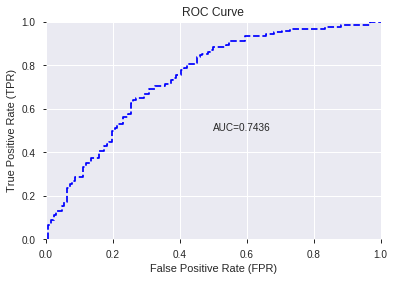

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


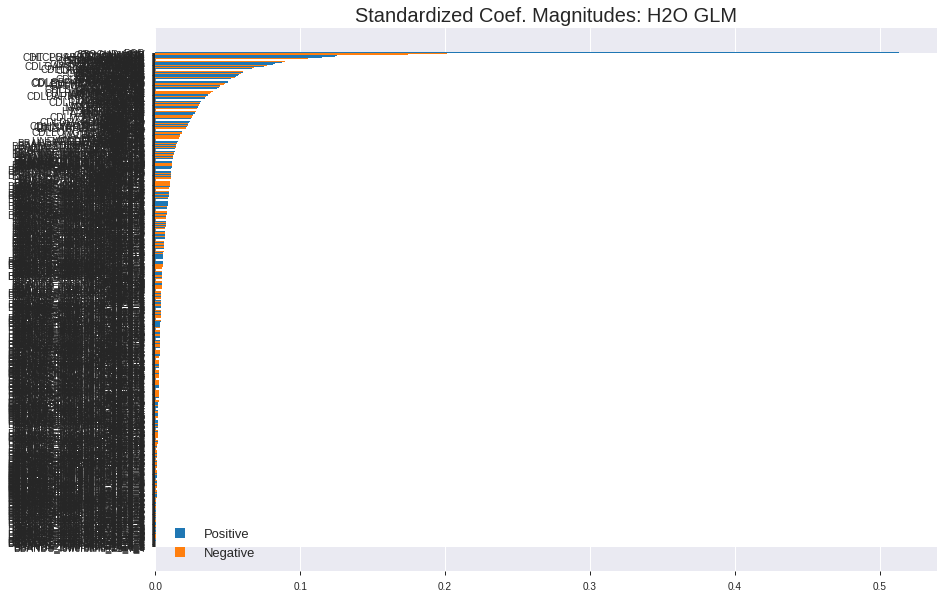

'log_likelihood'
--2019-08-28 19:02:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_190053_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_190053_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

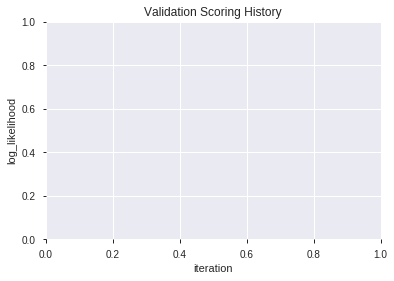

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_190325_model_4  0.739902  0.595714              0.337882  0.453344  0.205521
1               XGBoost_1_AutoML_20190828_190325  0.736418  0.595134              0.294328  0.452661  0.204902
2  XGBoost_grid_1_AutoML_20190828_190325_model_3  0.735966  0.596659              0.302942  0.453161  0.205355
3  XGBoost_grid_1_AutoML_20190828_190325_model_7  0.732933  0.604268              0.310588  0.455754  0.207712
4  XGBoost_grid_1_AutoML_20190828_190325_model_2  0.730417  0.602632              0.314170  0.456469  0.208364
5               XGBoost_2_AutoML_20190828_190325  0.727836  0.607130              0.314170  0.458673  0.210381
6  XGBoost_grid_1_AutoML_20190828_190325_model_1  0.727126  0.608447              0.334204  0.458594  0.210308
7  XGBoost_grid_1_AutoML_20190828_190325_model_5  0.726739  0.639562              0.314750  0.466483  0.217607
8  XGBoost_grid_1_AutoML_20190828_190325_model_6  0.726352  0.608338              0.345819  0.457853  0.209630
9               XGBoost_3_AutoML_20190828_190325  0.722738  0.609007              0.322009  0.458749  0.210451

variable  relative_importance  scaled_importance  percentage
0                        BOP          3108.343750           1.000000    0.478212
1                        DIV           257.407379           0.082812    0.039602
2               STOCHF_fastk           208.979523           0.067232    0.032151
3                        SUB           137.845795           0.044347    0.021207
4                   WILLR_12            97.614235           0.031404    0.015018
..                       ...                  ...                ...         ...
144  BBANDS_upperband_12_5_4             4.574977           0.001472    0.000704
145              AROONOSC_30             4.251865           0.001368    0.000654
146                    ADOSC             4.219800           0.001358    0.000649
147              MIDPOINT_30             3.744302           0.001205    0.000576
148  BBANDS_lowerband_24_3_5             2.222791           0.000715    0.000342

[149 rows x 4 columns]

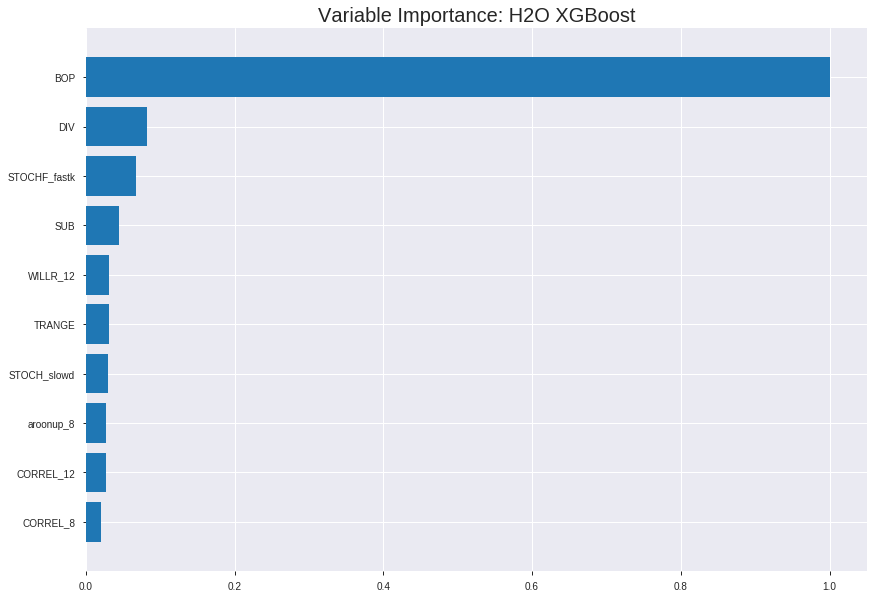

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_190325_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15649010259912563
RMSE: 0.39558829937085555
LogLoss: 0.48462918651059966
Mean Per-Class Error: 0.21639939665780172
AUC: 0.8637266965691528
pr_auc: 0.8706055513270246
Gini: 0.7274533931383056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4267208129167557: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      548  278   0.3366   (278.0/826.0)
1      110  805   0.1202   (110.0/915.0)
Total  658  1083  0.2229   (388.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426721     0.805806  236
max f2                       0.230887     0.87822   331
max f0point5                 0.650097     0.808563  135
max accuracy                 0.527534     0.784607  192
max precision                0.89643      1         0
max recall                   0.150172     1         367
max specificity              0.89643      1         0
max absolute_mcc             0.527534     0.567787  192
max min_per_class_accuracy   0.550224     0.776029  183
max mean_per_class_accuracy  0.527534     0.783601  192

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.876717           1.79702    1.79702            0.944444         0.883545  0.944444                    0.883545            0.0185792       0.0185792                  79.7025   79.7025
    2        0.0201034                   0.867689           1.90273    1.84837            1                0.8717    0.971429                    0.877792            0.0185792       0.0371585                  90.2732   84.8368
    3        0.0304423                   0.855822           1.90273    1.86683            1                0.861485  0.981132                    0.872254            0.0196721       0.0568306                  90.2732   86.6832
    4        0.0402068                   0.851125           1.90273    1.87555            1                0.85345   0.985714                    0.867687            0.0185792       0.0754098                  90.2732   87.555
    5        0.0505457                   0.844442           1.79702    1.85949            0.944444         0.847775  0.977273                    0.863614            0.0185792       0.0939891                  79.7025   85.9488
    6        0.100517                    0.817235           1.83712    1.84837            0.965517         0.830396  0.971429                    0.8471              0.0918033       0.185792                   83.7121   84.8368
    7        0.150488                    0.791012           1.72777    1.80832            0.908046         0.805363  0.950382                    0.833241            0.0863388       0.272131                   72.7768   80.8322
    8        0.20046                     0.761799           1.57467    1.75008            0.827586         0.776928  0.919771                    0.819203            0.0786885       0.35082                    57.4675   75.0078
    9        0.300402                    0.702943           1.65122    1.71719            0.867816         0.732056  0.902486                    0.790209            0.165027        0.515847                   65.1222   71.7189
    10       0.400345                    0.644878           1.34503    1.62428            0.706897         0.675375  0.853659                    0.761542            0.134426        0.650273                   34.5035   62.4284
    11       0.500287                    0.562908           1.13727    1.52699            0.597701         0.603933  0.802526                    0.730056            0.113661        0.763934                   13.7265   52.6992
    12       0.60023                     0.450916           0.951366   1.43115            0.5              0.506011  0.752153                    0.692751            0.095082        0.859016                   -4.86339  43.1146
    13       0.700172                    0.354846           0.612374   1.31427            0.321839         0.399577  0.69073                     0.650904            0.0612022       0.920219                   -38.7626  31.4274
    14       0.800115                    0.271076           0.43741    1.20475            0.229885         0.308773  0.633166                    0.608168            0.0437158       0.963934                   -56.259   20.4745
    15       0.900057                    0.17552            0.349928   1.10983            0.183908         0.222757  0.58328                     0.565372            0.0349727       0.998907                   -65.0072  10.9826
    16       1                           0.0808362          0.0109352  1                  0.00574713       0.135812  0.52556                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19291104594457267
RMSE: 0.43921639990393424
LogLoss: 0.5674540478561081
Mean Per-Class Error: 0.28317052658817443
AUC: 0.7767256436796481
pr_auc: 0.7790542213318111
Gini: 0.5534512873592963
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.466727077960968: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  97   0.411    (97.0/236.0)
1      48   214  0.1832   (48.0/262.0)
Total  187  311  0.2912   (145.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466727     0.746946  241
max f2                       0.196316     0.864362  362
max f0point5                 0.62846      0.733743  167
max accuracy                 0.56455      0.716867  195
max precision                0.895629     1         0
max recall                   0.163713     1         376
max specificity              0.895629     1         0
max absolute_mcc             0.56455      0.433193  195
max min_per_class_accuracy   0.56455      0.716102  195
max mean_per_class_accuracy  0.56455      0.716829  195

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 54.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.869458           1.90076   1.90076            1                0.882838  1                           0.882838            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.864454           1.52061   1.71069            0.8              0.866892  0.9                         0.874865            0.0152672       0.0343511                  52.0611   71.0687
    3        0.0301205                   0.854057           1.90076   1.77405            1                0.857105  0.933333                    0.868945            0.019084        0.0534351                  90.0763   77.4046
    4        0.0401606                   0.849114           1.52061   1.71069            0.8              0.852421  0.9                         0.864814            0.0152672       0.0687023                  52.0611   71.0687
    5        0.0502008                   0.842969           1.90076   1.7487             1                0.847426  0.92                        0.861336            0.019084        0.0877863                  90.0763   74.8702
    6        0.100402                    0.817831           1.44458   1.59664            0.76             0.832277  0.84                        0.846807            0.0725191       0.160305                   44.458    59.6641
    7        0.150602                    0.794471           1.59664   1.59664            0.84             0.808247  0.84                        0.833953            0.0801527       0.240458                   59.6641   59.6641
    8        0.200803                    0.76662            1.67267   1.61565            0.88             0.781049  0.85                        0.820727            0.0839695       0.324427                   67.2672   61.5649
    9        0.301205                    0.709724           1.33053   1.52061            0.7              0.738741  0.8                         0.793398            0.133588        0.458015                   33.0534   52.0611
    10       0.399598                    0.648661           1.28011   1.46139            0.673469         0.679857  0.768844                    0.765441            0.125954        0.583969                   28.0106   46.1391
    11       0.5                         0.571576           1.17847   1.40458            0.62             0.616454  0.738956                    0.735524            0.118321        0.70229                    17.8473   40.458
    12       0.600402                    0.489665           0.912366  1.32227            0.48             0.532004  0.695652                    0.701491            0.0916031       0.793893                   -8.76336  32.227
    13       0.698795                    0.415907           0.69824   1.2344             0.367347         0.4511    0.649425                    0.666234            0.0687023       0.862595                   -30.176   23.4404
    14       0.799197                    0.293531           0.608244  1.15574            0.32             0.34634   0.60804                     0.626047            0.0610687       0.923664                   -39.1756  15.5741
    15       0.899598                    0.212724           0.532214  1.08615            0.28             0.248512  0.571429                    0.583911            0.0534351       0.977099                   -46.7786  8.61505
    16       1                           0.0776582          0.228092  1                  0.12             0.15348   0.526104                    0.540695           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:04:01  16.523 sec  0                  0.5              0.693147            0.5             0                  1                0.47444                          0.5                0.693147              0.5               0                    1                  0.473896
    2019-08-28 19:04:02  17.950 sec  5                  0.472244         0.638774            0.811221        0.766441           1.82176          0.271683                         0.477403           0.648666              0.772036          0.755649             1.52061            0.303213
    2019-08-28 19:04:02  18.330 sec  10                 0.455626         0.606697            0.818345        0.819284           1.90273          0.274555                         0.462593           0.619637              0.773992          0.77825              1.52061            0.337349
    2019-08-28 19:04:03  18.726 sec  15                 0.441739         0.579545            0.824208        0.829246           1.90273          0.267088                         0.45526            0.604624              0.771752          0.777157             1.90076            0.331325
    2019-08-28 19:04:03  19.116 sec  20                 0.431186         0.558462            0.830299        0.835727           1.90273          0.265939                         0.4493             0.592173              0.77785           0.791548             1.90076            0.341365
    2019-08-28 19:04:04  19.504 sec  25                 0.423708         0.543159            0.835131        0.842125           1.90273          0.259047                         0.446321           0.585232              0.773774          0.782162             1.90076            0.297189
    2019-08-28 19:04:04  19.892 sec  30                 0.418337         0.53173             0.838218        0.846592           1.90273          0.259621                         0.444129           0.580095              0.774178          0.780428             1.90076            0.301205
    2019-08-28 19:04:04  20.289 sec  35                 0.413705         0.52181             0.841406        0.84743            1.90273          0.252728                         0.441564           0.574237              0.776143          0.78222              1.90076            0.295181
    2019-08-28 19:04:05  20.690 sec  40                 0.410098         0.514336            0.845248        0.851429           1.90273          0.248708                         0.440741           0.571861              0.778125          0.782436             1.90076            0.303213
    2019-08-28 19:04:05  21.094 sec  45                 0.407631         0.509314            0.848038        0.85466            1.90273          0.234922                         0.440942           0.572075              0.775788          0.783311             1.90076            0.287149
    2019-08-28 19:04:06  21.502 sec  50                 0.404028         0.50185             0.853353        0.859812           1.90273          0.239518                         0.440861           0.57131               0.774922          0.780059             1.90076            0.291165
    2019-08-28 19:04:06  21.888 sec  55                 0.40049          0.494239            0.856508        0.863212           1.90273          0.232051                         0.44               0.568898              0.776111          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      3108.34375             1.0                    0.47821201438254474
DIV                      257.4073791503906      0.0828117479446701     0.039601572799160246
STOCHF_fastk             208.97952270507812     0.06723179272082701    0.03215105102757639
SUB                      137.84579467773438     0.0443470239344456     0.021207279647562152
WILLR_12                 97.6142349243164       0.03140393816620713    0.015017740530006792
---                      ---                    ---                    ---
BBANDS_upperband_12_5_4  4.574976921081543      0.0014718375086672905  0.0007038503798635712
AROONOSC_30              4.251865386962891      0.0013678877656188736  0.0006541403638458397
ADOSC                    4.2198004722595215     0.0013575720099360058  0.0006492072455408573
MIDPOINT_30              3.7443017959594727     0.0012045970771281242  0.0005760527947727659
BBANDS_lowerband_24_3_5  2.2227907180786133     0.0007151045369671913  0.00034197158111717754


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6987951807228916)

('F1', 0.7335423197492162)

('auc', 0.7399019228287521)

('logloss', 0.5957144879182461)

('mean_per_class_error', 0.30110336817653893)

('rmse', 0.453343954954297)

('mse', 0.2055207414936037)

xgboost prediction progress: |████████████████████████████████████████████| 100%


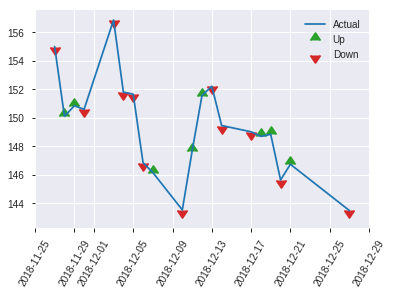


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2055207414936037
RMSE: 0.453343954954297
LogLoss: 0.5957144879182461
Mean Per-Class Error: 0.30110336817653893
AUC: 0.7399019228287521
pr_auc: 0.6939594823329669
Gini: 0.4798038456575042
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.286617636680603: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   79   0.627    (79.0/126.0)
1      6    117  0.0488   (6.0/123.0)
Total  53   196  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286618     0.733542  195
max f2                       0.248996     0.858369  206
max f0point5                 0.548911     0.695581  121
max accuracy                 0.548911     0.698795  121
max precision                0.832925     0.857143  6
max recall                   0.135812     1         237
max specificity              0.867453     0.992063  0
max absolute_mcc             0.542334     0.397793  125
max min_per_class_accuracy   0.543364     0.698413  123
max mean_per_class_accuracy  0.542334     0.698897  125

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.855026           1.34959   1.34959            0.666667         0.865531  0.666667                    0.865531            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.844054           2.02439   1.61951            1                0.846972  0.8                         0.858107            0.0162602       0.0325203                  102.439   61.9512
    3        0.0321285                   0.830362           1.34959   1.51829            0.666667         0.835784  0.75                        0.849736            0.0162602       0.0487805                  34.9593   51.8293
    4        0.0401606                   0.822248           2.02439   1.61951            1                0.826424  0.8                         0.845074            0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.821272           2.02439   1.71295            1                0.821669  0.846154                    0.839673            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.7884             1.51829   1.61951            0.75             0.807247  0.8                         0.824108            0.0731707       0.162602                   51.8293   61.9512
    7        0.15261                     0.755846           1.71295   1.65148            0.846154         0.773538  0.815789                    0.806808            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.731025           1.18089   1.53854            0.583333         0.740854  0.76                        0.790979            0.0569106       0.308943                   18.0894   53.8537
    9        0.301205                    0.694984           1.05268   1.37659            0.52             0.710025  0.68                        0.763994            0.105691        0.414634                   5.26829   37.6585
    10       0.401606                    0.623537           1.37659   1.37659            0.68             0.660377  0.68                        0.73809             0.138211        0.552846                   37.6585   37.6585
    11       0.502008                    0.542509           1.45756   1.39278            0.72             0.578897  0.688                       0.706251            0.146341        0.699187                   45.7561   39.278
    12       0.598394                    0.438416           0.674797  1.27713            0.333333         0.4905    0.630872                    0.671499            0.0650407       0.764228                   -32.5203  27.7132
    13       0.698795                    0.348372           1.05268   1.24488            0.52             0.396949  0.614943                    0.632053            0.105691        0.869919                   5.26829   24.4884
    14       0.799197                    0.27603            0.809756  1.19022            0.4              0.308896  0.58794                     0.591455            0.0813008       0.95122                    -19.0244  19.0219
    15       0.899598                    0.183473           0.323902  1.09353            0.16             0.222271  0.540179                    0.550251            0.0325203       0.98374                    -67.6098  9.35322
    16       1                           0.0881934          0.161951  1                  0.08             0.135016  0.493976                    0.508561          

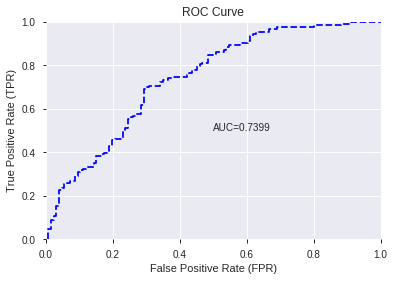

This function is available for GLM models only


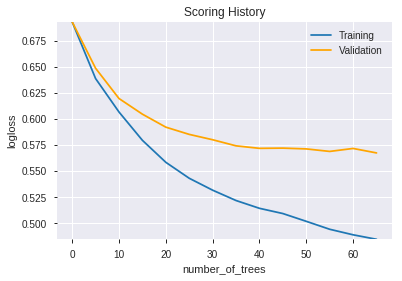

--2019-08-28 19:04:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_190325_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_190325_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_190537_model_9  0.738547  0.617399              0.337786  0.457080  0.208922
1  DeepLearning_grid_1_AutoML_20190828_190537_model_3  0.736482  0.686353              0.318235  0.461119  0.212631
2  DeepLearning_grid_1_AutoML_20190828_190537_model_6  0.735837  0.601325              0.310879  0.453117  0.205315
3  DeepLearning_grid_1_AutoML_20190828_190537_model_5  0.733966  0.612163              0.329849  0.454847  0.206886
4               DeepLearning_1_AutoML_20190828_190537  0.733062  0.629041              0.326461  0.458476  0.210200
5  DeepLearning_grid_1_AutoML_20190828_190537_model_1  0.731191  0.902051              0.319009  0.473649  0.224343
6  DeepLearning_grid_1_AutoML_20190828_190537_model_7  0.730998  0.736877              0.333720  0.491577  0.241648
7  DeepLearning_grid_1_AutoML_20190828_190537_model_8  0.730739  0.622761              0.302652  0.459126  0.210797
8  DeepLearning_grid_1_AutoML_20190828_190537_model_4  0.718286  0.835543              0.350465  0.489613  0.239721
9  DeepLearning_grid_1_AutoML_20190828_190537_model_2  0.702413  0.834496              0.365854  0.476564  0.227113

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.052358
1           CDLLONGLINE             0.887551           0.887551    0.046470
2    CDLCLOSINGMARUBOZU             0.845515           0.845515    0.044269
3           CDLBELTHOLD             0.631333           0.631333    0.033055
4                   SUB             0.514897           0.514897    0.026959
5                   DIV             0.487233           0.487233    0.025510
6             CDLHAMMER             0.436363           0.436363    0.022847
7          CDLENGULFING             0.417372           0.417372    0.021853
8            CDL3INSIDE             0.412602           0.412602    0.021603
9         CDLHANGINGMAN             0.399232           0.399232    0.020903
10               VAR_12             0.388374           0.388374    0.020334
11       CDLEVENINGSTAR             0.375130           0.375130    0.019641
12   CDLEVENINGDOJISTAR             0.360948           0.360948    0.018898
13      CDLLADDERBOTTOM             0.359192           0.359192    0.018806
14      CDLUNIQUE3RIVER             0.355831           0.355831    0.018631
15                 SINH             0.355062           0.355062    0.018590
16                  EXP             0.353929           0.353929    0.018531
17       is_month_start             0.351335           0.351335    0.018395
18            CDL2CROWS             0.351189           0.351189    0.018387
19        CDLHIKKAKEMOD             0.350072           0.350072    0.018329
20    CDLINVERTEDHAMMER             0.346910           0.346910    0.018163
21   CDLSEPARATINGLINES             0.345911           0.345911    0.018111
22            CDLONNECK             0.345409           0.345409    0.018085
23   CDLMORNINGDOJISTAR             0.343716           0.343716    0.017996
24                 COSH             0.341317           0.341317    0.017871
25            CORREL_24             0.336761           0.336761    0.017632
26    CDLSTALLEDPATTERN             0.333080           0.333080    0.017439
27         CDLTHRUSTING             0.331883           0.331883    0.017377
28     CDLDRAGONFLYDOJI             0.331608           0.331608    0.017362
29     CDLSTICKSANDWICH             0.331443           0.331443    0.017354
30          CDLPIERCING             0.330641           0.330641    0.017312
31       CDLMATCHINGLOW             0.329372           0.329372    0.017245
32  CDLGAPSIDESIDEWHITE             0.326572           0.326572    0.017099
33            CDLINNECK             0.322781           0.322781    0.016900
34       CDLMORNINGSTAR             0.322616           0.322616    0.016891
35         CDLTASUKIGAP             0.321086           0.321086    0.016811
36      CDLADVANCEBLOCK             0.315712           0.315712    0.016530
37       is_quarter_end             0.311332           0.311332    0.016301
38            CDLTAKURI             0.306566           0.306566    0.016051
39              WILLR_8             0.306504           0.306504    0.016048
40    CDLGRAVESTONEDOJI             0.302259           0.302259    0.015826
41  CDLXSIDEGAP3METHODS             0.301522           0.301522    0.015787
42         STOCHF_fastk             0.298951           0.298951    0.015652
43      CDLSHOOTINGSTAR             0.296731           0.296731    0.015536
44     is_quarter_start             0.296413           0.296413    0.015520
45    CDLDARKCLOUDCOVER             0.294970           0.294970    0.015444
46       STOCHRSI_fastk             0.294729           0.294729    0.015431
47      CDLHOMINGPIGEON             0.287395           0.287395    0.015047
48         is_month_end             0.256505           0.256505    0.013430
49         weekday_name             0.255527           0.255527    0.013379

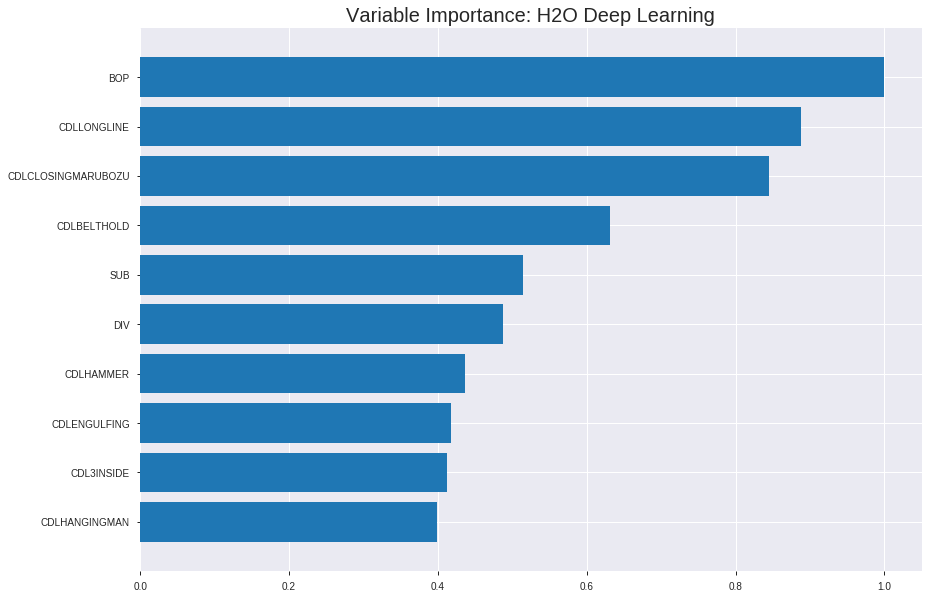

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_190537_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1820365343455302
RMSE: 0.4266573969188044
LogLoss: 0.5451601542750868
Mean Per-Class Error: 0.2707332724698659
AUC: 0.8006106193519363
pr_auc: 0.7991167450295108
Gini: 0.6012212387038727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3776733305637129: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      410  416   0.5036   (416.0/826.0)
1      91   824   0.0995   (91.0/915.0)
Total  501  1240  0.2912   (507.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377673     0.764733  274
max f2                       0.247924     0.863905  325
max f0point5                 0.547506     0.749239  194
max accuracy                 0.547506     0.727743  194
max precision                0.998231     1         0
max recall                   0.0416566    1         398
max specificity              0.998231     1         0
max absolute_mcc             0.547506     0.458234  194
max min_per_class_accuracy   0.524345     0.72276   205
max mean_per_class_accuracy  0.547506     0.729267  194

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 54.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.96628            1.69132   1.69132            0.888889         0.98006   0.888889                    0.98006             0.0174863       0.0174863                  69.1318   69.1318
    2        0.0201034                   0.957226           1.90273   1.794              1                0.961409  0.942857                    0.971001            0.0185792       0.0360656                  90.2732   79.4005
    3        0.0304423                   0.95147            1.69132   1.75913            0.888889         0.954032  0.924528                    0.965238            0.0174863       0.0535519                  69.1318   75.913
    4        0.0402068                   0.944095           1.67888   1.73964            0.882353         0.948349  0.914286                    0.961136            0.0163934       0.0699454                  67.8881   73.9641
    5        0.0505457                   0.936029           1.69132   1.72976            0.888889         0.939471  0.909091                    0.956705            0.0174863       0.0874317                  69.1318   72.9757
    6        0.100517                    0.887149           1.64029   1.68528            0.862069         0.912025  0.885714                    0.934493            0.0819672       0.169399                   64.0286   68.5277
    7        0.150488                    0.853027           1.68403   1.68486            0.885057         0.871456  0.885496                    0.913561            0.084153        0.253552                   68.4027   68.4862
    8        0.20046                     0.786509           1.57467   1.65739            0.827586         0.828304  0.87106                     0.892308            0.0786885       0.33224                    57.4675   65.7394
    9        0.300402                    0.711409           1.44345   1.58622            0.758621         0.74602   0.833652                    0.843638            0.144262        0.476503                   44.3452   58.6217
    10       0.400345                    0.636566           1.22475   1.49598            0.643678         0.675037  0.786227                    0.801548            0.122404        0.598907                   22.4747   49.5979
    11       0.500287                    0.53259            1.13727   1.42432            0.597701         0.582999  0.748565                    0.757889            0.113661        0.712568                   13.7265   42.4319
    12       0.60023                     0.479706           0.984172  1.35103            0.517241         0.503461  0.710048                    0.715525            0.0983607       0.810929                   -1.58282  35.1031
    13       0.700172                    0.389437           0.732661  1.26276            0.385057         0.437514  0.663659                    0.675841            0.073224        0.884153                   -26.7339  26.2765
    14       0.800115                    0.254675           0.66705   1.18835            0.350575         0.317871  0.624551                    0.631127            0.0666667       0.95082                    -33.295   18.8354
    15       0.900057                    0.199751           0.273381  1.08676            0.143678         0.223792  0.571155                    0.585897            0.0273224       0.978142                   -72.6619  8.67552
    16       1                           0.0284395          0.218705  1                  0.114943         0.152619  0.52556                     0.542594          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19268833625196427
RMSE: 0.4389627959770216
LogLoss: 0.5652608212605362
Mean Per-Class Error: 0.28951028593608485
AUC: 0.7735719368611722
pr_auc: 0.7901437683614028
Gini: 0.5471438737223444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3900489236454949: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  128  0.5424   (128.0/236.0)
1      26   236  0.0992   (26.0/262.0)
Total  134  364  0.3092   (154.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390049     0.753994  287
max f2                       0.223602     0.856372  346
max f0point5                 0.563649     0.73181   185
max accuracy                 0.500268     0.712851  218
max precision                0.992593     1         0
max recall                   0.068598     1         394
max specificity              0.992593     1         0
max absolute_mcc             0.500268     0.423089  218
max min_per_class_accuracy   0.512209     0.694915  205
max mean_per_class_accuracy  0.500268     0.71049   218

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 54.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.981246           1.90076   1.90076            1                0.988412  1                           0.988412            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.967106           1.90076   1.90076            1                0.977621  1                           0.983017            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.95681            1.90076   1.90076            1                0.961393  1                           0.975809            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.951148           1.90076   1.90076            1                0.953485  1                           0.970228            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.945009           1.52061   1.82473            0.8              0.950064  0.96                        0.966195            0.0152672       0.0916031                  52.0611   82.4733
    6        0.100402                    0.892346           1.67267   1.7487             0.88             0.919471  0.92                        0.942833            0.0839695       0.175573                   67.2672   74.8702
    7        0.150602                    0.845766           1.59664   1.69802            0.84             0.873171  0.893333                    0.919612            0.0801527       0.255725                   59.6641   69.8015
    8        0.200803                    0.785813           1.44458   1.63466            0.76             0.817366  0.86                        0.894051            0.0725191       0.328244                   44.458    63.4656
    9        0.301205                    0.713082           1.29252   1.52061            0.68             0.743584  0.8                         0.843895            0.129771        0.458015                   29.2519   52.0611
    10       0.399598                    0.644137           1.28011   1.46139            0.673469         0.680371  0.768844                    0.803631            0.125954        0.583969                   28.0106   46.1391
    11       0.5                         0.518426           1.02641   1.37405            0.54             0.574825  0.722892                    0.757686            0.103053        0.687023                   2.64122   37.4046
    12       0.600402                    0.481284           0.836336  1.28413            0.44             0.500793  0.675585                    0.714727            0.0839695       0.770992                   -16.3664  28.4128
    13       0.698795                    0.422576           0.930986  1.2344             0.489796         0.45564   0.649425                    0.678246            0.0916031       0.862595                   -6.90139  23.4404
    14       0.799197                    0.262719           0.684275  1.16529            0.36             0.351523  0.613065                    0.637201            0.0687023       0.931298                   -31.5725  16.5292
    15       0.899598                    0.203701           0.418168  1.08191            0.22             0.23362   0.569196                    0.592158            0.0419847       0.973282                   -58.1832  8.19077
    16       1                           0.0149924          0.266107  1                  0.14             0.149804  0.526104                    0.547745         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:13:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:13:08  2 min 52.957 sec  487 obs/sec       0.477312  1             831        0.64238          1.88616             -0.654932      0.766885        0.775109           1.90273          0.318782                         0.644015           1.89686               -0.663553        0.754917          0.756635             1.90076            0.321285
    2019-08-28 19:13:19  3 min  3.428 sec  761 obs/sec       4.88742   10            8509       0.432888         0.557528            0.248469       0.793228        0.796852           1.90273          0.313038                         0.440735           0.572384              0.220887         0.775141          0.789031             1.90076            0.309237
    2019-08-28 19:13:30  3 min 14.115 sec  895 obs/sec       10.741    22            18700      0.430205         0.550098            0.257756       0.796135        0.798441           1.79702          0.298679                         0.441647           0.574719              0.21766          0.774858          0.792957             1.90076            0.323293
    2019-08-28 19:13:40  3 min 24.281 sec  987 obs/sec       17.0299   35            29649      0.438758         0.569419            0.227947       0.796196        0.799141           1.79702          0.298105                         0.448785           0.591994              0.192165         0.769262          0.790668             1.90076            0.323293
    2019-08-28 19:13:50  3 min 34.876 sec  1067 obs/sec      24.3142   50            42331      0.428707         0.548606            0.262915       0.800352        0.802086           1.79702          0.296381                         0.439892           0.569111              0.223863         0.777114          0.792117             1.90076            0.311245
    2019-08-28 19:14:00  3 min 45.037 sec  1132 obs/sec      31.7513   65            55279      0.430516         0.552755            0.256683       0.801823        0.802534           1.79702          0.294658                         0.440263           0.572079              0.222554         0.776718          0.795052             1.90076            0.311245
    2019-08-28 19:14:11  3 min 55.301 sec  1185 obs/sec      39.537    81            68834      0.426657         0.54516             0.269946       0.800611        0.799117           1.69132          0.291212                         0.438963           0.565261              0.22714          0.773572          0.790144             1.90076            0.309237

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.05235771246123072
CDLLONGLINE         0.8875511288642883     0.8875511288642883   0.046470146799717144
CDLCLOSINGMARUBOZU  0.8455153703689575     0.8455153703689575   0.04426925064332888
CDLBELTHOLD         0.6313332915306091     0.6313332915306091   0.03305516694516198
SUB                 0.514897346496582      0.514897346496582    0.026958847214918726
---                 ---                    ---                  ---
CDLDARKCLOUDCOVER   0.2949697971343994     0.2949697971343994   0.015443943823110443
STOCHRSI_fastk      0.2947293817996979     0.2947293817996979   0.015431356226144869
CDLHOMINGPIGEON     0.28739485144615173    0.28739485144615173  0.015047336994855732
is_month_end        0.2565050721168518     0.2565050721168518   0.013430018810741377
weekday_name        0.2555265724658966     0.2555265724658966   0.01337878680737325


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.735202492211838)

('auc', 0.7385469092786167)

('logloss', 0.6173993285679356)

('mean_per_class_error', 0.3046844754161827)

('rmse', 0.45708028569883696)

('mse', 0.20892238757453044)

deeplearning prediction progress: |███████████████████████████████████████| 100%


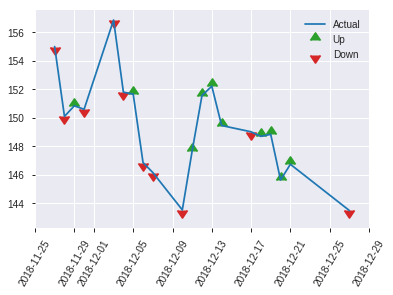


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20892238757453044
RMSE: 0.45708028569883696
LogLoss: 0.6173993285679356
Mean Per-Class Error: 0.3046844754161827
AUC: 0.7385469092786167
pr_auc: 0.6763312224998037
Gini: 0.4770938185572333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.275026546612526: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   80   0.6349   (80.0/126.0)
1      5    118  0.0407   (5.0/123.0)
Total  51   198  0.3414   (85.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275027     0.735202  197
max f2                       0.275027     0.855072  197
max f0point5                 0.506475     0.688226  119
max accuracy                 0.484742     0.694779  134
max precision                0.822619     0.8125    31
max recall                   0.0683076    1         248
max specificity              0.963601     0.992063  0
max absolute_mcc             0.275027     0.40192   197
max min_per_class_accuracy   0.504364     0.682927  122
max mean_per_class_accuracy  0.484742     0.695316  134

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.956162           0.674797   0.674797           0.333333         0.959226  0.333333                    0.959226            0.00813008      0.00813008                 -32.5203  -32.5203
    2        0.0200803                   0.952849           1.0122     0.809756           0.5              0.954301  0.4                         0.957256            0.00813008      0.0162602                  1.21951   -19.0244
    3        0.0321285                   0.930064           2.02439    1.26524            1                0.945985  0.625                       0.953029            0.0243902       0.0406504                  102.439   26.5244
    4        0.0401606                   0.89491            2.02439    1.41707            1                0.919231  0.7                         0.94627             0.0162602       0.0569106                  102.439   41.7073
    5        0.0522088                   0.88828            1.34959    1.4015             0.666667         0.890609  0.692308                    0.933425            0.0162602       0.0731707                  34.9593   40.1501
    6        0.100402                    0.837784           1.68699    1.53854            0.833333         0.866914  0.76                        0.9015              0.0813008       0.154472                   68.6992   53.8537
    7        0.15261                     0.786791           1.71295    1.5982             0.846154         0.814819  0.789474                    0.871846            0.0894309       0.243902                   71.2946   59.8203
    8        0.200803                    0.723724           1.18089    1.49805            0.583333         0.747156  0.74                        0.84192             0.0569106       0.300813                   18.0894   49.8049
    9        0.301205                    0.660023           1.29561    1.43057            0.64             0.692586  0.706667                    0.792142            0.130081        0.430894                   29.561    43.0569
    10       0.401606                    0.57987            1.21463    1.37659            0.6              0.624216  0.68                        0.750161            0.121951        0.552846                   21.4634   37.6585
    11       0.502008                    0.500231           1.37659    1.37659            0.68             0.530097  0.68                        0.706148            0.138211        0.691057                   37.6585   37.6585
    12       0.598394                    0.45317            0.927846   1.30431            0.458333         0.479422  0.644295                    0.669628            0.0894309       0.780488                   -7.21545  30.4305
    13       0.698795                    0.394936           0.809756   1.23325            0.4              0.429834  0.609195                    0.635175            0.0813008       0.861789                   -19.0244  23.3249
    14       0.799197                    0.263246           0.971707   1.20039            0.48             0.332018  0.592965                    0.59709             0.097561        0.95935                    -2.82927  20.0392
    15       0.899598                    0.20081            0.0809756  1.07546            0.04             0.225194  0.53125                     0.555584            0.00813008      0.96748                    -91.9024  7.54573
    16       1                           0.0683076          0.323902   1                  0.16             0.161628  0.493976                 

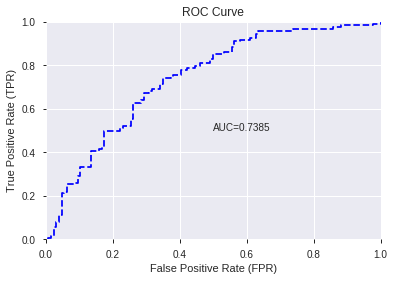

This function is available for GLM models only


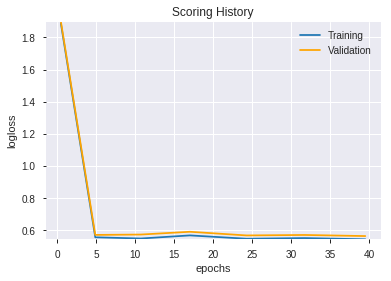

--2019-08-28 19:14:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_190537_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_190537_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'SUB',
 'DIV',
 'CDLHAMMER',
 'CDLENGULFING',
 'CDL3INSIDE',
 'CDLHANGINGMAN',
 'VAR_12',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLUNIQUE3RIVER',
 'SINH',
 'EXP',
 'is_month_start',
 'CDL2CROWS',
 'CDLHIKKAKEMOD',
 'CDLINVERTEDHAMMER',
 'CDLSEPARATINGLINES',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'COSH',
 'CORREL_24',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLDRAGONFLYDOJI',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLTASUKIGAP',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLTAKURI',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'CDLXSIDEGAP3METHODS',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'is_quarter_start',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'weekday_name']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_191519_model_1  0.731965  0.612425              0.318719  0.457567  0.209368

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.776889           1.000000    0.189686
1             CDLHAMMER             0.211097           0.271720    0.051542
2                   SUB             0.203967           0.262543    0.049801
3           CDLLONGLINE             0.193029           0.248464    0.047130
4          STOCHF_fastk             0.161922           0.208423    0.039535
5                   DIV             0.154727           0.199163    0.037778
6             CDLONNECK             0.153470           0.197545    0.037471
7    CDLCLOSINGMARUBOZU             0.150686           0.193961    0.036792
8          CDLTASUKIGAP             0.132796           0.170933    0.032424
9         CDLHIKKAKEMOD             0.131704           0.169527    0.032157
10               VAR_12             0.116726           0.150248    0.028500
11        CDLHANGINGMAN             0.112108           0.144304    0.027372
12      CDLUNIQUE3RIVER             0.111844           0.143964    0.027308
13          CDLPIERCING             0.106810           0.137484    0.026079
14      CDLLADDERBOTTOM             0.096086           0.123680    0.023460
15              WILLR_8             0.095169           0.122500    0.023237
16           CDL3INSIDE             0.078206           0.100665    0.019095
17            CORREL_24             0.077719           0.100039    0.018976
18      CDLSHOOTINGSTAR             0.072706           0.093586    0.017752
19   CDLEVENINGDOJISTAR             0.072535           0.093366    0.017710
20  CDLGAPSIDESIDEWHITE             0.069972           0.090067    0.017084
21   CDLSEPARATINGLINES             0.066321           0.085367    0.016193
22            CDLINNECK             0.064994           0.083659    0.015869
23     is_quarter_start             0.064385           0.082876    0.015720
24         weekday_name             0.059460           0.076536    0.014518
25       is_quarter_end             0.057777           0.074370    0.014107
26         CDLENGULFING             0.057565           0.074096    0.014055
27       CDLMATCHINGLOW             0.056753           0.073052    0.013857
28       is_month_start             0.041501           0.053420    0.010133
29            CDL2CROWS             0.040068           0.051575    0.009783
30    CDLDARKCLOUDCOVER             0.039123           0.050359    0.009552
31    CDLSTALLEDPATTERN             0.034780           0.044768    0.008492
32       CDLMORNINGSTAR             0.033420           0.043017    0.008160
33     CDLDRAGONFLYDOJI             0.027599           0.035525    0.006739
34       CDLEVENINGSTAR             0.027034           0.034798    0.006601
35   CDLMORNINGDOJISTAR             0.026051           0.033533    0.006361
36  CDLXSIDEGAP3METHODS             0.023086           0.029715    0.005637
37       STOCHRSI_fastk             0.023071           0.029696    0.005633
38      CDLHOMINGPIGEON             0.021046           0.027091    0.005139
39          CDLBELTHOLD             0.018969           0.024416    0.004631
40         CDLTHRUSTING             0.008550           0.011006    0.002088
41      CDLADVANCEBLOCK             0.004590           0.005909    0.001121
42         is_month_end             0.003818           0.004914    0.000932
43                 COSH             0.002972           0.003826    0.000726
44                 SINH             0.002890           0.003720    0.000706
45                  EXP             0.002878           0.003704    0.000703
46            CDLTAKURI             0.002809           0.003615    0.000686
47    CDLINVERTEDHAMMER             0.001724           0.002219    0.000421
48    CDLGRAVESTONEDOJI             0.001230           0.001583    0.000300
49     CDLSTICKSANDWICH             0.001030           0.001325    0.000251

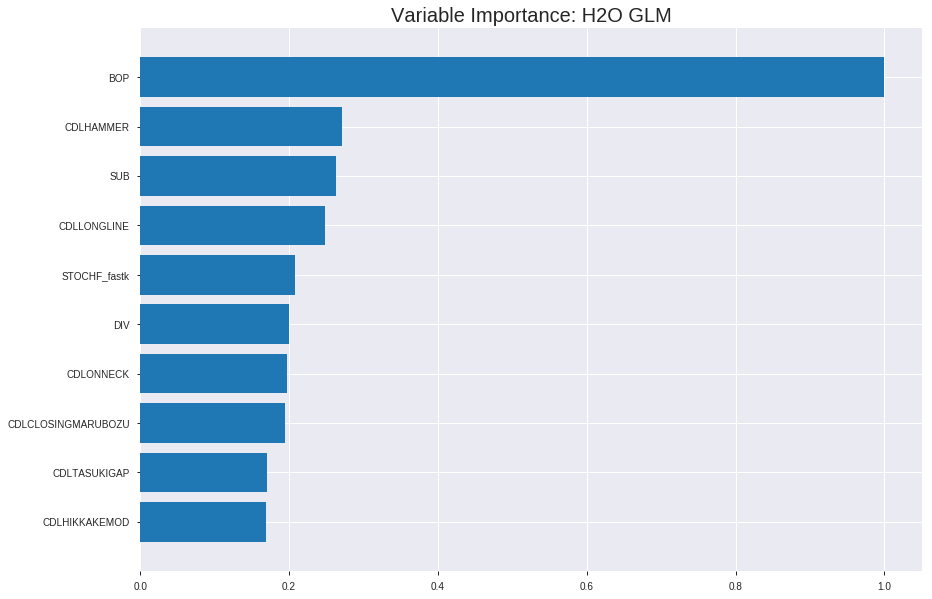

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_191519_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18086826445632123
RMSE: 0.42528609718202787
LogLoss: 0.5372961172246098
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2408.986814961971
Residual deviance: 1870.8650801760914
AIC: 1972.8650801760914
AUC: 0.802723640164596
pr_auc: 0.8132553016395921
Gini: 0.6054472803291919
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33341261186041243: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      379  447   0.5412   (447.0/826.0)
1      78   837   0.0852   (78.0/915.0)
Total  457  1284  0.3016   (525.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333413     0.761255  279
max f2                       0.247663     0.864064  316
max f0point5                 0.57724      0.74659   176
max accuracy                 0.489446     0.730615  215
max precision                0.992232     1         0
max recall                   0.0720274    1         383
max specificity              0.992232     1         0
max absolute_mcc             0.477297     0.459516  220
max min_per_class_accuracy   0.545176     0.723971  191
max mean_per_class_accuracy  0.489446     0.727642  215

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.942686           1.90273   1.90273            1                0.964857  1                           0.964857            0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.924629           1.90273   1.90273            1                0.931836  1                           0.948818            0.0185792       0.0382514                  90.2732   90.2732
    3        0.0304423                   0.916129           1.90273   1.90273            1                0.919413  1                           0.938831            0.0196721       0.0579235                  90.2732   90.2732
    4        0.0402068                   0.90251            1.56696   1.82119            0.823529         0.909215  0.957143                    0.931639            0.0153005       0.073224                   56.6956   82.1187
    5        0.0505457                   0.892326           1.79702   1.81624            0.944444         0.897197  0.954545                    0.924594            0.0185792       0.0918033                  79.7025   81.6244
    6        0.100517                    0.844647           1.7059    1.76139            0.896552         0.865154  0.925714                    0.895044            0.0852459       0.177049                   70.5898   76.1386
    7        0.150488                    0.803595           1.5528    1.69212            0.816092         0.823564  0.889313                    0.871308            0.0775956       0.254645                   55.2804   69.2124
    8        0.20046                     0.769791           1.64029   1.6792             0.862069         0.787098  0.882521                    0.850316            0.0819672       0.336612                   64.0286   67.9202
    9        0.300402                    0.698953           1.41065   1.58985            0.741379         0.732383  0.835564                    0.81108             0.140984        0.477596                   41.0646   58.9855
    10       0.400345                    0.629146           1.17007   1.48506            0.614943         0.663937  0.780488                    0.774347            0.11694         0.594536                   17.0071   48.5059
    11       0.500287                    0.55309            1.18101   1.42432            0.62069          0.590828  0.748565                    0.737685            0.118033        0.712568                   18.1006   42.4319
    12       0.60023                     0.459421           0.951366  1.34557            0.5              0.507235  0.707177                    0.699314            0.095082        0.80765                    -4.86339  34.5569
    13       0.700172                    0.3636             0.787337  1.26589            0.413793         0.409253  0.665299                    0.657911            0.0786885       0.886339                   -21.2663  26.5887
    14       0.800115                    0.271416           0.623309  1.18562            0.327586         0.319985  0.623116                    0.6157              0.0622951       0.948634                   -37.6691  18.5622
    15       0.900057                    0.168903           0.317122  1.08918            0.166667         0.222501  0.572431                    0.572039            0.031694        0.980328                   -68.2878  8.91837
    16       1                           0.00591905         0.196834  1                  0.103448         0.106978  0.52556                     0.52556          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18780073306183045
RMSE: 0.433359819390112
LogLoss: 0.5530174276690482
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.0171367028406
Residual deviance: 550.8053579583719
AIC: 652.8053579583719
AUC: 0.7867528140768534
pr_auc: 0.802295203296524
Gini: 0.5735056281537068
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2970020726173405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      87   149  0.6314   (149.0/236.0)
1      14   248  0.0534   (14.0/262.0)
Total  101  397  0.3273   (163.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297002     0.752656  311
max f2                       0.199542     0.868984  354
max f0point5                 0.649014     0.736739  146
max accuracy                 0.537716     0.716867  192
max precision                0.995157     1         0
max recall                   0.0391233    1         396
max specificity              0.995157     1         0
max absolute_mcc             0.537716     0.434761  192
max min_per_class_accuracy   0.532369     0.709924  196
max mean_per_class_accuracy  0.537716     0.71767   192

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.985603           1.90076    1.90076            1                0.990414  1                           0.990414            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.947365           1.52061    1.71069            0.8              0.968639  0.9                         0.979526            0.0152672       0.0343511                  52.0611   71.0687
    3        0.0301205                   0.930599           1.90076    1.77405            1                0.939096  0.933333                    0.96605             0.019084        0.0534351                  90.0763   77.4046
    4        0.0401606                   0.919561           1.90076    1.80573            1                0.925303  0.95                        0.955863            0.019084        0.0725191                  90.0763   80.5725
    5        0.0502008                   0.909033           1.52061    1.7487             0.8              0.916552  0.92                        0.948001            0.0152672       0.0877863                  52.0611   74.8702
    6        0.100402                    0.871227           1.82473    1.78672            0.96             0.887893  0.94                        0.917947            0.0916031       0.179389                   82.4733   78.6718
    7        0.150602                    0.825793           1.59664    1.72336            0.84             0.848026  0.906667                    0.89464             0.0801527       0.259542                   59.6641   72.3359
    8        0.200803                    0.770072           1.59664    1.69168            0.84             0.803868  0.89                        0.871947            0.0801527       0.339695                   59.6641   69.1679
    9        0.301205                    0.70318            1.36855    1.58397            0.72             0.737365  0.833333                    0.827086            0.137405        0.477099                   36.855    58.3969
    10       0.399598                    0.623246           1.16373    1.48049            0.612245         0.668577  0.778894                    0.788056            0.114504        0.591603                   16.3733   48.0494
    11       0.5                         0.535436           1.10244    1.40458            0.58             0.574761  0.738956                    0.745226            0.110687        0.70229                    10.2443   40.458
    12       0.600402                    0.463304           0.874351   1.31591            0.46             0.500314  0.692308                    0.704271            0.0877863       0.790076                   -12.5649  31.5913
    13       0.698795                    0.372055           0.737031   1.2344             0.387755         0.420358  0.649425                    0.664294            0.0725191       0.862595                   -26.2969  23.4404
    14       0.799197                    0.295587           0.836336   1.1844             0.44             0.34115   0.623116                    0.623698            0.0839695       0.946565                   -16.3664  18.4395
    15       0.899598                    0.199394           0.456183   1.10312            0.24             0.243856  0.580357                    0.581305            0.0458015       0.992366                   -54.3817  10.3122
    16       1                           0.0113983          0.0760305  1                  0.04             0.122769  0.526104                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:15:19  0.000 sec   2            .24E2     51            1.3665995788132843  1.3668505755379152
     2019-08-28 19:15:19  0.009 sec   4            .15E2     51            1.3571587405497127  1.3576117028554475
     2019-08-28 19:15:19  0.018 sec   6            .93E1     51            1.3433075883936425  1.3440646443865825
     2019-08-28 19:15:19  0.028 sec   8            .58E1     51            1.3239023390150804  1.3250910404434288
     2019-08-28 19:15:19  0.037 sec   10           .36E1     51            1.2985401490669077  1.3003323902149326
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:15:19  0.127 sec   34           .12E-1    51            1.0719404666924612  1.107381077125152
     2019-08-28 19:15:19  0.135 sec   36           .73E-2    51            1.0703944977801503  1.1096574128550984
     2019-08-28 19:15:19  0.142 sec   38           .45E-2    51            1.069522663395749   1.1124318725654536
     2019-08-28 19:15:19  0.151 sec   40           .28E-2    51            1.0690344511407455  1.115444347250516
     2019-08-28 19:15:19  0.156 sec   41           .18E-2    51            1.0687756177078684  1.1181732521438745


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.7333333333333334)

('auc', 0.7319654148922442)

('logloss', 0.6124254343464994)

('mean_per_class_error', 0.3088463027487418)

('rmse', 0.4575674799849286)

('mse', 0.20936799873975803)

glm prediction progress: |████████████████████████████████████████████████| 100%


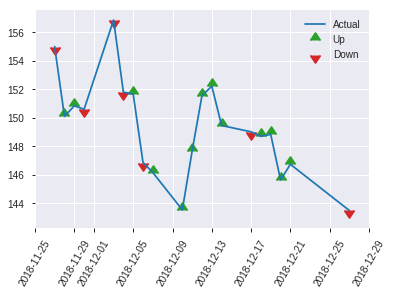


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20936799873975803
RMSE: 0.4575674799849286
LogLoss: 0.6124254343464994
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 346.14583701949294
Residual deviance: 304.98786630455663
AIC: 406.98786630455663
AUC: 0.7319654148922442
pr_auc: 0.6899147878670765
Gini: 0.4639308297844884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3467424563782642: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   67   0.5317   (67.0/126.0)
1      13   110  0.1057   (13.0/123.0)
Total  72   177  0.3213   (80.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346742     0.733333  176
max f2                       0.200303     0.849858  213
max f0point5                 0.472971     0.683564  131
max accuracy                 0.472971     0.690763  131
max precision                0.843065     0.866667  14
max recall                   0.0410167    1         248
max specificity              0.972173     0.992063  0
max absolute_mcc             0.346742     0.399824  176
max min_per_class_accuracy   0.502534     0.666667  123
max mean_per_class_accuracy  0.472971     0.691154  131

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 49.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.929939           1.34959   1.34959            0.666667         0.947342  0.666667                    0.947342            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.921485           1.0122    1.21463            0.5              0.926373  0.6                         0.938954            0.00813008      0.0243902                  1.21951   21.4634
    3        0.0321285                   0.889474           2.02439   1.51829            1                0.908971  0.75                        0.927711            0.0243902       0.0487805                  102.439   51.8293
    4        0.0401606                   0.869172           2.02439   1.61951            1                0.880933  0.8                         0.918355            0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.852612           2.02439   1.71295            1                0.861388  0.846154                    0.905209            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.7972             1.51829   1.61951            0.75             0.818333  0.8                         0.863509            0.0731707       0.162602                   51.8293   61.9512
    7        0.15261                     0.740741           1.71295   1.65148            0.846154         0.769722  0.815789                    0.831424            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.705026           1.34959   1.57902            0.666667         0.72346   0.78                        0.805512            0.0650407       0.317073                   34.9593   57.9024
    9        0.301205                    0.649188           0.890732  1.34959            0.44             0.671234  0.666667                    0.760753            0.0894309       0.406504                   -10.9268  34.9593
    10       0.401606                    0.579448           1.37659   1.35634            0.68             0.61645   0.67                        0.724677            0.138211        0.544715                   37.6585   35.6341
    11       0.502008                    0.499096           1.29561   1.3442             0.64             0.536232  0.664                       0.686988            0.130081        0.674797                   29.561    34.4195
    12       0.598394                    0.407893           0.843496  1.26355            0.416667         0.449875  0.624161                    0.648796            0.0813008       0.756098                   -15.6504  26.3546
    13       0.698795                    0.353068           1.13366   1.24488            0.56             0.385042  0.614943                    0.6109              0.113821        0.869919                   13.3659   24.4884
    14       0.799197                    0.273518           0.72878   1.18005            0.36             0.313443  0.582915                    0.573531            0.0731707       0.943089                   -27.122   18.0047
    15       0.899598                    0.178904           0.404878  1.09353            0.2              0.216035  0.540179                    0.533632            0.0406504       0.98374                    -59.5122  9.35322
    16       1                           0.0410167          0.161951  1                  0.08             0.123697  0.493976                    0.492474         

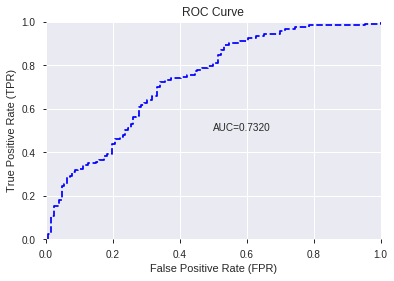

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


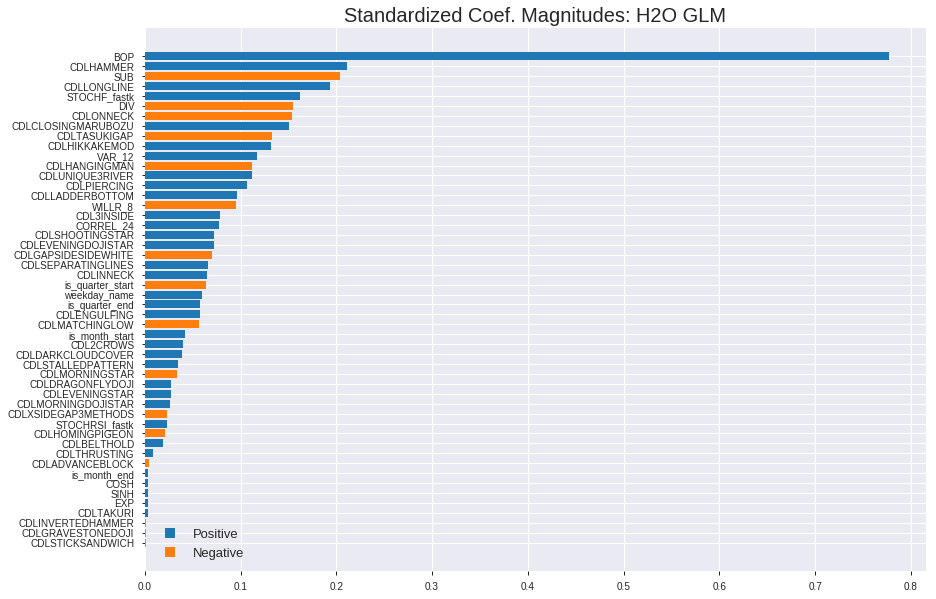

'log_likelihood'
--2019-08-28 19:15:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_191519_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_191519_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLHAMMER',
 'SUB',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'DIV',
 'CDLONNECK',
 'CDLCLOSINGMARUBOZU',
 'CDLTASUKIGAP',
 'CDLHIKKAKEMOD',
 'VAR_12',
 'CDLHANGINGMAN',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'WILLR_8',
 'CDL3INSIDE',
 'CORREL_24',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDLINNECK',
 'is_quarter_start',
 'weekday_name',
 'is_quarter_end',
 'CDLENGULFING',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDL2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'CDLBELTHOLD',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'is_month_end',
 'COSH',
 'SINH',
 'EXP',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLSTICKSANDWICH']

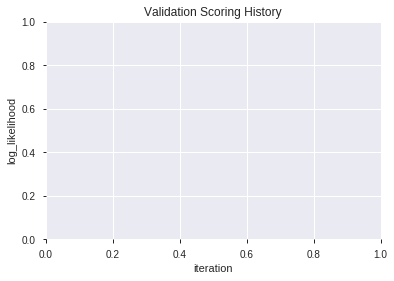

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_191626_model_4  0.742870  0.593479              0.345819  0.452436  0.204699
1  XGBoost_grid_1_AutoML_20190828_191626_model_6  0.742031  0.595803              0.322396  0.452704  0.204941
2  XGBoost_grid_1_AutoML_20190828_191626_model_7  0.740741  0.599044              0.322784  0.453419  0.205589
3  XGBoost_grid_1_AutoML_20190828_191626_model_3  0.740289  0.597652              0.326171  0.452238  0.204519
4  XGBoost_grid_1_AutoML_20190828_191626_model_2  0.734998  0.600432              0.306233  0.455133  0.207146
5               XGBoost_2_AutoML_20190828_191626  0.730417  0.607071              0.322784  0.457939  0.209708
6               XGBoost_3_AutoML_20190828_191626  0.728481  0.606721              0.322396  0.457026  0.208873
7               XGBoost_1_AutoML_20190828_191626  0.724739  0.608233              0.322590  0.458992  0.210674
8  XGBoost_grid_1_AutoML_20190828_191626_model_1  0.723448  0.612292              0.322203  0.459190  0.210855
9  XGBoost_grid_1_AutoML_20190828_191626_model_5  0.695186  0.642921              0.330527  0.473276  0.223990

variable  relative_importance  scaled_importance  percentage
0                  BOP          3227.393799           1.000000    0.637945
1                  SUB           349.627502           0.108331    0.069109
2                  DIV           318.996307           0.098840    0.063055
3         STOCHF_fastk           291.832214           0.090423    0.057685
4               VAR_12           235.897476           0.073092    0.046629
5              WILLR_8           210.014450           0.065072    0.041513
6                 COSH           127.919022           0.039635    0.025285
7            CORREL_24           124.841606           0.038682    0.024677
8         weekday_name            74.006607           0.022931    0.014629
9       STOCHRSI_fastk            71.542877           0.022167    0.014142
10         CDLLONGLINE            17.139202           0.005311    0.003388
11  CDLCLOSINGMARUBOZU             9.834364           0.003047    0.001944

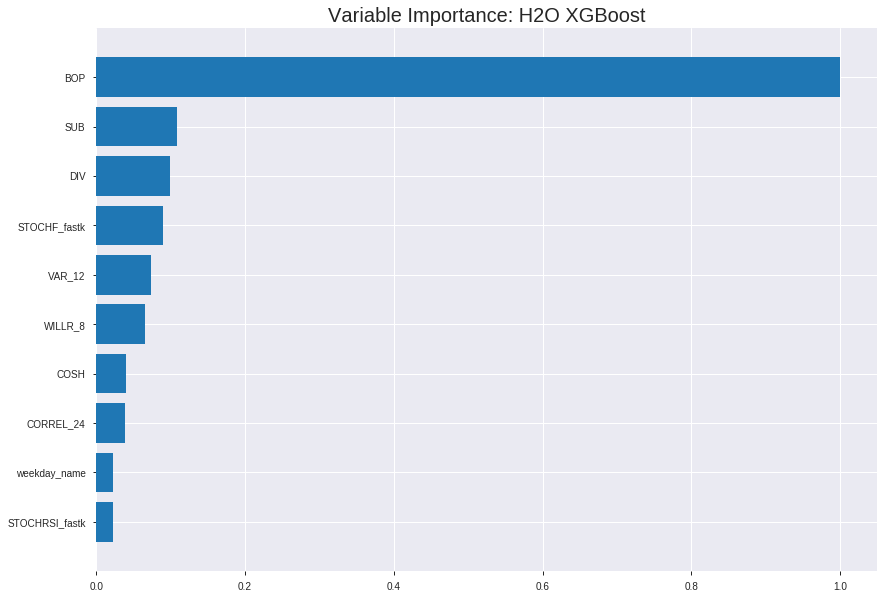

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_191626_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17069250914365805
RMSE: 0.41314949974997917
LogLoss: 0.5165382512827983
Mean Per-Class Error: 0.24457918204792328
AUC: 0.8278761296127232
pr_auc: 0.8254620873099918
Gini: 0.6557522592254463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38968729972839355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      467  359   0.4346   (359.0/826.0)
1      98   817   0.1071   (98.0/915.0)
Total  565  1176  0.2625   (457.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389687     0.781444  258
max f2                       0.188604     0.87225   346
max f0point5                 0.579876     0.774878  170
max accuracy                 0.568644     0.754739  177
max precision                0.884447     1         0
max recall                   0.0979221    1         391
max specificity              0.884447     1         0
max absolute_mcc             0.568644     0.510174  177
max min_per_class_accuracy   0.55911      0.751913  182
max mean_per_class_accuracy  0.568644     0.755421  177

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.871336           1.69132    1.69132            0.888889         0.875473  0.888889                    0.875473            0.0174863       0.0174863                  69.1318   69.1318
    2        0.0201034                   0.865057           1.90273    1.794              1                0.868078  0.942857                    0.871881            0.0185792       0.0360656                  90.2732   79.4005
    3        0.0304423                   0.861024           1.79702    1.79503            0.944444         0.862897  0.943396                    0.86883             0.0185792       0.0546448                  79.7025   79.503
    4        0.0402068                   0.855236           1.79081    1.794              0.941176         0.857907  0.942857                    0.866177            0.0174863       0.0721311                  79.0807   79.4005
    5        0.0505457                   0.850782           1.90273    1.81624            1                0.853779  0.954545                    0.863641            0.0196721       0.0918033                  90.2732   81.6244
    6        0.100517                    0.819634           1.66216    1.73964            0.873563         0.835262  0.914286                    0.849533            0.0830601       0.174863                   66.2157   73.9641
    7        0.150488                    0.789557           1.7059     1.72844            0.896552         0.80521   0.908397                    0.834815            0.0852459       0.260109                   70.5898   72.8436
    8        0.20046                     0.764706           1.50906    1.67375            0.793103         0.777143  0.879656                    0.820438            0.0754098       0.335519                   50.9064   67.375
    9        0.300402                    0.703193           1.53093    1.62624            0.804598         0.734583  0.854685                    0.791874            0.153005        0.488525                   53.0934   62.6236
    10       0.400345                    0.643138           1.32316    1.55058            0.695402         0.674587  0.814921                    0.762594            0.13224         0.620765                   32.3164   55.0577
    11       0.500287                    0.566912           1.22475    1.48549            0.643678         0.607468  0.780712                    0.731605            0.122404        0.743169                   22.4747   48.5486
    12       0.60023                     0.471066           0.874819   1.38381            0.45977          0.521449  0.727273                    0.696612            0.0874317       0.830601                   -12.5181  38.3805
    13       0.700172                    0.357976           0.721726   1.2893             0.37931          0.416317  0.677605                    0.656603            0.0721311       0.902732                   -27.8274  28.93
    14       0.800115                    0.260045           0.513956   1.19245            0.270115         0.312904  0.626705                    0.613671            0.0513661       0.954098                   -48.6044  19.2452
    15       0.900057                    0.156699           0.360863   1.10011            0.189655         0.2136    0.578175                    0.569247            0.0360656       0.990164                   -63.9137  10.0112
    16       1                           0.0833176          0.0984172  1                  0.0517241        0.118763  0.52556                     0.5



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19521205318884075
RMSE: 0.4418280810324766
LogLoss: 0.5709240514763235
Mean Per-Class Error: 0.28381744080734894
AUC: 0.7727956397981628
pr_auc: 0.7875145708804241
Gini: 0.5455912795963256
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29418623447418213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      85   151  0.6398   (151.0/236.0)
1      16   246  0.0611   (16.0/262.0)
Total  101  397  0.3353   (167.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294186     0.746586  316
max f2                       0.233124     0.870881  347
max f0point5                 0.587207     0.735772  187
max accuracy                 0.587207     0.714859  187
max precision                0.882721     1         0
max recall                   0.123622     1         385
max specificity              0.882721     1         0
max absolute_mcc             0.587207     0.431946  187
max min_per_class_accuracy   0.566475     0.709924  194
max mean_per_class_accuracy  0.587207     0.716183  187

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 54.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.87146            1.90076   1.90076            1                0.878116  1                           0.878116            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.866121           1.90076   1.90076            1                0.868394  1                           0.873255            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.861638           1.90076   1.90076            1                0.864718  1                           0.870409            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.85942            1.90076   1.90076            1                0.86106   1                           0.868072            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.855643           1.52061   1.82473            0.8              0.857885  0.96                        0.866035            0.0152672       0.0916031                  52.0611   82.4733
    6        0.100402                    0.825418           1.67267   1.7487             0.88             0.84195   0.92                        0.853992            0.0839695       0.175573                   67.2672   74.8702
    7        0.150602                    0.798064           1.44458   1.64733            0.76             0.810051  0.866667                    0.839345            0.0725191       0.248092                   44.458    64.7328
    8        0.200803                    0.769326           1.59664   1.63466            0.84             0.783555  0.86                        0.825398            0.0801527       0.328244                   59.6641   63.4656
    9        0.301205                    0.708984           1.40656   1.55863            0.74             0.741161  0.82                        0.797319            0.141221        0.469466                   40.6565   55.8626
    10       0.399598                    0.6592             0.969777  1.41363            0.510204         0.684194  0.743719                    0.769464            0.0954198       0.564885                   -3.02228  41.3633
    11       0.5                         0.571904           1.33053   1.39695            0.7              0.623279  0.73494                     0.740109            0.133588        0.698473                   33.0534   39.6947
    12       0.600402                    0.511741           0.64626   1.27141            0.34             0.54078   0.668896                    0.706777            0.0648855       0.763359                   -35.374   27.1414
    13       0.698795                    0.443086           0.892195  1.21802            0.469388         0.47416   0.640805                    0.674023            0.0877863       0.851145                   -10.7805  21.8018
    14       0.799197                    0.291508           0.874351  1.17484            0.46             0.371024  0.61809                     0.635958            0.0877863       0.938931                   -12.5649  17.4844
    15       0.899598                    0.213936           0.494198  1.09888            0.26             0.250233  0.578125                    0.592908            0.0496183       0.98855                    -50.5802  9.88788
    16       1                           0.0849741          0.114046  1                  0.06             0.143929  0.526104                    0.54783          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:16:35  2.991 sec   0                  0.5              0.693147            0.5             0                  1                0.47444                          0.5                0.693147              0.5               0                    1                  0.473896
    2019-08-28 19:16:35  3.069 sec   5                  0.47293          0.640071            0.801273        0.744573           1.74417          0.299828                         0.476277           0.646469              0.770467          0.738402             1.66317            0.343373
    2019-08-28 19:16:35  3.110 sec   10                 0.454631         0.604574            0.807926        0.789471           1.80259          0.284319                         0.461803           0.618003              0.774292          0.774411             1.90076            0.339357
    2019-08-28 19:16:35  3.168 sec   15                 0.442752         0.581025            0.811312        0.809815           1.80259          0.272832                         0.453069           0.600232              0.776693          0.792661             1.90076            0.333333
    2019-08-28 19:16:35  3.233 sec   20                 0.434323         0.563661            0.813447        0.810748           1.80259          0.278001                         0.447617           0.588398              0.775747          0.789279             1.90076            0.339357
    2019-08-28 19:16:35  3.305 sec   25                 0.428792         0.55184             0.814802        0.81188            1.79702          0.261918                         0.444619           0.581396              0.774995          0.785056             1.90076            0.337349
    2019-08-28 19:16:35  3.360 sec   30                 0.425291         0.544005            0.816147        0.809611           1.69132          0.26077                          0.442921           0.57691               0.776305          0.788574             1.90076            0.345382
    2019-08-28 19:16:35  3.413 sec   35                 0.422471         0.537432            0.81723         0.813679           1.69132          0.261344                         0.442308           0.574697              0.774656          0.786625             1.90076            0.329317
    2019-08-28 19:16:35  3.465 sec   40                 0.420406         0.53255             0.818557        0.816198           1.79702          0.268811                         0.441208           0.57185               0.775149          0.78378              1.90076            0.349398
    2019-08-28 19:16:35  3.528 sec   45                 0.418081         0.527388            0.821163        0.819537           1.90273          0.265365                         0.440723           0.57024               0.775311          0.786099             1.90076            0.331325
    2019-08-28 19:16:35  3.591 sec   50                 0.416423         0.523725            0.823534        0.82306            1.90273          0.260195                         0.441335           0.570852              0.774017          0.788607             1.90076            0.331325
    2019-08-28 19:16:35  3.651 sec   55                 0.414738         0.519918            0.824988        0.822045           1.90273          0.264216                         0.441568           0.570733              0.773022          0

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 3227.39                1                    0.637945
SUB                 349.628                0.108331             0.0691094
DIV                 318.996                0.0988402            0.0630546
STOCHF_fastk        291.832                0.0904235            0.0576852
VAR_12              235.897                0.0730923            0.0466289
WILLR_8             210.014                0.0650725            0.0415127
COSH                127.919                0.0396354            0.0252852
CORREL_24           124.842                0.0386819            0.0246769
weekday_name        74.0066                0.0229308            0.0146286
STOCHRSI_fastk      71.5429                0.0221674            0.0141416
CDLLONGLINE         17.1392                0.00531054           0.00338783
CDLCLOSINGMARUBOZU  9.83436                0.00304715           0.00194392

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7289719626168225)

('auc', 0.7428700477480966)

('logloss', 0.5934792903846644)

('mean_per_class_error', 0.30497483546264026)

('rmse', 0.45243626073755255)

('mse', 0.20469857003017866)

xgboost prediction progress: |████████████████████████████████████████████| 100%


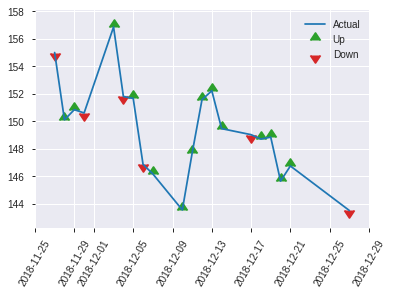


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20469857003017866
RMSE: 0.45243626073755255
LogLoss: 0.5934792903846644
Mean Per-Class Error: 0.30497483546264026
AUC: 0.7428700477480966
pr_auc: 0.7018135944981728
Gini: 0.48574009549619324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27433082461357117: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      45   81   0.6429   (81.0/126.0)
1      6    117  0.0488   (6.0/123.0)
Total  51   198  0.3494   (87.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274331     0.728972  197
max f2                       0.211916     0.853315  216
max f0point5                 0.535649     0.689382  126
max accuracy                 0.535649     0.694779  126
max precision                0.871194     1         0
max recall                   0.0930752    1         244
max specificity              0.871194     1         0
max absolute_mcc             0.52906      0.390277  128
max min_per_class_accuracy   0.55023      0.682927  121
max mean_per_class_accuracy  0.52906      0.695025  128

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.86664            1.34959   1.34959            0.666667         0.868992  0.666667                    0.868992            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.864143           2.02439   1.61951            1                0.865752  0.8                         0.867696            0.0162602       0.0325203                  102.439   61.9512
    3        0.0321285                   0.850822           1.34959   1.51829            0.666667         0.858999  0.75                        0.864434            0.0162602       0.0487805                  34.9593   51.8293
    4        0.0401606                   0.823417           2.02439   1.61951            1                0.841912  0.8                         0.85993             0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.810866           2.02439   1.71295            1                0.819787  0.846154                    0.850666            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.760902           1.68699   1.70049            0.833333         0.781163  0.84                        0.817305            0.0813008       0.170732                   68.6992   70.0488
    7        0.15261                     0.730492           1.4015    1.5982             0.692308         0.74528   0.789474                    0.792665            0.0731707       0.243902                   40.1501   59.8203
    8        0.200803                    0.709694           1.68699   1.61951            0.833333         0.720698  0.8                         0.775392            0.0813008       0.325203                   68.6992   61.9512
    9        0.301205                    0.666741           1.05268   1.43057            0.52             0.691339  0.706667                    0.747375            0.105691        0.430894                   5.26829   43.0569
    10       0.401606                    0.610374           1.21463   1.37659            0.6              0.642614  0.68                        0.721185            0.121951        0.552846                   21.4634   37.6585
    11       0.502008                    0.539635           1.37659   1.37659            0.68             0.579655  0.68                        0.692879            0.138211        0.691057                   37.6585   37.6585
    12       0.598394                    0.470785           0.759146  1.27713            0.375            0.502255  0.630872                    0.662174            0.0731707       0.764228                   -24.0854  27.7132
    13       0.698795                    0.362562           0.971707  1.23325            0.48             0.423491  0.609195                    0.627881            0.097561        0.861789                   -2.82927  23.3249
    14       0.799197                    0.272908           0.890732  1.19022            0.44             0.305097  0.58794                     0.58733             0.0894309       0.95122                    -10.9268  19.0219
    15       0.899598                    0.166198           0.323902  1.09353            0.16             0.224987  0.540179                    0.54689             0.0325203       0.98374                    -67.6098  9.35322
    16       1                           0.0898337          0.161951  1                  0.08             0.116807  0.493976                    0.503709         

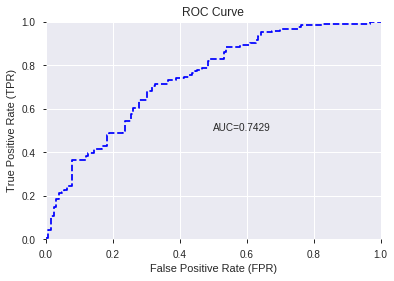

This function is available for GLM models only


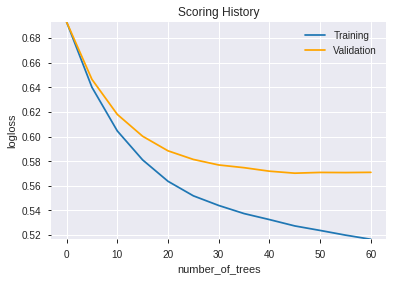

--2019-08-28 19:16:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_191626_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_191626_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'VAR_12',
 'WILLR_8',
 'COSH',
 'CORREL_24',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [895 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


41

['BOP',
 'CCI_8',
 'CMO_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'WILLR_24',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_191750_model_3  0.742741  0.635886              0.326074  0.454460  0.206534
1  DeepLearning_grid_1_AutoML_20190828_191750_model_6  0.737902  0.607228              0.329849  0.454181  0.206280
2               DeepLearning_1_AutoML_20190828_191750  0.737579  0.630936              0.318041  0.466597  0.217713
3  DeepLearning_grid_1_AutoML_20190828_191750_model_5  0.737385  0.633592              0.288037  0.457000  0.208849
4  DeepLearning_grid_1_AutoML_20190828_191750_model_8  0.736418  0.613340              0.314460  0.454886  0.206921
5  DeepLearning_grid_1_AutoML_20190828_191750_model_9  0.735192  0.603089              0.314654  0.455309  0.207307
6  DeepLearning_grid_1_AutoML_20190828_191750_model_7  0.730223  0.686186              0.329946  0.467869  0.218901
7  DeepLearning_grid_1_AutoML_20190828_191750_model_2  0.729126  0.671462              0.337786  0.477874  0.228363
8  DeepLearning_grid_1_AutoML_20190828_191750_model_4  0.723964  0.700682              0.322784  0.471142  0.221975
9  DeepLearning_grid_1_AutoML_20190828_191750_model_1  0.708866  0.795838              0.341947  0.493833  0.243871

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.051872
1          CDLLONGLINE             0.799746           0.799746    0.041485
2                  DIV             0.762806           0.762806    0.039569
3                  BOP             0.753076           0.753076    0.039064
4                  SUB             0.701525           0.701525    0.036390
5         CDLENGULFING             0.672285           0.672285    0.034873
6         CDLSHORTLINE             0.624920           0.624920    0.032416
7               TRANGE             0.596235           0.596235    0.030928
8          CDLBELTHOLD             0.546835           0.546835    0.028366
9       STOCHRSI_fastk             0.518035           0.518035    0.026872
10         CDLMARUBOZU             0.507860           0.507860    0.026344
11        STOCHF_fastk             0.474018           0.474018    0.024588
12      STOCHRSI_fastd             0.470638           0.470638    0.024413
13               ADOSC             0.467388           0.467388    0.024244
14              ULTOSC             0.456976           0.456976    0.023704
15        STOCHF_fastd             0.432824           0.432824    0.022452
16         STOCH_slowk             0.428088           0.428088    0.022206
17            WILLR_30             0.414495           0.414495    0.021501
18              RSI_20             0.412166           0.412166    0.021380
19            WILLR_12             0.410135           0.410135    0.021275
20              CMO_20             0.406611           0.406611    0.021092
21             WILLR_8             0.405656           0.405656    0.021042
22              ROCR_8             0.401474           0.401474    0.020825
23              CCI_12             0.398981           0.398981    0.020696
24              ROCP_8             0.395750           0.395750    0.020528
25            WILLR_20             0.393819           0.393819    0.020428
26               CCI_8             0.390622           0.390622    0.020262
27            WILLR_14             0.389133           0.389133    0.020185
28               MOM_8             0.388474           0.388474    0.020151
29               ROC_8             0.382118           0.382118    0.019821
30            WILLR_24             0.381006           0.381006    0.019764
31              CCI_14             0.368254           0.368254    0.019102
32              CCI_24             0.363876           0.363876    0.018875
33              CMO_14             0.361892           0.361892    0.018772
34           ROCR100_8             0.361843           0.361843    0.018770
35               RSI_8             0.347824           0.347824    0.018042
36              RSI_14             0.347048           0.347048    0.018002
37              CCI_20             0.346353           0.346353    0.017966
38              CMO_12             0.337938           0.337938    0.017530
39               CMO_8             0.335003           0.335003    0.017377
40              RSI_12             0.324378           0.324378    0.016826

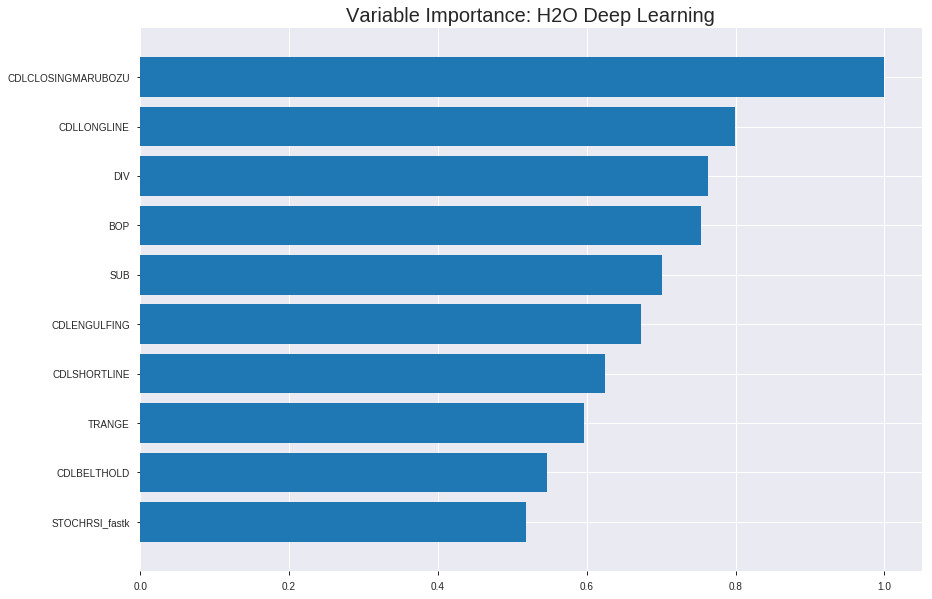

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_191750_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.181621033201214
RMSE: 0.4261701927648319
LogLoss: 0.5616259525349485
Mean Per-Class Error: 0.26473160534010765
AUC: 0.8065719313565938
pr_auc: 0.8017993992212392
Gini: 0.6131438627131875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3895834919603907: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      475  351   0.4249   (351.0/826.0)
1      123  792   0.1344   (123.0/915.0)
Total  598  1143  0.2723   (474.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389583     0.769679  254
max f2                       0.0863844    0.860664  358
max f0point5                 0.609252     0.756023  152
max accuracy                 0.516657     0.735784  199
max precision                0.99945      1         0
max recall                   0.00100008   1         398
max specificity              0.99945      1         0
max absolute_mcc             0.516657     0.470382  199
max min_per_class_accuracy   0.525778     0.732446  195
max mean_per_class_accuracy  0.516657     0.735268  199

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.998891           1.90273   1.90273            1                0.999326   1                           0.999326            0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.996105           1.67888   1.794              0.882353         0.998027   0.942857                    0.998695            0.0163934       0.0360656                  67.8881   79.4005
    3        0.0304423                   0.993835           1.69132   1.75913            0.888889         0.99497    0.924528                    0.99743             0.0174863       0.0535519                  69.1318   75.913
    4        0.0402068                   0.989304           1.90273   1.794              1                0.991456   0.942857                    0.995979            0.0185792       0.0721311                  90.2732   79.4005
    5        0.0505457                   0.984              1.79702   1.79462            0.944444         0.986589   0.943182                    0.994058            0.0185792       0.0907104                  79.7025   79.4622
    6        0.100517                    0.901055           1.7059    1.75051            0.896552         0.940581   0.92                        0.967472            0.0852459       0.175956                   70.5898   75.0514
    7        0.150488                    0.8373             1.59655   1.69939            0.83908          0.872109   0.89313                     0.935806            0.0797814       0.255738                   59.6545   69.9387
    8        0.20046                     0.751472           1.50906   1.65194            0.793103         0.797658   0.868195                    0.901368            0.0754098       0.331148                   50.9064   65.1942
    9        0.300402                    0.666292           1.45439   1.58622            0.764368         0.700834   0.833652                    0.834651            0.145355        0.476503                   45.4387   58.6217
    10       0.400345                    0.597471           1.3341    1.52328            0.701149         0.630594   0.800574                    0.78371             0.133333        0.609836                   33.41     52.3278
    11       0.500287                    0.533287           1.09352   1.43743            0.574713         0.565469   0.755454                    0.740112            0.10929         0.719126                   9.35243   43.7426
    12       0.60023                     0.445913           0.89669   1.34739            0.471264         0.492275   0.708134                    0.698845            0.0896175       0.808743                   -10.331   34.7389
    13       0.700172                    0.329544           0.852949  1.27681            0.448276         0.39449    0.671042                    0.655402            0.0852459       0.893989                   -14.7051  27.6813
    14       0.800115                    0.172769           0.503021  1.18016            0.264368         0.257408   0.620244                    0.605688            0.0502732       0.944262                   -49.6979  18.0158
    15       0.900057                    0.039741           0.338993  1.08676            0.178161         0.0957222  0.571155                    0.549061            0.0338798       0.978142                   -66.1007  8.67552
    16       1                           1.75303e-06        0.218705  1                  0.114943         0.0134986  0.52556                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18831133112066167
RMSE: 0.43394853510602116
LogLoss: 0.5706852644978108
Mean Per-Class Error: 0.28299262517790136
AUC: 0.7896396687799198
pr_auc: 0.7886853012720177
Gini: 0.5792793375598395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31587714428748476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  134  0.5678   (134.0/236.0)
1      21   241  0.0802   (21.0/262.0)
Total  123  375  0.3112   (155.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.315877     0.756672  297
max f2                       0.148443     0.869121  338
max f0point5                 0.585324     0.744207  171
max accuracy                 0.585324     0.712851  171
max precision                0.999472     1         0
max recall                   0.00596296   1         391
max specificity              0.999472     1         0
max absolute_mcc             0.585324     0.437521  171
max min_per_class_accuracy   0.542501     0.707627  202
max mean_per_class_accuracy  0.585324     0.717007  171

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.999101           1.90076   1.90076            1                0.99938    1                           0.99938             0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.998487           1.52061   1.71069            0.8              0.998986   0.9                         0.999183            0.0152672       0.0343511                  52.0611   71.0687
    3        0.0301205                   0.995084           1.90076   1.77405            1                0.997437   0.933333                    0.998601            0.019084        0.0534351                  90.0763   77.4046
    4        0.0401606                   0.991654           1.90076   1.80573            1                0.994213   0.95                        0.997504            0.019084        0.0725191                  90.0763   80.5725
    5        0.0502008                   0.984155           1.90076   1.82473            1                0.988913   0.96                        0.995786            0.019084        0.0916031                  90.0763   82.4733
    6        0.100402                    0.890634           1.52061   1.67267            0.8              0.94026    0.88                        0.968023            0.0763359       0.167939                   52.0611   67.2672
    7        0.150602                    0.830526           1.7487    1.69802            0.92             0.863972   0.893333                    0.933339            0.0877863       0.255725                   74.8702   69.8015
    8        0.200803                    0.745861           1.7487    1.71069            0.92             0.788301   0.9                         0.89708             0.0877863       0.343511                   74.8702   71.0687
    9        0.301205                    0.66677            1.40656   1.60931            0.74             0.702918   0.846667                    0.832359            0.141221        0.484733                   40.6565   60.9313
    10       0.399598                    0.604216           1.12494   1.49005            0.591837         0.636828   0.78392                     0.784214            0.110687        0.59542                    12.4942   49.0046
    11       0.5                         0.546037           1.02641   1.39695            0.54             0.575102   0.73494                     0.742223            0.103053        0.698473                   2.64122   39.6947
    12       0.600402                    0.472963           0.836336  1.3032             0.44             0.510267   0.685619                    0.703435            0.0839695       0.782443                   -16.3664  30.3199
    13       0.698795                    0.353919           0.853404  1.23987            0.44898          0.416693   0.652299                    0.66306             0.0839695       0.866412                   -14.6596  23.9866
    14       0.799197                    0.228821           0.684275  1.17007            0.36             0.304145   0.615578                    0.61797             0.0687023       0.935115                   -31.5725  17.0068
    15       0.899598                    0.0558919          0.456183  1.09039            0.24             0.139371   0.573661                    0.564555            0.0458015       0.980916                   -54.3817  9.03933
    16       1                           0.000160067        0.190076  1                  0.1              0.0174544  0.526104                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:19:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:19:29  1 min 37.157 sec  6977 obs/sec      10        1             17410      0.449603         0.652564            0.18931        0.779818        0.753694           1.90273          0.309592                         0.443583           0.614408              0.210784         0.788968          0.789876             1.52061            0.34739
    2019-08-28 19:19:35  1 min 43.695 sec  7768 obs/sec      40        4             69640      0.433211         0.574947            0.247345       0.792225        0.770791           1.90273          0.293509                         0.436507           0.577633              0.235764         0.787036          0.777426             1.52061            0.309237
    2019-08-28 19:19:40  1 min 48.854 sec  8670 obs/sec      70        7             121870     0.42617          0.561626            0.271612       0.806572        0.801799           1.90273          0.272257                         0.433949           0.570685              0.244696         0.78964           0.788685             1.90076            0.311245
    2019-08-28 19:19:46  1 min 54.839 sec  9589 obs/sec      110       11            191510     0.422701         0.556106            0.283423       0.810813        0.786674           1.90273          0.282022                         0.436019           0.582314              0.237473         0.788694          0.765218             1.90076            0.321285
    2019-08-28 19:19:52  2 min  0.305 sec  10295 obs/sec     150       15            261150     0.415475         0.537782            0.307713       0.823129        0.797638           1.90273          0.271683                         0.436126           0.581623              0.237097         0.784561          0.755605             1.52061            0.309237
    2019-08-28 19:19:57  2 min  5.455 sec  10865 obs/sec     190       19            330790     0.410481         0.526089            0.324256       0.8319          0.80927            1.90273          0.252154                         0.436203           0.585179              0.236829         0.786292          0.752004             1.90076            0.309237
    2019-08-28 19:19:57  2 min  5.556 sec  10862 obs/sec     190       19            330790     0.42617          0.561626            0.271612       0.806572        0.801799           1.90273          0.272257                         0.433949           0.570685              0.244696         0.78964           0.788685             1.90076            0.311245

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.051872315501361746
CDLLONGLINE         0.7997457981109619     0.7997457981109619   0.04148466636050017
DIV                 0.762806236743927      0.762806236743927    0.039568525778787424
BOP                 0.7530758380889893     0.7530758380889893   0.03906378746980446
SUB                 0.7015253305435181     0.7015253305435181   0.036389743278150456
---                 ---                    ---                  ---
RSI_14              0.34704819321632385    0.34704819321632385  0.0180021933726947
CCI_20              0.3463532626628876     0.3463532626628876   0.01796614571577532
CMO_12              0.33793774247169495    0.33793774247169495  0.017529613197309696
CMO_8               0.3350030779838562     0.3350030779838562   0.01737738535510588
RSI_12              0.32437804341316223    0.32437804341316223  0.016826240209641966


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6827309236947792)

('F1', 0.7388535031847134)

('auc', 0.7427409988385597)

('logloss', 0.6358860938970133)

('mean_per_class_error', 0.3146535036778939)

('rmse', 0.4544603760350671)

('mse', 0.2065342333859346)

deeplearning prediction progress: |███████████████████████████████████████| 100%


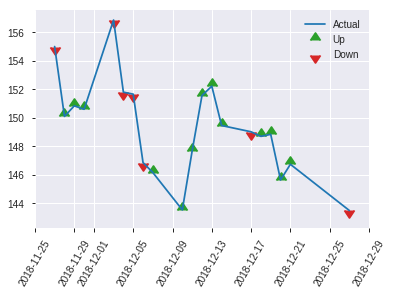


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2065342333859346
RMSE: 0.4544603760350671
LogLoss: 0.6358860938970133
Mean Per-Class Error: 0.3146535036778939
AUC: 0.7427409988385597
pr_auc: 0.7018360627247066
Gini: 0.4854819976771194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1991063024337724: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   75   0.5952   (75.0/126.0)
1      7    116  0.0569   (7.0/123.0)
Total  58   191  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.199106     0.738854  190
max f2                       0.107176     0.861823  209
max f0point5                 0.320133     0.664671  177
max accuracy                 0.320133     0.682731  177
max precision                0.993254     0.857143  6
max recall                   0.00396894   1         244
max specificity              0.999765     0.992063  0
max absolute_mcc             0.199106     0.411435  190
max min_per_class_accuracy   0.509909     0.650794  124
max mean_per_class_accuracy  0.320133     0.685346  177

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 47.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.999248           1.34959   1.34959            0.666667         0.999572   0.666667                    0.999572            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.994492           2.02439   1.61951            1                0.998855   0.8                         0.999285            0.0162602       0.0325203                  102.439   61.9512
    3        0.0321285                   0.973548           1.34959   1.51829            0.666667         0.987734   0.75                        0.994954            0.0162602       0.0487805                  34.9593   51.8293
    4        0.0401606                   0.94757            1.0122    1.41707            0.5              0.970052   0.7                         0.989973            0.00813008      0.0569106                  1.21951   41.7073
    5        0.0522088                   0.911828           2.02439   1.55722            1                0.930895   0.769231                    0.97634             0.0243902       0.0813008                  102.439   55.7223
    6        0.100402                    0.834791           1.68699   1.61951            0.833333         0.868477   0.8                         0.924566            0.0813008       0.162602                   68.6992   61.9512
    7        0.15261                     0.751611           1.71295   1.65148            0.846154         0.795695   0.815789                    0.880478            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.69071            1.51829   1.61951            0.75             0.710312   0.8                         0.839639            0.0731707       0.325203                   51.8293   61.9512
    9        0.301205                    0.631397           1.29561   1.51154            0.64             0.668009   0.746667                    0.782429            0.130081        0.455285                   29.561    51.1545
    10       0.401606                    0.569291           0.890732  1.35634            0.44             0.603551   0.67                        0.737709            0.0894309       0.544715                   -10.9268  35.6341
    11       0.502008                    0.509909           1.13366   1.3118             0.56             0.538679   0.648                       0.697903            0.113821        0.658537                   13.3659   31.1805
    12       0.598394                    0.456103           1.09654   1.27713            0.541667         0.483347   0.630872                    0.663344            0.105691        0.764228                   9.65447   27.7132
    13       0.698795                    0.349456           1.05268   1.24488            0.52             0.409044   0.614943                    0.626807            0.105691        0.869919                   5.26829   24.4884
    14       0.799197                    0.162829           0.809756  1.19022            0.4              0.247035   0.58794                     0.579097            0.0813008       0.95122                    -19.0244  19.0219
    15       0.899598                    0.0597604          0.323902  1.09353            0.16             0.102505   0.540179                    0.525906            0.0325203       0.98374                    -67.6098  9.35322
    16       1                           0.000308693        0.161951  1                  0.08             0.0215681  0.493976                   

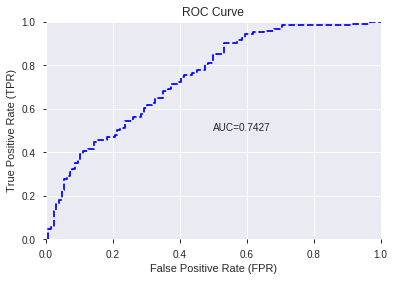

This function is available for GLM models only


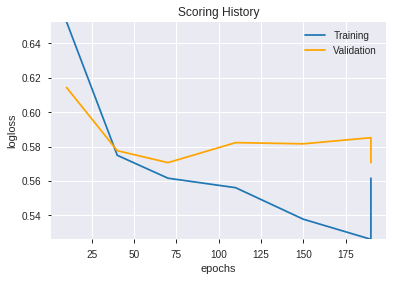

--2019-08-28 19:26:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_191750_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_191750_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'DIV',
 'BOP',
 'SUB',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'TRANGE',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'ADOSC',
 'ULTOSC',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_30',
 'RSI_20',
 'WILLR_12',
 'CMO_20',
 'WILLR_8',
 'ROCR_8',
 'CCI_12',
 'ROCP_8',
 'WILLR_20',
 'CCI_8',
 'WILLR_14',
 'MOM_8',
 'ROC_8',
 'WILLR_24',
 'CCI_14',
 'CCI_24',
 'CMO_14',
 'ROCR100_8',
 'RSI_8',
 'RSI_14',
 'CCI_20',
 'CMO_12',
 'CMO_8',
 'RSI_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_192750_model_1  0.74558  0.590875              0.306233  0.451793  0.204117

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.854940           1.000000    0.129254
1         STOCHF_fastk             0.644696           0.754084    0.097468
2                CCI_8             0.414892           0.485288    0.062725
3                  SUB             0.389919           0.456078    0.058950
4              WILLR_8             0.379954           0.444422    0.057443
5                MOM_8             0.321048           0.375521    0.048537
6               ULTOSC             0.293223           0.342975    0.044331
7               CMO_20             0.256501           0.300022    0.038779
8               RSI_20             0.228077           0.266775    0.034482
9         STOCHF_fastd             0.218260           0.255292    0.032997
10         STOCH_slowk             0.202349           0.236683    0.030592
11              CCI_24             0.189599           0.221769    0.028665
12              CMO_12             0.183502           0.214638    0.027743
13            WILLR_30             0.161208           0.188561    0.024372
14               RSI_8             0.159110           0.186107    0.024055
15         CDLLONGLINE             0.156739           0.183333    0.023696
16                 DIV             0.148438           0.173623    0.022441
17              RSI_12             0.145067           0.169681    0.021932
18            WILLR_12             0.137996           0.161410    0.020863
19               CMO_8             0.130640           0.152806    0.019751
20              TRANGE             0.122327           0.143083    0.018494
21      STOCHRSI_fastd             0.113871           0.133192    0.017216
22      STOCHRSI_fastk             0.103453           0.121006    0.015640
23               ADOSC             0.100283           0.117299    0.015161
24        CDLSHORTLINE             0.085164           0.099614    0.012876
25            WILLR_14             0.068836           0.080516    0.010407
26              CMO_14             0.063879           0.074718    0.009658
27  CDLCLOSINGMARUBOZU             0.047197           0.055205    0.007135
28              RSI_14             0.047060           0.055045    0.007115
29              CCI_12             0.038700           0.045267    0.005851
30               ROC_8             0.025562           0.029899    0.003865
31              CCI_20             0.024408           0.028549    0.003690
32              ROCP_8             0.022147           0.025905    0.003348
33            WILLR_20             0.021071           0.024647    0.003186
34              ROCR_8             0.020541           0.024026    0.003105
35        CDLENGULFING             0.020299           0.023743    0.003069
36           ROCR100_8             0.019510           0.022820    0.002950
37            WILLR_24             0.017361           0.020307    0.002625
38         CDLBELTHOLD             0.017306           0.020242    0.002616
39         CDLMARUBOZU             0.010298           0.012045    0.001557
40              CCI_14             0.009004           0.010532    0.001361

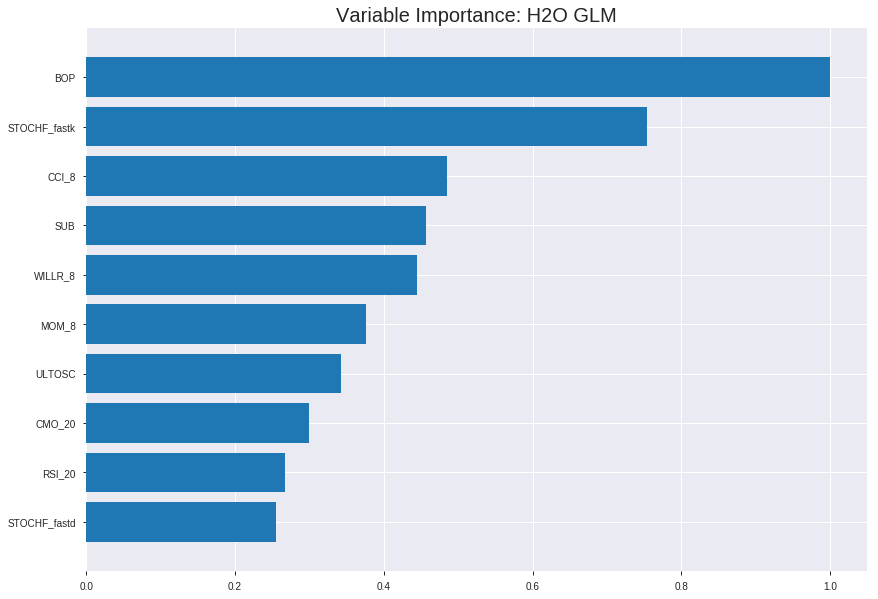

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_192750_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18089990048282242
RMSE: 0.42532328937271047
LogLoss: 0.5396112409382139
Null degrees of freedom: 1740
Residual degrees of freedom: 1699
Null deviance: 2408.986814961971
Residual deviance: 1878.926340946861
AIC: 1962.926340946861
AUC: 0.8008593656968205
pr_auc: 0.797493752017555
Gini: 0.601718731393641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41569566410889686: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      486  340   0.4116   (340.0/826.0)
1      134  781   0.1464   (134.0/915.0)
Total  620  1121  0.2723   (474.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415696     0.767191  243
max f2                       0.214591     0.863619  324
max f0point5                 0.545403     0.751721  188
max accuracy                 0.545403     0.736933  188
max precision                0.968601     1         0
max recall                   0.070866     1         379
max specificity              0.968601     1         0
max absolute_mcc             0.465537     0.47325   221
max min_per_class_accuracy   0.548        0.734867  187
max mean_per_class_accuracy  0.545403     0.736773  188

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.942441           1.90273   1.90273            1                0.95317    1                           0.95317             0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.929797           1.67888   1.794              0.882353         0.936814   0.942857                    0.945226            0.0163934       0.0360656                  67.8881   79.4005
    3        0.0304423                   0.919102           1.69132   1.75913            0.888889         0.924873   0.924528                    0.938313            0.0174863       0.0535519                  69.1318   75.913
    4        0.0402068                   0.905952           1.67888   1.73964            0.882353         0.912036   0.914286                    0.931932            0.0163934       0.0699454                  67.8881   73.9641
    5        0.0505457                   0.897022           1.58561   1.70813            0.833333         0.901546   0.897727                    0.925716            0.0163934       0.0863388                  58.561    70.8135
    6        0.100517                    0.850879           1.66216   1.68528            0.873563         0.872368   0.885714                    0.899195            0.0830601       0.169399                   66.2157   68.5277
    7        0.150488                    0.82053            1.59655   1.65581            0.83908          0.836572   0.870229                    0.8784              0.0797814       0.24918                    59.6545   65.5813
    8        0.20046                     0.785094           1.5528    1.63013            0.816092         0.802896   0.856734                    0.859578            0.0775956       0.326776                   55.2804   63.0134
    9        0.300402                    0.711623           1.38878   1.54984            0.729885         0.749171   0.814532                    0.822846            0.138798        0.465574                   38.8776   54.9835
    10       0.400345                    0.641482           1.27942   1.48233            0.672414         0.67876    0.779053                    0.786876            0.127869        0.593443                   27.9423   48.2329
    11       0.500287                    0.558882           1.26849   1.43961            0.666667         0.601342   0.756602                    0.749812            0.126776        0.720219                   26.8488   43.961
    12       0.60023                     0.460009           0.984172  1.36378            0.517241         0.511194   0.716746                    0.71008             0.0983607       0.818579                   -1.58282  36.3777
    13       0.700172                    0.35194            0.710791  1.27057            0.373563         0.406144   0.66776                     0.666697            0.0710383       0.889617                   -28.9209  27.0569
    14       0.800115                    0.247406           0.590503  1.18562            0.310345         0.300646   0.623116                    0.620973            0.0590164       0.948634                   -40.9497  18.5622
    15       0.900057                    0.147306           0.328057  1.0904             0.172414         0.197709   0.57307                     0.573974            0.0327869       0.981421                   -67.1943  9.03979
    16       1                           0.00815474         0.185899  1                  0.0977011        0.0895593  0.52556                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1823683190874323
RMSE: 0.4270460386040741
LogLoss: 0.5379241832681656
Null degrees of freedom: 497
Residual degrees of freedom: 456
Null deviance: 689.0171367028406
Residual deviance: 535.7724865350931
AIC: 619.7724865350931
AUC: 0.7982355414672014
pr_auc: 0.8090761719304829
Gini: 0.5964710829344029
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35927773309729366: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  119  0.5042   (119.0/236.0)
1      28   234  0.1069   (28.0/262.0)
Total  145  353  0.2952   (147.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359278     0.760976  281
max f2                       0.216575     0.872529  335
max f0point5                 0.666283     0.751566  138
max accuracy                 0.516038     0.710843  209
max precision                0.965136     1         0
max recall                   0.0824322    1         388
max specificity              0.965136     1         0
max absolute_mcc             0.666283     0.442472  138
max min_per_class_accuracy   0.532674     0.706107  200
max mean_per_class_accuracy  0.637808     0.711476  151

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.944315           1.90076    1.90076            1                0.95843    1                           0.95843             0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.933175           1.52061    1.71069            0.8              0.937531   0.9                         0.94798             0.0152672       0.0343511                  52.0611   71.0687
    3        0.0301205                   0.924194           1.90076    1.77405            1                0.928713   0.933333                    0.941558            0.019084        0.0534351                  90.0763   77.4046
    4        0.0401606                   0.920423           1.90076    1.80573            1                0.922273   0.95                        0.936737            0.019084        0.0725191                  90.0763   80.5725
    5        0.0502008                   0.913112           1.52061    1.7487             0.8              0.918088   0.92                        0.933007            0.0152672       0.0877863                  52.0611   74.8702
    6        0.100402                    0.871224           1.7487     1.7487             0.92             0.891381   0.92                        0.912194            0.0877863       0.175573                   74.8702   74.8702
    7        0.150602                    0.824456           1.7487     1.7487             0.92             0.846818   0.92                        0.890402            0.0877863       0.263359                   74.8702   74.8702
    8        0.200803                    0.782312           1.59664    1.71069            0.84             0.799772   0.9                         0.867744            0.0801527       0.343511                   59.6641   71.0687
    9        0.301205                    0.716534           1.36855    1.59664            0.72             0.749987   0.84                        0.828492            0.137405        0.480916                   36.855    59.6641
    10       0.399598                    0.620166           1.16373    1.49005            0.612245         0.665956   0.78392                     0.788471            0.114504        0.59542                    16.3733   49.0046
    11       0.5                         0.536436           0.988397   1.38931            0.52             0.57918    0.730924                    0.746444            0.0992366       0.694656                   -1.16031  38.9313
    12       0.600402                    0.460069           0.874351   1.3032             0.46             0.499206   0.685619                    0.7051              0.0877863       0.782443                   -12.5649  30.3199
    13       0.698795                    0.377635           0.969777   1.25625            0.510204         0.421182   0.66092                     0.665123            0.0954198       0.877863                   -3.02228  25.6252
    14       0.799197                    0.257288           0.72229    1.18917            0.38             0.314543   0.625628                    0.621081            0.0725191       0.950382                   -27.771   18.9171
    15       0.899598                    0.160436           0.418168   1.10312            0.22             0.207689   0.580357                    0.574943            0.0419847       0.992366                   -58.1832  10.3122
    16       1                           0.0306155          0.0760305  1                  0.04             0.0993818  0.526104 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:27:50  0.000 sec   2            .24E2     42            1.3603730580807014  1.3606458585040377
     2019-08-28 19:27:50  0.010 sec   4            .15E2     42            1.3497790691609663  1.3501290566006627
     2019-08-28 19:27:50  0.021 sec   6            .93E1     42            1.3359247521988251  1.3362935656587445
     2019-08-28 19:27:50  0.033 sec   8            .58E1     42            1.3185235895212715  1.3188148911849216
     2019-08-28 19:27:50  0.051 sec   10           .36E1     42            1.2972580999794345  1.297362275619582
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:27:51  0.261 sec   45           .26E-3    42            1.079094422436066   1.0759560683415872
     2019-08-28 19:27:51  0.268 sec   46           .16E-3    42            1.0790377241433846  1.0760361692324831
     2019-08-28 19:27:51  0.277 sec   47           .1E-3     42            1.0790209687798462  1.0760605167550348
     2019-08-28 19:27:51  0.283 sec   48           .62E-4    42            1.0790088804219078  1.076078455800544
     2019-08-28 19:27:51  0.292 sec   49           .39E-4    42            1.0790047658370914  1.0760792581214573


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7508090614886731)

('auc', 0.7455800748483675)

('logloss', 0.5908747540143534)

('mean_per_class_error', 0.2955865272938444)

('rmse', 0.451793293793197)

('mse', 0.20411718031650603)

glm prediction progress: |████████████████████████████████████████████████| 100%


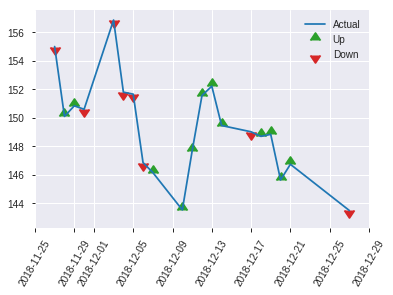


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20411718031650603
RMSE: 0.451793293793197
LogLoss: 0.5908747540143534
Null degrees of freedom: 248
Residual degrees of freedom: 207
Null deviance: 346.14583701949294
Residual deviance: 294.255627499148
AIC: 378.255627499148
AUC: 0.7455800748483675
pr_auc: 0.7112940945273599
Gini: 0.49116014969673505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3333138446790205: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   70   0.5556   (70.0/126.0)
1      7    116  0.0569   (7.0/123.0)
Total  63   186  0.3092   (77.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.333314     0.750809  185
max f2                       0.277157     0.859827  199
max f0point5                 0.39947      0.685752  156
max accuracy                 0.39947      0.702811  156
max precision                0.96727      1         0
max recall                   0.0834158    1         238
max specificity              0.96727      1         0
max absolute_mcc             0.333314     0.445678  185
max min_per_class_accuracy   0.512316     0.666667  123
max mean_per_class_accuracy  0.39947      0.704413  156

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.935631           2.02439   2.02439            1                0.951689  1                           0.951689            0.0243902       0.0243902                  102.439   102.439
    2        0.0200803                   0.927645           2.02439   2.02439            1                0.92849   1                           0.942409            0.0162602       0.0406504                  102.439   102.439
    3        0.0321285                   0.905327           2.02439   2.02439            1                0.919343  1                           0.933759            0.0243902       0.0650407                  102.439   102.439
    4        0.0401606                   0.902727           2.02439   2.02439            1                0.904056  1                           0.927819            0.0162602       0.0813008                  102.439   102.439
    5        0.0522088                   0.888829           1.34959   1.86867            0.666667         0.900737  0.923077                    0.921569            0.0162602       0.097561                   34.9593   86.8668
    6        0.100402                    0.829771           1.51829   1.70049            0.75             0.850637  0.84                        0.887522            0.0731707       0.170732                   51.8293   70.0488
    7        0.15261                     0.788063           1.4015    1.5982             0.692308         0.808357  0.789474                    0.860439            0.0731707       0.243902                   40.1501   59.8203
    8        0.200803                    0.738247           0.674797  1.37659            0.333333         0.764138  0.68                        0.837327            0.0325203       0.276423                   -32.5203  37.6585
    9        0.301205                    0.670597           1.45756   1.40358            0.72             0.706     0.693333                    0.793551            0.146341        0.422764                   45.7561   40.3577
    10       0.401606                    0.598731           1.37659   1.39683            0.68             0.633934  0.69                        0.753647            0.138211        0.560976                   37.6585   39.6829
    11       0.502008                    0.511307           1.13366   1.3442             0.56             0.552217  0.664                       0.713361            0.113821        0.674797                   13.3659   34.4195
    12       0.598394                    0.42205            1.09654   1.30431            0.541667         0.467343  0.644295                    0.673734            0.105691        0.780488                   9.65447   30.4305
    13       0.698795                    0.354863           1.05268   1.26815            0.52             0.383227  0.626437                    0.631994            0.105691        0.886179                   5.26829   26.8153
    14       0.799197                    0.279661           0.72878   1.20039            0.36             0.324143  0.592965                    0.593319            0.0731707       0.95935                    -27.122   20.0392
    15       0.899598                    0.158796           0.242927  1.09353            0.12             0.199711  0.540179                    0.54939             0.0243902       0.98374                    -75.7073  9.35322
    16       1                           0.0242623          0.161951  1                  0.08             0.09332   0.493976                    0.5036           

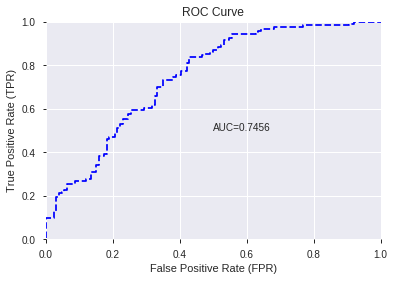

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


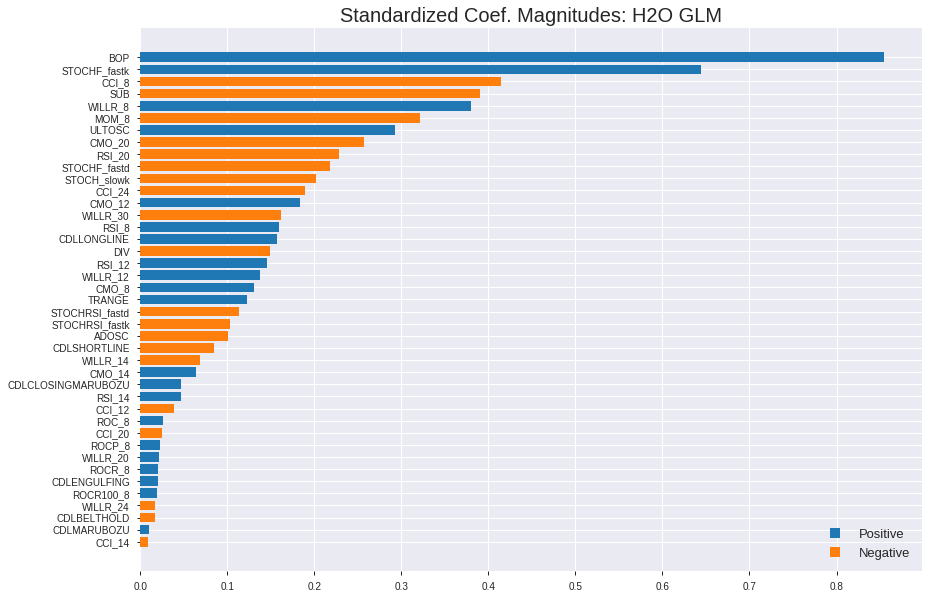

'log_likelihood'
--2019-08-28 19:28:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_192750_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_192750_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'SUB',
 'WILLR_8',
 'MOM_8',
 'ULTOSC',
 'CMO_20',
 'RSI_20',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_24',
 'CMO_12',
 'WILLR_30',
 'RSI_8',
 'CDLLONGLINE',
 'DIV',
 'RSI_12',
 'WILLR_12',
 'CMO_8',
 'TRANGE',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'ADOSC',
 'CDLSHORTLINE',
 'WILLR_14',
 'CMO_14',
 'CDLCLOSINGMARUBOZU',
 'RSI_14',
 'CCI_12',
 'ROC_8',
 'CCI_20',
 'ROCP_8',
 'WILLR_20',
 'ROCR_8',
 'CDLENGULFING',
 'ROCR100_8',
 'WILLR_24',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'CCI_14']

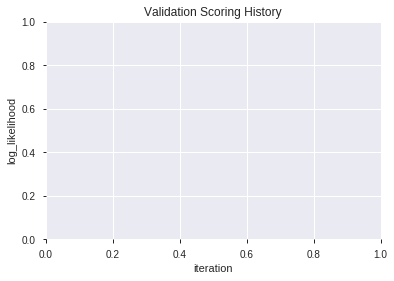

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_192857_model_4  0.748548  0.590501              0.314073  0.451700  0.204033
1  XGBoost_grid_1_AutoML_20190828_192857_model_3  0.736418  0.600820              0.333914  0.455061  0.207080
2               XGBoost_2_AutoML_20190828_192857  0.735579  0.598477              0.317944  0.454945  0.206975
3  XGBoost_grid_1_AutoML_20190828_192857_model_6  0.731062  0.605966              0.349593  0.458221  0.209966
4               XGBoost_1_AutoML_20190828_192857  0.728997  0.608061              0.334301  0.457684  0.209474
5  XGBoost_grid_1_AutoML_20190828_192857_model_2  0.728739  0.609754              0.322106  0.459416  0.211063
6  XGBoost_grid_1_AutoML_20190828_192857_model_7  0.727062  0.611900              0.314944  0.459312  0.210968
7               XGBoost_3_AutoML_20190828_192857  0.726352  0.610906              0.318525  0.459665  0.211292
8  XGBoost_grid_1_AutoML_20190828_192857_model_5  0.719061  0.643220              0.322590  0.468328  0.219331
9  XGBoost_grid_1_AutoML_20190828_192857_model_1  0.717254  0.623709              0.334495  0.464992  0.216217

variable  relative_importance  scaled_importance  percentage
0              BOP          3178.922607           1.000000    0.570436
1     STOCHF_fastk           323.372864           0.101724    0.058027
2              SUB           267.162354           0.084042    0.047940
3              DIV           256.939392           0.080826    0.046106
4           TRANGE           132.985580           0.041834    0.023863
5      STOCH_slowk           120.580086           0.037931    0.021637
6         WILLR_12           103.764099           0.032641    0.018620
7            MOM_8           101.503456           0.031930    0.018214
8            CCI_8            97.707924           0.030736    0.017533
9           ULTOSC            90.994850           0.028624    0.016328
10        WILLR_14            83.295700           0.026202    0.014947
11          CMO_20            83.229279           0.026182    0.014935
12  STOCHRSI_fastd            79.639587           0.025052    0.014291
13        WILLR_20            75.823021           0.023852    0.013606
14        WILLR_30            70.169594           0.022073    0.012591
15          CCI_24            69.048111           0.021721    0.012390
16          CCI_14            68.675392           0.021603    0.012323
17           ADOSC            62.956192           0.019804    0.011297
18         WILLR_8            60.100479           0.018906    0.010785
19          CCI_12            51.817509           0.016300    0.009298
20        WILLR_24            47.964733           0.015088    0.008607
21          CCI_20            34.260628           0.010777    0.006148
22          CMO_12            27.962950           0.008796    0.005018
23           CMO_8            21.175543           0.006661    0.003800
24          CMO_14            19.281143           0.006065    0.003460
25           ROC_8            18.749865           0.005898    0.003365
26  STOCHRSI_fastk            14.563013           0.004581    0.002613
27     CDLLONGLINE            10.151638           0.003193    0.001822

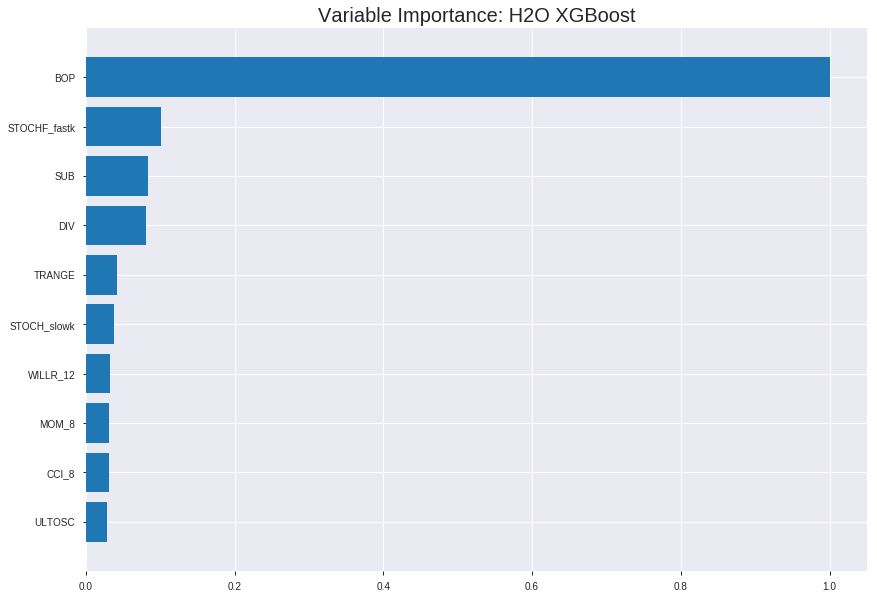

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_192857_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16537456650935267
RMSE: 0.40666271836664925
LogLoss: 0.5036554883492428
Mean Per-Class Error: 0.23349012291774174
AUC: 0.8387409200968522
pr_auc: 0.8398460422060958
Gini: 0.6774818401937044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44923558086156845: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      544  282   0.3414   (282.0/826.0)
1      137  778   0.1497   (137.0/915.0)
Total  681  1060  0.2407   (419.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449236     0.787848  228
max f2                       0.200699     0.873909  343
max f0point5                 0.580764     0.786098  172
max accuracy                 0.567566     0.765652  178
max precision                0.901158     1         0
max recall                   0.114437     1         381
max specificity              0.901158     1         0
max absolute_mcc             0.567566     0.532333  178
max min_per_class_accuracy   0.548718     0.761749  186
max mean_per_class_accuracy  0.567566     0.76651   178

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.35 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.884951           1.79702    1.79702            0.944444         0.891304  0.944444                    0.891304            0.0185792       0.0185792                  79.7025   79.7025
    2        0.0201034                   0.87717            1.79081    1.794              0.941176         0.881642  0.942857                    0.886611            0.0174863       0.0360656                  79.0807   79.4005
    3        0.0304423                   0.868891           1.90273    1.83093            1                0.873669  0.962264                    0.882216            0.0196721       0.0557377                  90.2732   83.0931
    4        0.0402068                   0.861756           1.79081    1.82119            0.941176         0.86511   0.957143                    0.878062            0.0174863       0.073224                   79.0807   82.1187
    5        0.0505457                   0.854346           1.90273    1.83787            1                0.858015  0.965909                    0.873961            0.0196721       0.0928962                  90.2732   83.7866
    6        0.100517                    0.834478           1.72777    1.78313            0.908046         0.843413  0.937143                    0.858774            0.0863388       0.179235                   72.7768   78.3132
    7        0.150488                    0.805861           1.77151    1.77927            0.931034         0.821222  0.935115                    0.846305            0.0885246       0.26776                    77.1509   77.9273
    8        0.20046                     0.776346           1.53093    1.71737            0.804598         0.790181  0.902579                    0.832314            0.0765027       0.344262                   53.0934   71.7366
    9        0.300402                    0.718281           1.49813    1.64443            0.787356         0.748223  0.864245                    0.804337            0.149727        0.493989                   49.8128   64.4426
    10       0.400345                    0.652209           1.38878    1.58061            0.729885         0.685211  0.830703                    0.774598            0.138798        0.632787                   38.8776   58.0605
    11       0.500287                    0.562592           1.19194    1.50296            0.626437         0.61059   0.789897                    0.741835            0.119126        0.751913                   19.1941   50.2962
    12       0.60023                     0.455715           0.874819   1.39837            0.45977          0.504859  0.734928                    0.702376            0.0874317       0.839344                   -12.5181  39.8372
    13       0.700172                    0.344904           0.677985   1.29554            0.356322         0.397481  0.680886                    0.658856            0.0677596       0.907104                   -32.2015  29.5544
    14       0.800115                    0.249253           0.481151   1.19382            0.252874         0.298271  0.627423                    0.613815            0.0480874       0.955191                   -51.8849  19.3818
    15       0.900057                    0.160591           0.382733   1.10375            0.201149         0.206736  0.580089                    0.568613            0.0382514       0.993443                   -61.7267  10.3755
    16       1                           0.0789604          0.0656115  1                  0.0344828        0.117624  0.52556                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19028819383380427
RMSE: 0.43622035009133203
LogLoss: 0.559764073365934
Mean Per-Class Error: 0.2804211411566826
AUC: 0.7832999094320092
pr_auc: 0.7963811472518038
Gini: 0.5665998188640184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2559165954589844: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      78   158  0.6695   (158.0/236.0)
1      12   250  0.0458   (12.0/262.0)
Total  90   408  0.3414   (170.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255917     0.746269  326
max f2                       0.176648     0.865513  362
max f0point5                 0.585567     0.739669  188
max accuracy                 0.561892     0.718876  197
max precision                0.902081     1         0
max recall                   0.12814      1         378
max specificity              0.902081     1         0
max absolute_mcc             0.561892     0.438562  197
max min_per_class_accuracy   0.558346     0.709924  200
max mean_per_class_accuracy  0.561892     0.719579  197

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 53.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.889205           1.90076   1.90076            1                0.896552  1                           0.896552            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.880217           1.90076   1.90076            1                0.884812  1                           0.890682            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.876518           1.90076   1.90076            1                0.877771  1                           0.886379            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.874461           1.90076   1.90076            1                0.875841  1                           0.883744            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.869002           1.52061   1.82473            0.8              0.873205  0.96                        0.881636            0.0152672       0.0916031                  52.0611   82.4733
    6        0.100402                    0.840863           1.67267   1.7487             0.88             0.854374  0.92                        0.868005            0.0839695       0.175573                   67.2672   74.8702
    7        0.150602                    0.80978            1.59664   1.69802            0.84             0.822905  0.893333                    0.852972            0.0801527       0.255725                   59.6641   69.8015
    8        0.200803                    0.779099           1.44458   1.63466            0.76             0.794295  0.86                        0.838303            0.0725191       0.328244                   44.458    63.4656
    9        0.301205                    0.710387           1.33053   1.53328            0.7              0.737948  0.806667                    0.804851            0.133588        0.461832                   33.0534   53.3282
    10       0.399598                    0.637523           1.3189    1.48049            0.693878         0.673315  0.778894                    0.772463            0.129771        0.591603                   31.8897   48.0494
    11       0.5                         0.560334           1.14046   1.41221            0.6              0.605884  0.742972                    0.739013            0.114504        0.706107                   14.0458   41.2214
    12       0.600402                    0.470565           0.836336  1.31591            0.44             0.52231   0.692308                    0.702775            0.0839695       0.790076                   -16.3664  31.5913
    13       0.698795                    0.380393           0.737031  1.2344             0.387755         0.4203    0.649425                    0.663001            0.0725191       0.862595                   -26.2969  23.4404
    14       0.799197                    0.273949           0.72229   1.17007            0.38             0.331471  0.615578                    0.621352            0.0725191       0.935115                   -27.771   17.0068
    15       0.899598                    0.188098           0.494198  1.09464            0.26             0.224078  0.575893                    0.577013            0.0496183       0.984733                   -50.5802  9.4636
    16       1                           0.0764536          0.152061  1                  0.08             0.135315  0.526104                    0.532666          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:29:06  3.591 sec   0                  0.5              0.693147            0.5             0                  1                0.47444                          0.5                0.693147              0.5               0                    1                  0.473896
    2019-08-28 19:29:06  3.695 sec   5                  0.472328         0.638927            0.80819         0.754125           1.7387           0.275129                         0.47585            0.645652              0.778311          0.723534             1.81025            0.337349
    2019-08-28 19:29:06  3.750 sec   10                 0.454064         0.603514            0.810838        0.792032           1.72152          0.272257                         0.461172           0.616778              0.774801          0.756713             1.90076            0.333333
    2019-08-28 19:29:06  3.807 sec   15                 0.441787         0.57922             0.814235        0.80708            1.80259          0.267662                         0.451655           0.597498              0.779839          0.799948             1.90076            0.329317
    2019-08-28 19:29:06  3.866 sec   20                 0.43365          0.562388            0.815068        0.806993           1.79702          0.264216                         0.445392           0.584107              0.781351          0.798212             1.90076            0.335341
    2019-08-28 19:29:06  3.928 sec   25                 0.427337         0.549235            0.818446        0.817689           1.79702          0.263067                         0.441787           0.57597               0.782402          0.799353             1.90076            0.331325
    2019-08-28 19:29:06  3.990 sec   30                 0.42286          0.539641            0.822357        0.822327           1.79702          0.263067                         0.439657           0.570774              0.783162          0.799304             1.90076            0.331325
    2019-08-28 19:29:06  4.061 sec   35                 0.419077         0.531211            0.825324        0.825807           1.70244          0.264216                         0.439003           0.568367              0.780914          0.795594             1.90076            0.335341
    2019-08-28 19:29:07  4.127 sec   40                 0.416378         0.525022            0.827583        0.828324           1.69132          0.255026                         0.43821            0.565828              0.781044          0.796646             1.90076            0.339357
    2019-08-28 19:29:07  4.203 sec   45                 0.414101         0.519936            0.829123        0.830008           1.79702          0.254451                         0.437408           0.56362               0.781618          0.797479             1.90076            0.331325
    2019-08-28 19:29:07  4.267 sec   50                 0.412051         0.515453            0.832115        0.833833           1.79702          0.251005                         0.436855           0.561889              0.782427          0.797749             1.90076            0.333333
    2019-08-28 19:29:07  4.336 sec   55                 0.410326         0.51155             0.833941        0.835661           1.79702          0.248133                         0.436184           0.560386              0.783987          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             3178.922607421875      1.0                    0.5704356845955377
STOCHF_fastk    323.37286376953125     0.10172404418231136    0.05802702478296352
SUB             267.162353515625       0.08404179230154182    0.047940437326166006
DIV             256.93939208984375     0.08082593501646242    0.04610599757419019
TRANGE          132.98558044433594     0.04183353823520354    0.023863343022251935
---             ---                    ---                    ---
CMO_8           21.1755428314209       0.0066612325767170496  0.0037998047651496883
CMO_14          19.281143188476562     0.006065307517540882   0.0034598678460508953
ROC_8           18.74986457824707      0.005898182149660234   0.003364533572410616
STOCHRSI_fastk  14.563013076782227     0.004581115955066587   0.0026132320160399494
CDLLONGLINE     10.15163803100586      0.0031934209430908096  0.0018216412618737338


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6827309236947792)

('F1', 0.7476038338658147)

('auc', 0.7485481997677119)

('logloss', 0.5905012399446603)

('mean_per_class_error', 0.3140727835849787)

('rmse', 0.451700021741205)

('mse', 0.20403290964100507)

xgboost prediction progress: |████████████████████████████████████████████| 100%


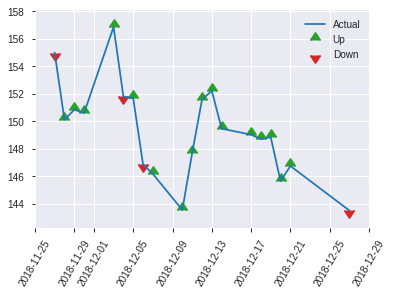


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20403290964100507
RMSE: 0.451700021741205
LogLoss: 0.5905012399446603
Mean Per-Class Error: 0.3140727835849787
AUC: 0.7485481997677119
pr_auc: 0.7119323566387393
Gini: 0.49709639953542384
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2733038365840912: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      53   73   0.5794   (73.0/126.0)
1      6    117  0.0488   (6.0/123.0)
Total  59   190  0.3173   (79.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.273304     0.747604  189
max f2                       0.244879     0.867052  199
max f0point5                 0.562193     0.681431  115
max accuracy                 0.562193     0.682731  115
max precision                0.875496     1         0
max recall                   0.119937     1         233
max specificity              0.875496     1         0
max absolute_mcc             0.273304     0.437228  189
max min_per_class_accuracy   0.52394      0.674603  123
max mean_per_class_accuracy  0.273304     0.685927  189

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.859085           2.02439   2.02439            1                0.869565  1                           0.869565            0.0243902       0.0243902                  102.439   102.439
    2        0.0200803                   0.852816           2.02439   2.02439            1                0.857839  1                           0.864875            0.0162602       0.0406504                  102.439   102.439
    3        0.0321285                   0.842705           1.34959   1.77134            0.666667         0.847484  0.875                       0.858353            0.0162602       0.0569106                  34.9593   77.1341
    4        0.0401606                   0.829119           2.02439   1.82195            1                0.838251  0.9                         0.854333            0.0162602       0.0731707                  102.439   82.1951
    5        0.0522088                   0.811952           0.674797  1.55722            0.333333         0.821571  0.769231                    0.846772            0.00813008      0.0813008                  -32.5203  55.7223
    6        0.100402                    0.772354           1.68699   1.61951            0.833333         0.792017  0.8                         0.82049             0.0813008       0.162602                   68.6992   61.9512
    7        0.15261                     0.744995           1.71295   1.65148            0.846154         0.759585  0.815789                    0.799654            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.717123           1.34959   1.57902            0.666667         0.729705  0.78                        0.782866            0.0650407       0.317073                   34.9593   57.9024
    9        0.301205                    0.670855           1.21463   1.45756            0.6              0.697147  0.72                        0.754293            0.121951        0.439024                   21.4634   45.7561
    10       0.401606                    0.614299           1.13366   1.37659            0.56             0.647065  0.68                        0.727486            0.113821        0.552846                   13.3659   37.6585
    11       0.502008                    0.515202           1.21463   1.3442             0.6              0.57295   0.664                       0.696579            0.121951        0.674797                   21.4634   34.4195
    12       0.598394                    0.42015            0.927846  1.27713            0.458333         0.472066  0.630872                    0.660416            0.0894309       0.764228                   -7.21545  27.7132
    13       0.698795                    0.325773           1.13366   1.25652            0.56             0.372634  0.62069                     0.619068            0.113821        0.878049                   13.3659   25.6518
    14       0.799197                    0.250633           0.890732  1.21057            0.44             0.285337  0.59799                     0.577142            0.0894309       0.96748                    -10.9268  21.0565
    15       0.899598                    0.180199           0.161951  1.09353            0.08             0.216453  0.540179                    0.536886            0.0162602       0.98374                    -83.8049  9.35322
    16       1                           0.0733588          0.161951  1                  0.08             0.120286  0.493976                    0.495059         

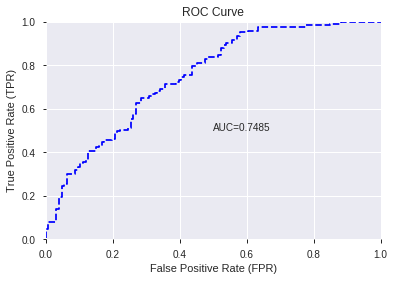

This function is available for GLM models only


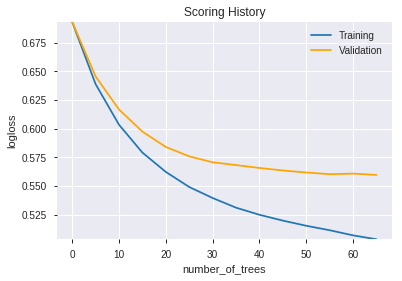

--2019-08-28 19:29:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_192857_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_192857_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'DIV',
 'TRANGE',
 'STOCH_slowk',
 'WILLR_12',
 'MOM_8',
 'CCI_8',
 'ULTOSC',
 'WILLR_14',
 'CMO_20',
 'STOCHRSI_fastd',
 'WILLR_20',
 'WILLR_30',
 'CCI_24',
 'CCI_14',
 'ADOSC',
 'WILLR_8',
 'CCI_12',
 'WILLR_24',
 'CCI_20',
 'CMO_12',
 'CMO_8',
 'CMO_14',
 'ROC_8',
 'STOCHRSI_fastk',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

77

['BBANDS_middleband_20_0_5',
 'MAVP_20_1',
 'BBANDS_upperband_20_1_2',
 'BBANDS_middleband_20_5_2',
 'BBANDS_upperband_20_5_3',
 'BBANDS_middleband_20_5_4',
 'BBANDS_middleband_20_5_5',
 'BBANDS_lowerband_24_7_5',
 'BBANDS_lowerband_30_5_5',
 'BOP',
 'aroondown_8',
 'AROONOSC_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROCP_8',
 'ADXR_12',
 'aroondown_12',
 'CCI_12',
 'DX_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'ROC_12',
 'WILLR_12',
 'ADX_14',
 'CCI_14',
 'DX_14',
 'MINUS_DM_14',
 'PLUS_DI_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'aroonup_20',
 'MACDFIX_20',
 'MACDFIX_signal_20',
 'MINUS_DM_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROCP_20',
 'aroonup_24',
 'DX_24',
 'MACDFIX_signal_24',
 'MFI_24',
 'MINUS_DI_24',
 'MOM_24',
 'PLUS_DM_24',
 'WILLR_24',
 'DX_30',
 'MFI_30',
 'MOM_30',
 'PLUS_DI_30',
 'PLUS_DM_30',
 'ROCR_30',
 'APO',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ATR_8',
 'ATR_12',
 'NATR_14',
 'ATR_30',
 'TRANGE'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_193134_model_8  0.733062  0.603885              0.314460  0.455960  0.207900
1  DeepLearning_grid_1_AutoML_20190828_193134_model_9  0.731062  0.612753              0.341947  0.461839  0.213295
2  DeepLearning_grid_1_AutoML_20190828_193134_model_6  0.727255  0.603721              0.342238  0.457468  0.209277
3  DeepLearning_grid_1_AutoML_20190828_193134_model_4  0.726997  0.721064              0.322493  0.483190  0.233473
4  DeepLearning_grid_1_AutoML_20190828_193134_model_5  0.720932  0.603887              0.318525  0.458429  0.210157
5  DeepLearning_grid_1_AutoML_20190828_193134_model_3  0.719770  0.668310              0.346303  0.475786  0.226373
6  DeepLearning_grid_1_AutoML_20190828_193134_model_1  0.700671  0.847481              0.358111  0.512680  0.262841
7  DeepLearning_grid_1_AutoML_20190828_193134_model_2  0.690218  0.704272              0.353755  0.488069  0.238211
8               DeepLearning_1_AutoML_20190828_193134  0.683379  0.678360              0.338366  0.484679  0.234913
9  DeepLearning_grid_1_AutoML_20190828_193134_model_7  0.675184  0.764228              0.373597  0.501050  0.251051

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.040486
1                CDLLONGLINE             0.676096           0.676096    0.027373
2                     TRANGE             0.545144           0.545144    0.022071
3               STOCHF_fastk             0.481240           0.481240    0.019484
4               CDLSHORTLINE             0.471536           0.471536    0.019091
..                       ...                  ...                ...         ...
72   BBANDS_upperband_20_1_2             0.255695           0.255695    0.010352
73                     ATR_8             0.254255           0.254255    0.010294
74                    MOM_24             0.251894           0.251894    0.010198
75   BBANDS_upperband_20_5_3             0.249407           0.249407    0.010098
76  BBANDS_middleband_20_5_2             0.247025           0.247025    0.010001

[77 rows x 4 columns]

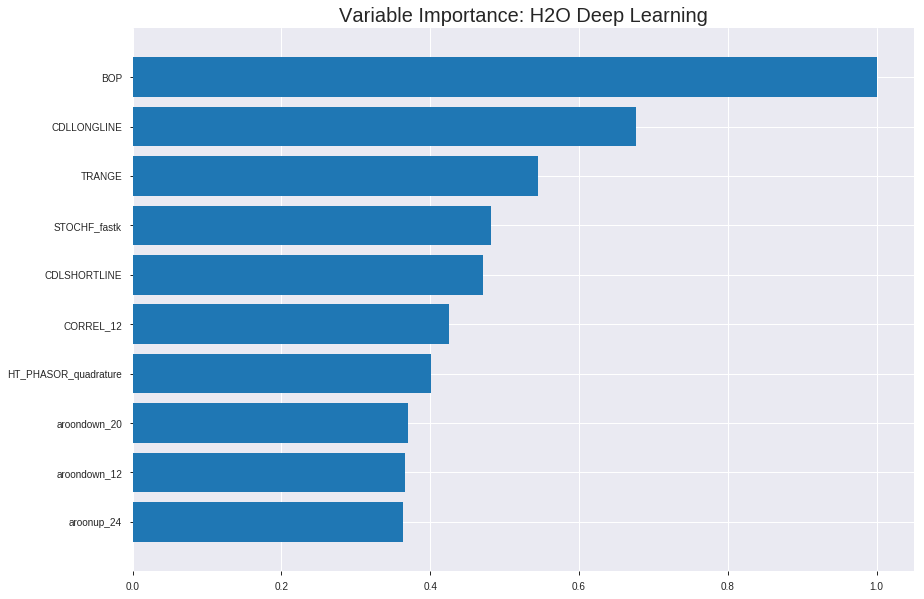

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_193134_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17515719372446836
RMSE: 0.4185178535313259
LogLoss: 0.528025226324593
Mean Per-Class Error: 0.2503565805316291
AUC: 0.8300321517881951
pr_auc: 0.8286975067428439
Gini: 0.6600643035763902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.426749869821664: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      463  363   0.4395   (363.0/826.0)
1      84   831   0.0918   (84.0/915.0)
Total  547  1194  0.2567   (447.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42675      0.788051  257
max f2                       0.291827     0.871353  320
max f0point5                 0.580004     0.767488  164
max accuracy                 0.483885     0.75359   226
max precision                0.964515     1         0
max recall                   0.152111     1         377
max specificity              0.964515     1         0
max absolute_mcc             0.483885     0.507592  226
max min_per_class_accuracy   0.524028     0.745355  201
max mean_per_class_accuracy  0.498026     0.749643  218

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.918365           1.69132   1.69132            0.888889         0.934109  0.888889                    0.934109            0.0174863       0.0174863                  69.1318   69.1318
    2        0.0201034                   0.911092           1.90273   1.794              1                0.914055  0.942857                    0.924369            0.0185792       0.0360656                  90.2732   79.4005
    3        0.0304423                   0.901104           1.90273   1.83093            1                0.906034  0.962264                    0.918142            0.0196721       0.0557377                  90.2732   83.0931
    4        0.0402068                   0.889697           1.79081   1.82119            0.941176         0.894198  0.957143                    0.912327            0.0174863       0.073224                   79.0807   82.1187
    5        0.0505457                   0.877161           1.69132   1.79462            0.888889         0.883563  0.943182                    0.906443            0.0174863       0.0907104                  69.1318   79.4622
    6        0.100517                    0.824762           1.72777   1.76139            0.908046         0.84945   0.925714                    0.878109            0.0863388       0.177049                   72.7768   76.1386
    7        0.150488                    0.770741           1.59655   1.70665            0.83908          0.796152  0.896947                    0.850895            0.0797814       0.256831                   59.6545   70.6649
    8        0.20046                     0.711069           1.66216   1.69556            0.873563         0.742189  0.891117                    0.823796            0.0830601       0.339891                   66.2157   69.5558
    9        0.300402                    0.627641           1.48719   1.62624            0.781609         0.666355  0.854685                    0.771416            0.148634        0.488525                   48.7193   62.6236
    10       0.400345                    0.567287           1.31223   1.54785            0.689655         0.593766  0.813486                    0.727067            0.131148        0.619672                   31.2229   54.7847
    11       0.500287                    0.527126           1.12633   1.46364            0.591954         0.547156  0.769231                    0.691126            0.112568        0.73224                    12.633    46.364
    12       0.60023                     0.482095           1.03885   1.39291            0.545977         0.506624  0.732057                    0.660405            0.103825        0.836066                   3.88481   39.2909
    13       0.700172                    0.415548           0.809208  1.30959            0.425287         0.449629  0.688269                    0.630319            0.0808743       0.91694                    -19.0792  30.9592
    14       0.800115                    0.32114            0.404604  1.19655            0.212644         0.369843  0.628859                    0.597783            0.0404372       0.957377                   -59.5396  19.6549
    15       0.900057                    0.230279           0.295252  1.09647            0.155172         0.273222  0.57626                     0.561744            0.0295082       0.986885                   -70.4748  9.64692
    16       1                           0.0544233          0.131223  1                  0.0689655        0.173723  0.52556                     0.522964          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19010164360061918
RMSE: 0.4360064719710238
LogLoss: 0.5619207105188451
Mean Per-Class Error: 0.27277138051494365
AUC: 0.7953486867641351
pr_auc: 0.8063286612265319
Gini: 0.5906973735282701
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4696322309609202: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      127  109  0.4619   (109.0/236.0)
1      36   226  0.1374   (36.0/262.0)
Total  163  335  0.2912   (145.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469632     0.757119  257
max f2                       0.274319     0.861373  348
max f0point5                 0.553962     0.749551  167
max accuracy                 0.512798     0.728916  212
max precision                0.943636     1         0
max recall                   0.162501     1         390
max specificity              0.943636     1         0
max absolute_mcc             0.512798     0.455619  212
max min_per_class_accuracy   0.524816     0.71374   197
max mean_per_class_accuracy  0.512798     0.727229  212

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 52.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.901884           1.90076   1.90076            1                0.922377  1                           0.922377            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.887756           1.90076   1.90076            1                0.894928  1                           0.908653            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.865725           1.52061   1.77405            0.8              0.879088  0.933333                    0.898798            0.0152672       0.0534351                  52.0611   77.4046
    4        0.0401606                   0.859054           1.90076   1.80573            1                0.864072  0.95                        0.890116            0.019084        0.0725191                  90.0763   80.5725
    5        0.0502008                   0.846708           1.52061   1.7487             0.8              0.855042  0.92                        0.883102            0.0152672       0.0877863                  52.0611   74.8702
    6        0.100402                    0.802697           1.90076   1.82473            1                0.825102  0.96                        0.854102            0.0954198       0.183206                   90.0763   82.4733
    7        0.150602                    0.738434           1.44458   1.69802            0.76             0.773844  0.893333                    0.827349            0.0725191       0.255725                   44.458    69.8015
    8        0.200803                    0.679519           1.59664   1.67267            0.84             0.711591  0.88                        0.79841             0.0801527       0.335878                   59.6641   67.2672
    9        0.301205                    0.604949           1.4826    1.60931            0.78             0.641711  0.846667                    0.746177            0.148855        0.484733                   48.2595   60.9313
    10       0.399598                    0.560658           1.12494   1.49005            0.591837         0.580241  0.78392                     0.705318            0.110687        0.59542                    12.4942   49.0046
    11       0.5                         0.528543           1.06443   1.40458            0.56             0.546745  0.738956                    0.673476            0.10687         0.70229                    6.44275   40.458
    12       0.600402                    0.494336           0.988397  1.33498            0.52             0.512066  0.702341                    0.646485            0.0992366       0.801527                   -1.16031  33.4984
    13       0.698795                    0.446709           0.737031  1.25079            0.387755         0.476467  0.658046                    0.622545            0.0725191       0.874046                   -26.2969  25.079
    14       0.799197                    0.356672           0.494198  1.15574            0.26             0.403204  0.60804                     0.59499             0.0496183       0.923664                   -50.5802  15.5741
    15       0.899598                    0.245571           0.570229  1.09039            0.3              0.31021   0.573661                    0.563206            0.0572519       0.980916                   -42.9771  9.03933
    16       1                           0.116128           0.190076  1                  0.1              0.192476  0.526104                    0.525985           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:38:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:38:30  1 min 51.275 sec  601 obs/sec       0.499713  1             870        0.555095         0.89826             -0.235751      0.747735        0.761017           1.79702          0.338311                         0.560979           0.929162              -0.262229        0.751051          0.766798             1.90076            0.355422
    2019-08-28 19:38:41  2 min  2.131 sec  949 obs/sec       6.15968   12            10724      0.434446         0.560082            0.243047       0.797999        0.792724           1.90273          0.281447                         0.436864           0.564594              0.234512         0.787828          0.787476             1.90076            0.283133
    2019-08-28 19:38:51  2 min 12.275 sec  1050 obs/sec      12.2981   24            21411      0.436666         0.561652            0.235294       0.791048        0.787434           1.69132          0.281447                         0.441099           0.566679              0.219601         0.789955          0.809796             1.90076            0.319277
    2019-08-28 19:39:02  2 min 23.077 sec  1159 obs/sec      20.0844   39            34967      0.418518         0.528025            0.297536       0.830032        0.828698           1.69132          0.256749                         0.436006           0.561921              0.237515         0.795349          0.806329             1.90076            0.291165
    2019-08-28 19:39:12  2 min 33.781 sec  1235 obs/sec      28.2504   55            49184      0.417147         0.524124            0.30213        0.839141        0.846404           1.90273          0.242389                         0.443344           0.575829              0.211636         0.787125          0.803969             1.90076            0.287149
    2019-08-28 19:39:23  2 min 44.267 sec  1286 obs/sec      36.4204   71            63408      0.401781         0.486936            0.352595       0.849323        0.855576           1.90273          0.237794                         0.43913            0.568413              0.22655          0.788119          0.786958             1.90076            0.279116
    2019-08-28 19:39:34  2 min 55.121 sec  1330 obs/sec      45.1505   88            78607      0.396991         0.477598            0.36794        0.859292        0.862741           1.90273          0.231476                         0.438986           0.569731              0.227059         0.791904          0.795558             1.90076            0.319277
    2019-08-28 19:39:35  2 min 56.206 sec  1329 obs/sec      45.1505   88            78607      0.418518         0.528025            0.297536       0.830032        0.828698           1.69132          0.256749                         0.436006           0.561921              0.237515         0.795349          0.806329             1.90076            0.291165

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.040486408091497714
CDLLONGLINE               0.6760958433151245     0.6760958433151245   0.027372692221421427
TRANGE                    0.5451441407203674     0.5451441407203674   0.022070928149893653
STOCHF_fastk              0.4812396764755249     0.4812396764755249   0.019483665931608433
CDLSHORTLINE              0.4715355932712555     0.4715355932712555   0.019090782458846534
---                       ---                    ---                  ---
BBANDS_upperband_20_1_2   0.25569480657577515    0.25569480657577515  0.010352164285903406
ATR_8                     0.2542553246021271     0.2542553246021271   0.010293884831277935
MOM_24                    0.25189417600631714    0.25189417600631714  0.010198290405663307
BBANDS_upperband_20_5_3   0.24940674006938934    0.24940674006938934  0.010097583059219392
BBANDS_middleband_20_5_2  0.2470250427722931     0.2470250427722931   0.010001156690498735


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6827309236947792)

('F1', 0.740983606557377)

('auc', 0.7330623306233062)

('logloss', 0.6038852878591611)

('mean_per_class_error', 0.3144599303135889)

('rmse', 0.4559602184090886)

('mse', 0.20789972077166383)

deeplearning prediction progress: |███████████████████████████████████████| 100%


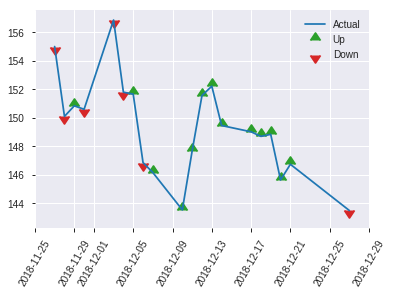


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20789972077166383
RMSE: 0.4559602184090886
LogLoss: 0.6038852878591611
Mean Per-Class Error: 0.3144599303135889
AUC: 0.7330623306233062
pr_auc: 0.692482238730717
Gini: 0.46612466124661234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41893674886948573: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   69   0.5476   (69.0/126.0)
1      10   113  0.0813   (10.0/123.0)
Total  67   182  0.3173   (79.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418937     0.740984  181
max f2                       0.244421     0.858939  223
max f0point5                 0.558884     0.66855   101
max accuracy                 0.436128     0.682731  175
max precision                0.95203      1         0
max recall                   0.244421     1         223
max specificity              0.95203      1         0
max absolute_mcc             0.418937     0.418343  181
max min_per_class_accuracy   0.534699     0.658537  123
max mean_per_class_accuracy  0.418937     0.68554   181

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 52.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.935407           1.34959   1.34959            0.666667         0.947947  0.666667                    0.947947            0.0162602       0.0162602                  34.9593   34.9593
    2        0.0200803                   0.915686           1.0122    1.21463            0.5              0.92396   0.6                         0.938352            0.00813008      0.0243902                  1.21951   21.4634
    3        0.0321285                   0.896951           2.02439   1.51829            1                0.907228  0.75                        0.92668             0.0243902       0.0487805                  102.439   51.8293
    4        0.0401606                   0.885568           2.02439   1.61951            1                0.895065  0.8                         0.920357            0.0162602       0.0650407                  102.439   61.9512
    5        0.0522088                   0.851724           1.34959   1.55722            0.666667         0.867462  0.769231                    0.908151            0.0162602       0.0813008                  34.9593   55.7223
    6        0.100402                    0.800157           1.68699   1.61951            0.833333         0.821323  0.8                         0.866473            0.0813008       0.162602                   68.6992   61.9512
    7        0.15261                     0.731694           1.71295   1.65148            0.846154         0.770726  0.815789                    0.833718            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.673575           0.843496  1.45756            0.416667         0.699896  0.72                        0.8016              0.0406504       0.292683                   -15.6504  45.7561
    9        0.301205                    0.596787           1.29561   1.40358            0.64             0.633959  0.693333                    0.74572             0.130081        0.422764                   29.561    40.3577
    10       0.401606                    0.560793           1.37659   1.39683            0.68             0.575893  0.69                        0.703263            0.138211        0.560976                   37.6585   39.6829
    11       0.502008                    0.530607           0.971707  1.3118             0.48             0.547808  0.648                       0.672172            0.097561        0.658537                   -2.82927  31.1805
    12       0.598394                    0.483561           1.0122    1.26355            0.5              0.50727   0.624161                    0.645611            0.097561        0.756098                   1.21951   26.3546
    13       0.698795                    0.439798           1.21463   1.25652            0.6              0.463829  0.62069                     0.619493            0.121951        0.878049                   21.4634   25.6518
    14       0.799197                    0.345402           0.647805  1.18005            0.32             0.397622  0.582915                    0.59162             0.0650407       0.943089                   -35.2195  18.0047
    15       0.899598                    0.244371           0.566829  1.11161            0.28             0.285447  0.549107                    0.557449            0.0569106       1                          -43.3171  11.1607
    16       1                           0.125182           0         1                  0                0.197416  0.493976                    0.521301         

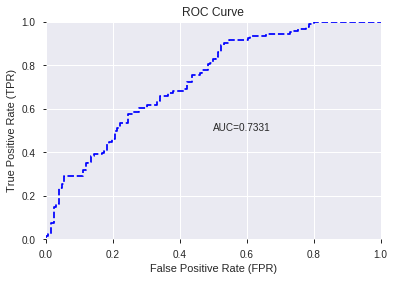

This function is available for GLM models only


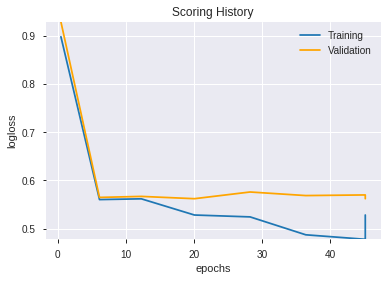

--2019-08-28 19:41:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_193134_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_193134_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLLONGLINE',
 'TRANGE',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'aroondown_20',
 'aroondown_12',
 'aroonup_24',
 'ADXR_12',
 'CDLSPINNINGTOP',
 'BETA_8',
 'aroonup_20',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'STOCHF_fastd',
 'aroondown_8',
 'CDLDOJI',
 'WILLR_12',
 'DX_24',
 'MFI_24',
 'AROONOSC_8',
 'MACDEXT_hist',
 'DX_30',
 'CCI_8',
 'DX_12',
 'ADX_14',
 'DX_14',
 'PLUS_DI_8',
 'MFI_30',
 'MACDFIX_signal_24',
 'CCI_14',
 'ROC_12',
 'MINUS_DM_14',
 'PLUS_DM_24',
 'WILLR_24',
 'NATR_14',
 'LINEARREG_SLOPE_8',
 'MINUS_DM_8',
 'MINUS_DI_12',
 'MACDFIX_signal_20',
 'PLUS_DM_30',
 'CCI_12',
 'MACDFIX_20',
 'WILLR_14',
 'STDDEV_8',
 'ROCP_8',
 'ATR_30',
 'VAR_8',
 'PLUS_DI_12',
 'CMO_8',
 'ATR_12',
 'PLUS_DI_20',
 'MINUS_DI_24',
 'BBANDS_lowerband_30_5_5',
 'LINEARREG_INTERCEPT_8',
 'BBANDS_middleband_20_5_4',
 'APO',
 'MAVP_20_1',
 'BBANDS_lowerband_24_7_5',
 'MOM_8',
 'ROCR_30',
 'BBANDS_middleband_20_0_5',
 'MOM_20',
 'MOM_30',
 'PLUS_DI_30',
 '

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_194200_model_1  0.742935  0.596976              0.299458  0.454671  0.206726

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.834121           1.000000    0.105546
1              STOCHF_fastk             0.545491           0.653971    0.069024
2                    TRANGE             0.374681           0.449192    0.047411
3                MINUS_DM_8             0.355525           0.426227    0.044987
4   BBANDS_lowerband_30_5_5             0.245981           0.294899    0.031125
..                      ...                  ...                ...         ...
72                   ROCP_8             0.004219           0.005058    0.000534
73              MINUS_DI_24             0.003038           0.003642    0.000384
74               PLUS_DM_24             0.001553           0.001862    0.000196
75                MAVP_20_1             0.001513           0.001814    0.000191
76        MACDFIX_signal_20             0.000725           0.000869    0.000092

[77 rows x 4 columns]

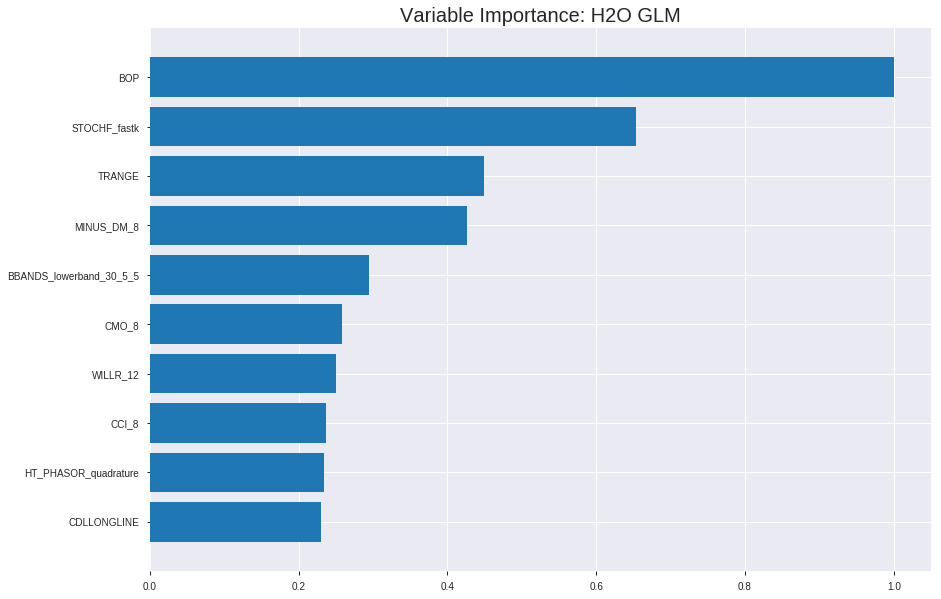

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_194200_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1785245061080437
RMSE: 0.42252160430922786
LogLoss: 0.534521325275123
Null degrees of freedom: 1740
Residual degrees of freedom: 1663
Null deviance: 2408.986814961971
Residual deviance: 1861.2032546079784
AIC: 2017.2032546079784
AUC: 0.8068749255745644
pr_auc: 0.8020428968159442
Gini: 0.6137498511491288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3896628681966407: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      472  354   0.4286   (354.0/826.0)
1      116  799   0.1268   (116.0/915.0)
Total  588  1153  0.27     (470.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389663     0.772727  251
max f2                       0.191848     0.864436  333
max f0point5                 0.622557     0.754525  155
max accuracy                 0.469967     0.738656  218
max precision                0.958397     1         0
max recall                   0.0426797    1         391
max specificity              0.958397     1         0
max absolute_mcc             0.421511     0.476706  240
max min_per_class_accuracy   0.546668     0.731235  188
max mean_per_class_accuracy  0.469967     0.735174  218

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.932791           1.69132   1.69132            0.888889         0.945135  0.888889                    0.945135            0.0174863       0.0174863                  69.1318   69.1318
    2        0.0201034                   0.920453           1.79081   1.73964            0.941176         0.925534  0.914286                    0.935615            0.0174863       0.0349727                  79.0807   73.9641
    3        0.0304423                   0.911277           1.79702   1.75913            0.944444         0.915809  0.924528                    0.928888            0.0185792       0.0535519                  79.7025   75.913
    4        0.0402068                   0.894553           1.79081   1.76682            0.941176         0.901709  0.928571                    0.922287            0.0174863       0.0710383                  79.0807   76.6823
    5        0.0505457                   0.886409           1.58561   1.72976            0.833333         0.889651  0.909091                    0.915612            0.0163934       0.0874317                  58.561    72.9757
    6        0.100517                    0.844866           1.72777   1.72877            0.908046         0.864909  0.908571                    0.890405            0.0863388       0.17377                    72.7768   72.8768
    7        0.150488                    0.809432           1.57467   1.6776             0.827586         0.825809  0.881679                    0.868955            0.0786885       0.252459                   57.4675   67.76
    8        0.20046                     0.779587           1.48719   1.63013            0.781609         0.794174  0.856734                    0.850314            0.0743169       0.326776                   48.7193   63.0134
    9        0.300402                    0.716141           1.48719   1.58258            0.781609         0.748591  0.83174                     0.816471            0.148634        0.47541                    48.7193   58.2578
    10       0.400345                    0.644483           1.27942   1.5069             0.672414         0.681169  0.791966                    0.782694            0.127869        0.603279                   27.9423   50.6898
    11       0.500287                    0.563051           1.17007   1.43961            0.614943         0.604271  0.756602                    0.747051            0.11694         0.720219                   17.0071   43.961
    12       0.60023                     0.447154           0.951366  1.35831            0.5              0.50277   0.713876                    0.706376            0.095082        0.815301                   -4.86339  35.8314
    13       0.700172                    0.352042           0.820143  1.2815             0.431034         0.401004  0.673503                    0.662787            0.0819672       0.897268                   -17.9857  28.1496
    14       0.800115                    0.258576           0.481151  1.18152            0.252874         0.303426  0.620962                    0.617899            0.0480874       0.945355                   -51.8849  18.1524
    15       0.900057                    0.161626           0.404604  1.09525            0.212644         0.209864  0.575622                    0.572591            0.0404372       0.985792                   -59.5396  9.52549
    16       1                           0.0188781          0.142158  1                  0.0747126        0.102011  0.52556                     0.52556             0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1809470996524008
RMSE: 0.42537877198139634
LogLoss: 0.536848909606452
Null degrees of freedom: 497
Residual degrees of freedom: 420
Null deviance: 689.0171367028406
Residual deviance: 534.7015139680262
AIC: 690.7015139680262
AUC: 0.8022464096260835
pr_auc: 0.814460498018475
Gini: 0.604492819252167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43326261435680735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  94   0.3983   (94.0/236.0)
1      43   219  0.1641   (43.0/262.0)
Total  185  313  0.2751   (137.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433263     0.761739  252
max f2                       0.19056      0.871622  347
max f0point5                 0.649198     0.757426  148
max accuracy                 0.463099     0.728916  240
max precision                0.960889     1         0
max recall                   0.0675995    1         394
max specificity              0.960889     1         0
max absolute_mcc             0.463099     0.457272  240
max min_per_class_accuracy   0.542183     0.709924  202
max mean_per_class_accuracy  0.463099     0.724285  240

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 52.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.934013           1.90076    1.90076            1                0.943325  1                           0.943325            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.924135           1.90076    1.90076            1                0.931259  1                           0.937292            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.917539           1.90076    1.90076            1                0.920544  1                           0.931709            0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.908043           1.90076    1.90076            1                0.914496  1                           0.927406            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.902033           1.90076    1.90076            1                0.90582   1                           0.923089            0.019084        0.0954198                  90.0763   90.0763
    6        0.100402                    0.856302           1.67267    1.78672            0.88             0.87645   0.94                        0.899769            0.0839695       0.179389                   67.2672   78.6718
    7        0.150602                    0.797759           1.67267    1.7487             0.88             0.829848  0.92                        0.876462            0.0839695       0.263359                   67.2672   74.8702
    8        0.200803                    0.768247           1.44458    1.67267            0.76             0.78236   0.88                        0.852937            0.0725191       0.335878                   44.458    67.2672
    9        0.301205                    0.70331            1.44458    1.59664            0.76             0.740818  0.84                        0.815564            0.145038        0.480916                   44.458    59.6641
    10       0.399598                    0.630631           1.28011    1.5187             0.673469         0.667092  0.798995                    0.779005            0.125954        0.60687                    28.0106   51.87
    11       0.5                         0.546002           0.950382   1.40458            0.5              0.592106  0.738956                    0.741475            0.0954198       0.70229                    -4.96183  40.458
    12       0.600402                    0.463005           1.10244    1.35406            0.58             0.502665  0.712375                    0.70154             0.110687        0.812977                   10.2443   35.4056
    13       0.698795                    0.359216           0.581866   1.24533            0.306122         0.406355  0.655172                    0.659977            0.0572519       0.870229                   -41.8134  24.5328
    14       0.799197                    0.273186           0.760305   1.1844             0.4              0.319359  0.623116                    0.617186            0.0763359       0.946565                   -23.9695  18.4395
    15       0.899598                    0.170614           0.456183   1.10312            0.24             0.21576   0.580357                    0.572384            0.0458015       0.992366                   -54.3817  10.3122
    16       1                           0.0572857          0.0760305  1                  0.04             0.113268  0.526104                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:42:00  0.000 sec   2            .24E2     78            1.3670500040330178  1.3674340275274504
     2019-08-28 19:42:00  0.014 sec   4            .15E2     78            1.3587718074653474  1.3593065979062844
     2019-08-28 19:42:00  0.029 sec   6            .93E1     78            1.3472211312590086  1.3478988473301485
     2019-08-28 19:42:00  0.046 sec   8            .58E1     78            1.3317095644369226  1.3325028012938265
     2019-08-28 19:42:00  0.061 sec   10           .36E1     78            1.3116188305879497  1.312478029130183
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:42:00  0.271 sec   38           .45E-2    78            1.0662579433157113  1.0741003757557692
     2019-08-28 19:42:00  0.286 sec   40           .28E-2    78            1.0640137164961017  1.0751384515139286
     2019-08-28 19:42:01  0.301 sec   42           .18E-2    78            1.0621279517249929  1.0764830183147824
     2019-08-28 19:42:01  0.317 sec   44           .11E-2    78            1.060551419637669   1.0779346887123098
     2019-08-28 19:42:01  0.331 sec   46           .68E-3    78            1.059269721795605   1.0793072247484277


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6987951807228916)

('F1', 0.7349823321554771)

('auc', 0.7429345722028649)

('logloss', 0.5969758970809038)

('mean_per_class_error', 0.2994579945799458)

('rmse', 0.4546709506137908)

('mse', 0.2067256733320482)

glm prediction progress: |████████████████████████████████████████████████| 100%


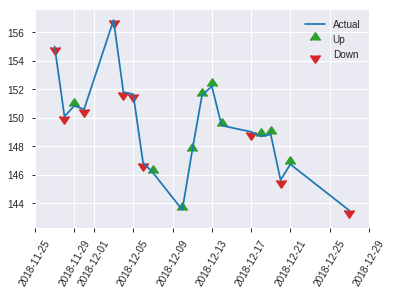


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2067256733320482
RMSE: 0.4546709506137908
LogLoss: 0.5969758970809038
Null degrees of freedom: 248
Residual degrees of freedom: 171
Null deviance: 346.14583701949294
Residual deviance: 297.29399674628996
AIC: 453.29399674628996
AUC: 0.7429345722028649
pr_auc: 0.7119095599548416
Gini: 0.4858691444057297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3756036286460213: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   56   0.4444   (56.0/126.0)
1      19   104  0.1545   (19.0/123.0)
Total  89   160  0.3012   (75.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375604     0.734982  159
max f2                       0.208814     0.851216  206
max f0point5                 0.375604     0.68152   159
max accuracy                 0.375604     0.698795  159
max precision                0.940759     1         0
max recall                   0.0905682    1         242
max specificity              0.940759     1         0
max absolute_mcc             0.375604     0.418426  159
max min_per_class_accuracy   0.508772     0.642857  124
max mean_per_class_accuracy  0.375604     0.700542  159

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 49.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.908909           2.02439   2.02439            1                0.923893  1                           0.923893            0.0243902       0.0243902                  102.439   102.439
    2        0.0200803                   0.900148           2.02439   2.02439            1                0.904887  1                           0.916291            0.0162602       0.0406504                  102.439   102.439
    3        0.0321285                   0.887852           1.34959   1.77134            0.666667         0.8938    0.875                       0.907857            0.0162602       0.0569106                  34.9593   77.1341
    4        0.0401606                   0.869581           2.02439   1.82195            1                0.879571  0.9                         0.9022              0.0162602       0.0731707                  102.439   82.1951
    5        0.0522088                   0.861175           2.02439   1.86867            1                0.866788  0.923077                    0.894028            0.0243902       0.097561                   102.439   86.8668
    6        0.100402                    0.812724           1.51829   1.70049            0.75             0.840519  0.84                        0.868344            0.0731707       0.170732                   51.8293   70.0488
    7        0.15261                     0.784405           1.24578   1.54493            0.615385         0.798789  0.763158                    0.844549            0.0650407       0.235772                   24.5779   54.4929
    8        0.200803                    0.755637           1.51829   1.53854            0.75             0.769717  0.76                        0.826589            0.0731707       0.308943                   51.8293   53.8537
    9        0.301205                    0.670095           1.29561   1.45756            0.64             0.712089  0.72                        0.788422            0.130081        0.439024                   29.561    45.7561
    10       0.401606                    0.596542           1.29561   1.41707            0.64             0.627669  0.7                         0.748234            0.130081        0.569106                   29.561    41.7073
    11       0.502008                    0.508772           0.809756  1.29561            0.4              0.556255  0.64                        0.709838            0.0813008       0.650407                   -19.0244  29.561
    12       0.598394                    0.420887           1.34959   1.30431            0.666667         0.455906  0.644295                    0.668936            0.130081        0.780488                   34.9593   30.4305
    13       0.698795                    0.347383           0.971707  1.25652            0.48             0.373895  0.62069                     0.626545            0.097561        0.878049                   -2.82927  25.6518
    14       0.799197                    0.257351           0.647805  1.18005            0.32             0.301479  0.582915                    0.585708            0.0650407       0.943089                   -35.2195  18.0047
    15       0.899598                    0.150462           0.323902  1.08449            0.16             0.193001  0.535714                    0.541879            0.0325203       0.97561                    -67.6098  8.44948
    16       1                           0.0393217          0.242927  1                  0.12             0.102397  0.493976                    0.497754          

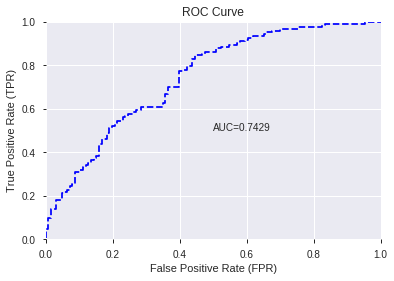

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


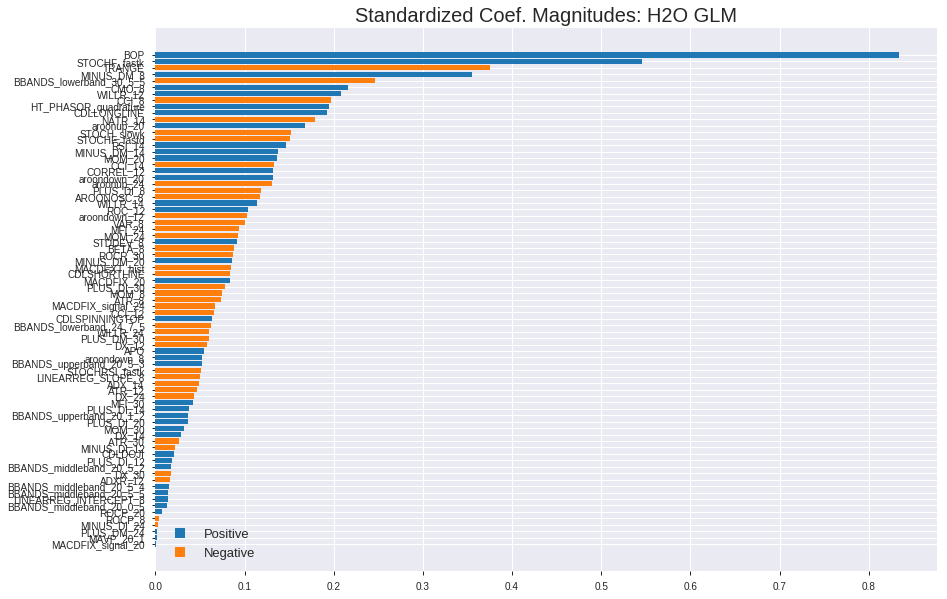

'log_likelihood'
--2019-08-28 19:42:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.148
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.148|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_194200_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_194200_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'MINUS_DM_8',
 'BBANDS_lowerband_30_5_5',
 'CMO_8',
 'WILLR_12',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'CDLLONGLINE',
 'NATR_14',
 'aroonup_20',
 'STOCH_slowk',
 'STOCHF_fastd',
 'RSI_14',
 'MINUS_DM_14',
 'MOM_20',
 'CCI_14',
 'CORREL_12',
 'aroondown_20',
 'aroonup_24',
 'PLUS_DI_8',
 'AROONOSC_8',
 'WILLR_14',
 'ROC_12',
 'aroondown_12',
 'VAR_8',
 'MFI_24',
 'MOM_24',
 'STDDEV_8',
 'BETA_8',
 'ROCR_30',
 'MINUS_DM_20',
 'MACDEXT_hist',
 'CDLSHORTLINE',
 'MACDFIX_20',
 'PLUS_DI_30',
 'MOM_8',
 'ATR_8',
 'MACDFIX_signal_24',
 'CCI_12',
 'CDLSPINNINGTOP',
 'BBANDS_lowerband_24_7_5',
 'WILLR_24',
 'PLUS_DM_30',
 'DX_12',
 'APO',
 'aroondown_8',
 'BBANDS_upperband_20_5_3',
 'STOCHRSI_fastk',
 'LINEARREG_SLOPE_8',
 'ADX_14',
 'ATR_12',
 'DX_24',
 'MFI_30',
 'PLUS_DI_14',
 'BBANDS_upperband_20_1_2',
 'PLUS_DI_20',
 'MOM_30',
 'DX_14',
 'ATR_30',
 'MINUS_DI_12',
 'CDLDOJI',
 'PLUS_DI_12',
 'BBANDS_middleband_20_5_2',
 'DX_30',
 'ADXR_12',
 'BBANDS_middleb

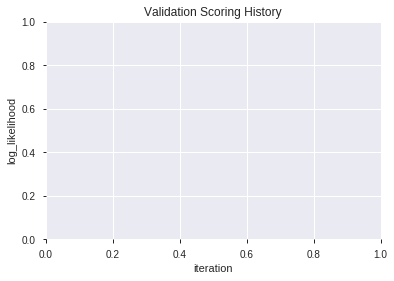

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_194308_model_4  0.735256  0.602751              0.346012  0.456768  0.208637
1  XGBoost_grid_1_AutoML_20190828_194308_model_7  0.727320  0.616152              0.310492  0.461049  0.212566
2               XGBoost_1_AutoML_20190828_194308  0.727191  0.614220              0.330623  0.461672  0.213141
3               XGBoost_2_AutoML_20190828_194308  0.725384  0.613750              0.338269  0.460569  0.212123
4  XGBoost_grid_1_AutoML_20190828_194308_model_3  0.724158  0.609018              0.330139  0.459562  0.211197
5  XGBoost_grid_1_AutoML_20190828_194308_model_2  0.723771  0.613379              0.334108  0.460776  0.212314
6  XGBoost_grid_1_AutoML_20190828_194308_model_1  0.722738  0.610472              0.345916  0.459925  0.211531
7               XGBoost_3_AutoML_20190828_194308  0.721964  0.612744              0.342334  0.461284  0.212783
8  XGBoost_grid_1_AutoML_20190828_194308_model_6  0.717964  0.615617              0.322396  0.461846  0.213302
9  XGBoost_grid_1_AutoML_20190828_194308_model_5  0.701187  0.659348              0.373500  0.477825  0.228317

variable  relative_importance  scaled_importance  percentage
0                       BOP          3134.459229           1.000000    0.519438
1                    TRANGE           357.170044           0.113949    0.059190
2              STOCHF_fastk           267.334015           0.085289    0.044302
3                 CORREL_12           201.028656           0.064135    0.033314
4                  WILLR_12            89.585060           0.028581    0.014846
..                      ...                  ...                ...         ...
61                  CDLDOJI             6.070086           0.001937    0.001006
62                    CMO_8             5.248179           0.001674    0.000870
63                      APO             5.160691           0.001646    0.000855
64        MACDFIX_signal_24             4.872195           0.001554    0.000807
65  BBANDS_lowerband_24_7_5             4.499733           0.001436    0.000746

[66 rows x 4 columns]

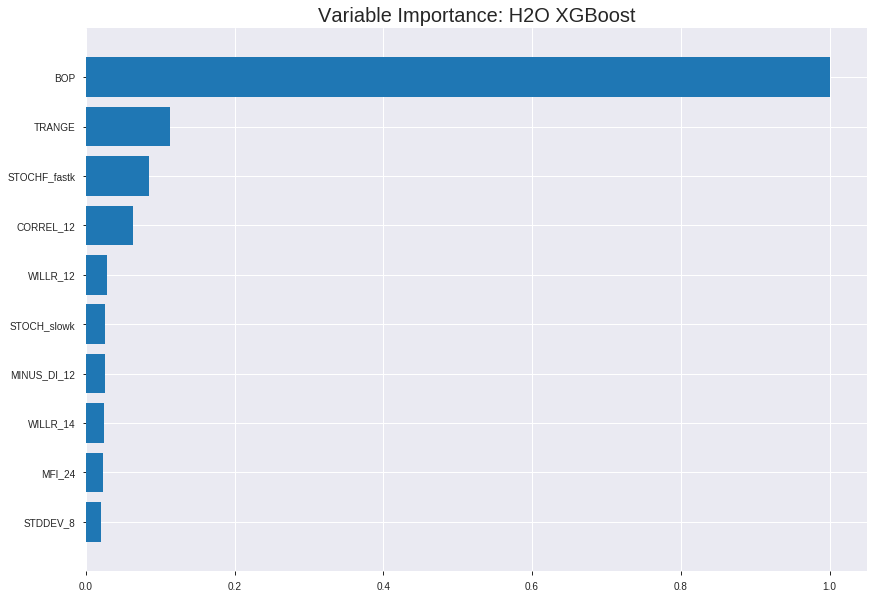

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_194308_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16143443361217993
RMSE: 0.40178904117979614
LogLoss: 0.49503530427032016
Mean Per-Class Error: 0.23100067479061637
AUC: 0.8509883697852578
pr_auc: 0.8607127526015383
Gini: 0.7019767395705157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41755173802375795: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      523  303   0.3668   (303.0/826.0)
1      116  799   0.1268   (116.0/915.0)
Total  639  1102  0.2407   (419.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417552     0.792266  241
max f2                       0.232988     0.875834  330
max f0point5                 0.609804     0.795766  156
max accuracy                 0.529546     0.768524  193
max precision                0.913086     1         0
max recall                   0.122708     1         386
max specificity              0.913086     1         0
max absolute_mcc             0.596329     0.539066  162
max min_per_class_accuracy   0.54578      0.766344  186
max mean_per_class_accuracy  0.596329     0.768999  162

Gains/Lift Table: Avg response rate: 52.56 %, avg score: 52.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.878589           1.90273    1.90273            1                0.888166  1                           0.888166            0.0196721       0.0196721                  90.2732   90.2732
    2        0.0201034                   0.870371           1.90273    1.90273            1                0.875277  1                           0.881906            0.0185792       0.0382514                  90.2732   90.2732
    3        0.0304423                   0.864471           1.79702    1.86683            0.944444         0.867656  0.981132                    0.877066            0.0185792       0.0568306                  79.7025   86.6832
    4        0.0402068                   0.857539           1.90273    1.87555            1                0.860178  0.985714                    0.872965            0.0185792       0.0754098                  90.2732   87.555
    5        0.0505457                   0.85117            1.90273    1.88111            1                0.854435  0.988636                    0.869175            0.0196721       0.095082                   90.2732   88.111
    6        0.100517                    0.828129           1.74964    1.81575            0.91954          0.837895  0.954286                    0.853624            0.0874317       0.182514                   74.9639   81.575
    7        0.150488                    0.800682           1.77151    1.80106            0.931034         0.814244  0.946565                    0.840548            0.0885246       0.271038                   77.1509   80.106
    8        0.20046                     0.771852           1.61842    1.75553            0.850575         0.785157  0.922636                    0.82674             0.0808743       0.351913                   61.8416   75.5529
    9        0.300402                    0.714228           1.54187    1.68445            0.810345         0.742223  0.885277                    0.798621            0.154098        0.506011                   54.1869   68.4446
    10       0.400345                    0.644382           1.32316    1.59425            0.695402         0.682683  0.837877                    0.769678            0.13224         0.638251                   32.3164   59.4255
    11       0.500287                    0.557766           1.1482     1.50515            0.603448         0.602683  0.791045                    0.736318            0.114754        0.753005                   14.82     50.5146
    12       0.60023                     0.445159           0.91856    1.40748            0.482759         0.503549  0.739713                    0.69756             0.0918033       0.844809                   -8.14396  40.7476
    13       0.700172                    0.354736           0.66705    1.30179            0.350575         0.400488  0.684167                    0.655156            0.0666667       0.911475                   -33.295   30.1787
    14       0.800115                    0.261892           0.535827   1.20611            0.281609         0.308199  0.633884                    0.611817            0.0535519       0.965027                   -46.4173  20.6111
    15       0.900057                    0.167569           0.273381   1.10254            0.143678         0.207006  0.579451                    0.566867            0.0273224       0.99235                    -72.6619  10.254
    16       1                           0.08754            0.0765467  1                  0.0402299        0.13545   0.52556                     0.52



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1905735847425294
RMSE: 0.4365473453619085
LogLoss: 0.5621321522944692
Mean Per-Class Error: 0.27704101436149564
AUC: 0.7818039203001681
pr_auc: 0.7920140177771052
Gini: 0.5636078406003362
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43636852502822876: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  103  0.4364   (103.0/236.0)
1      43   219  0.1641   (43.0/262.0)
Total  176  322  0.2932   (146.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436369     0.75      250
max f2                       0.191107     0.863575  351
max f0point5                 0.590794     0.744592  180
max accuracy                 0.590794     0.720884  180
max precision                0.89848      1         0
max recall                   0.135897     1         386
max specificity              0.89848      1         0
max absolute_mcc             0.590794     0.446015  180
max min_per_class_accuracy   0.544725     0.711864  200
max mean_per_class_accuracy  0.590794     0.722959  180

Gains/Lift Table: Avg response rate: 52.61 %, avg score: 53.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.881771           1.90076   1.90076            1                0.886585  1                           0.886585            0.019084        0.019084                   90.0763   90.0763
    2        0.0200803                   0.876303           1.90076   1.90076            1                0.879957  1                           0.883271            0.019084        0.0381679                  90.0763   90.0763
    3        0.0301205                   0.866819           1.90076   1.90076            1                0.871657  1                           0.8794              0.019084        0.0572519                  90.0763   90.0763
    4        0.0401606                   0.861389           1.90076   1.90076            1                0.864312  1                           0.875628            0.019084        0.0763359                  90.0763   90.0763
    5        0.0502008                   0.852526           1.14046   1.7487             0.6              0.857015  0.92                        0.871905            0.0114504       0.0877863                  14.0458   74.8702
    6        0.100402                    0.8287             1.7487    1.7487             0.92             0.840952  0.92                        0.856429            0.0877863       0.175573                   74.8702   74.8702
    7        0.150602                    0.798323           1.59664   1.69802            0.84             0.813467  0.893333                    0.842108            0.0801527       0.255725                   59.6641   69.8015
    8        0.200803                    0.763631           1.36855   1.61565            0.72             0.779719  0.85                        0.826511            0.0687023       0.324427                   36.855    61.5649
    9        0.301205                    0.710417           1.40656   1.54595            0.74             0.738383  0.813333                    0.797135            0.141221        0.465649                   40.6565   54.5954
    10       0.399598                    0.645629           1.16373   1.45184            0.612245         0.678848  0.763819                    0.768009            0.114504        0.580153                   16.3733   45.1839
    11       0.5                         0.555072           1.17847   1.39695            0.62             0.609137  0.73494                     0.736107            0.118321        0.698473                   17.8473   39.6947
    12       0.600402                    0.469854           0.874351  1.30956            0.46             0.506166  0.688963                    0.697655            0.0877863       0.78626                    -12.5649  30.9556
    13       0.698795                    0.386581           0.737031  1.22894            0.387755         0.429391  0.646552                    0.659883            0.0725191       0.858779                   -26.2969  22.8942
    14       0.799197                    0.26517            0.684275  1.16052            0.36             0.333658  0.610553                    0.6189              0.0687023       0.927481                   -31.5725  16.0516
    15       0.899598                    0.176702           0.532214  1.09039            0.28             0.213865  0.573661                    0.573695            0.0534351       0.980916                   -46.7786  9.03933
    16       1                           0.098315           0.190076  1                  0.1              0.144001  0.526104                    0.530553         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:43:19  4.317 sec   0                  0.5              0.693147            0.5             0                  1                0.47444                          0.5                0.693147              0.5               0                    1                  0.473896
    2019-08-28 19:43:19  4.461 sec   5                  0.472714         0.639686            0.807945        0.754202           1.7387           0.265365                         0.474983           0.643997              0.784189          0.729719             1.81025            0.291165
    2019-08-28 19:43:19  4.536 sec   10                 0.454378         0.604239            0.81569         0.819551           1.90273          0.26996                          0.46065            0.615898              0.779063          0.786785             1.90076            0.297189
    2019-08-28 19:43:19  4.611 sec   15                 0.441493         0.578979            0.823401        0.830982           1.79702          0.26479                          0.451958           0.598304              0.780696          0.800439             1.90076            0.295181
    2019-08-28 19:43:19  4.683 sec   20                 0.432778         0.561242            0.823978        0.830607           1.79702          0.26479                          0.445893           0.585367              0.781214          0.800505             1.90076            0.311245
    2019-08-28 19:43:19  4.765 sec   25                 0.426282         0.547778            0.827459        0.833813           1.90273          0.259621                         0.442916           0.578338              0.779006          0.798559             1.90076            0.307229
    2019-08-28 19:43:19  4.838 sec   30                 0.421348         0.537316            0.830718        0.839071           1.90273          0.255026                         0.441559           0.574844              0.77806           0.79566              1.90076            0.313253
    2019-08-28 19:43:20  4.913 sec   35                 0.417444         0.528683            0.833402        0.842423           1.90273          0.2556                           0.440326           0.571512              0.778173          0.794696             1.90076            0.311245
    2019-08-28 19:43:20  4.996 sec   40                 0.414012         0.521316            0.836928        0.845769           1.90273          0.253877                         0.439364           0.56909               0.779232          0.794371             1.90076            0.305221
    2019-08-28 19:43:20  5.092 sec   45                 0.411069         0.51498             0.839719        0.848794           1.90273          0.260195                         0.438425           0.566726              0.780025          0.796782             1.90076            0.305221
    2019-08-28 19:43:20  5.172 sec   50                 0.4085           0.509525            0.842972        0.853061           1.90273          0.255026                         0.438414           0.56639               0.779006          0.791574             1.90076            0.305221
    2019-08-28 19:43:20  5.260 sec   55                 0.40628          0.504567            0.8445          0.853875           1.90273          0.24641                          0.437775           0.56469               0.780397          0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      3134.459228515625      1.0                    0.5194384425132469
TRANGE                   357.1700439453125      0.1139494942846828     0.05918974783640776
STOCHF_fastk             267.3340148925781      0.08528871980867289    0.04430223978136575
CORREL_12                201.02865600585938     0.06413503617370701    0.03331420330060112
WILLR_12                 89.5850601196289       0.02858070677858311    0.014845917814995007
---                      ---                    ---                    ---
CDLDOJI                  6.0700860023498535     0.0019365656273744045  0.0010059266333080495
CMO_8                    5.248178958892822      0.0016743490906334692  0.0008697212838621205
APO                      5.160690784454346      0.0016464373623064404  0.0008552228591720758
MACDFIX_signal_24        4.872195243835449      0.001554397389990221   0.0008074137593031764
BBANDS_lowerband_24_7_5  4.499732971191406      0.0014355691502557298  0.0007456898035289016


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6827309236947792)

('F1', 0.7255520504731862)

('auc', 0.7352561620854303)

('logloss', 0.6027506179570044)

('mean_per_class_error', 0.3167828106852497)

('rmse', 0.45676783842692714)

('mse', 0.2086368582212074)

xgboost prediction progress: |████████████████████████████████████████████| 100%


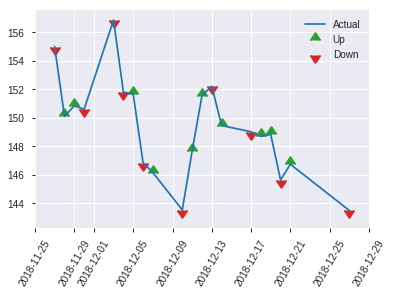


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2086368582212074
RMSE: 0.45676783842692714
LogLoss: 0.6027506179570044
Mean Per-Class Error: 0.3167828106852497
AUC: 0.7352561620854303
pr_auc: 0.7020484380818306
Gini: 0.47051232417086064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2843456268310547: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   79   0.627    (79.0/126.0)
1      8    115  0.065    (8.0/123.0)
Total  55   194  0.3494   (87.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284346     0.725552  193
max f2                       0.199826     0.851064  212
max f0point5                 0.528518     0.676516  129
max accuracy                 0.528518     0.682731  129
max precision                0.862846     1         0
max recall                   0.113118     1         245
max specificity              0.862846     1         0
max absolute_mcc             0.345456     0.371627  175
max min_per_class_accuracy   0.559242     0.666667  123
max mean_per_class_accuracy  0.507126     0.683217  133

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.8481             2.02439   2.02439            1                0.857298  1                           0.857298            0.0243902       0.0243902                  102.439   102.439
    2        0.0200803                   0.842251           1.0122    1.61951            0.5              0.844357  0.8                         0.852121            0.00813008      0.0325203                  1.21951   61.9512
    3        0.0321285                   0.8378             2.02439   1.77134            1                0.840229  0.875                       0.847662            0.0243902       0.0569106                  102.439   77.1341
    4        0.0401606                   0.827588           1.0122    1.61951            0.5              0.834166  0.8                         0.844963            0.00813008      0.0650407                  1.21951   61.9512
    5        0.0522088                   0.821763           2.02439   1.71295            1                0.824399  0.846154                    0.840217            0.0243902       0.0894309                  102.439   71.2946
    6        0.100402                    0.780909           1.51829   1.61951            0.75             0.803087  0.8                         0.822395            0.0731707       0.162602                   51.8293   61.9512
    7        0.15261                     0.750331           1.71295   1.65148            0.846154         0.765807  0.815789                    0.803036            0.0894309       0.252033                   71.2946   65.1476
    8        0.200803                    0.728555           1.18089   1.53854            0.583333         0.738926  0.76                        0.787649            0.0569106       0.308943                   18.0894   53.8537
    9        0.301205                    0.689741           1.37659   1.48455            0.68             0.711829  0.733333                    0.762376            0.138211        0.447154                   37.6585   48.4553
    10       0.401606                    0.628437           0.971707  1.35634            0.48             0.665444  0.67                        0.738143            0.097561        0.544715                   -2.82927  35.6341
    11       0.502008                    0.559045           1.21463   1.328              0.6              0.587174  0.656                       0.707949            0.121951        0.666667                   21.4634   32.8
    12       0.598394                    0.441012           1.0122    1.27713            0.5              0.497071  0.630872                    0.673982            0.097561        0.764228                   1.21951   27.7132
    13       0.698795                    0.349396           1.05268   1.24488            0.52             0.39928   0.614943                    0.634514            0.105691        0.869919                   5.26829   24.4884
    14       0.799197                    0.252629           0.72878   1.18005            0.36             0.307129  0.582915                    0.593385            0.0731707       0.943089                   -27.122   18.0047
    15       0.899598                    0.155792           0.323902  1.08449            0.16             0.202787  0.535714                    0.549791            0.0325203       0.97561                    -67.6098  8.44948
    16       1                           0.100257           0.242927  1                  0.12             0.133278  0.493976                    0.507973            

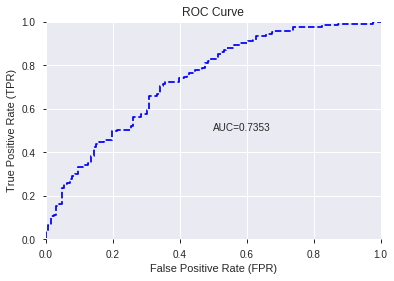

This function is available for GLM models only


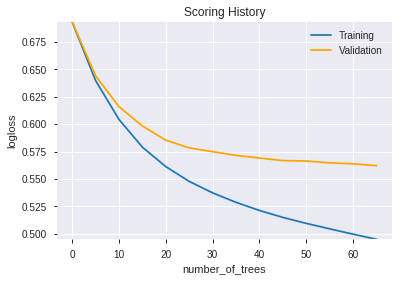

--2019-08-28 19:43:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_194308_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_194308_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8121',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CORREL_12',
 'WILLR_12',
 'STOCH_slowk',
 'MINUS_DI_12',
 'WILLR_14',
 'MFI_24',
 'STDDEV_8',
 'MINUS_DM_8',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'aroondown_8',
 'PLUS_DM_30',
 'PLUS_DI_20',
 'DX_14',
 'ATR_30',
 'MACDEXT_hist',
 'ROC_12',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_30_5_5',
 'DX_24',
 'PLUS_DM_24',
 'ROCP_20',
 'BBANDS_middleband_20_5_2',
 'MFI_30',
 'ROCR_30',
 'MOM_30',
 'ADX_14',
 'STOCHRSI_fastk',
 'NATR_14',
 'ROCP_8',
 'LINEARREG_SLOPE_8',
 'CCI_14',
 'MOM_8',
 'aroondown_20',
 'ADXR_12',
 'PLUS_DI_8',
 'aroonup_20',
 'AROONOSC_8',
 'MINUS_DI_24',
 'MINUS_DM_20',
 'BBANDS_upperband_20_5_3',
 'MAVP_20_1',
 'DX_30',
 'ATR_12',
 'ATR_8',
 'BETA_8',
 'PLUS_DI_14',
 'CCI_12',
 'LINEARREG_INTERCEPT_8',
 'PLUS_DI_30',
 'CDLLONGLINE',
 'DX_12',
 'BBANDS_upperband_20_1_2',
 'WILLR_24',
 'aroonup_24',
 'BBANDS_middleband_20_0_5',
 'MACDFIX_20',
 'aroondown_12',
 'CDLDOJI',
 'CMO_8',
 'APO',
 'MACDFIX_signal_24',
 'BBANDS_lowerband_24_7_5'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.707
GLM             0.703
XGBoost         0.699
dtype: float64

DeepLearning    GLM  XGBoost
All          0.707  0.691    0.699
DLF          0.687  0.691    0.695
Fwe          0.683  0.703    0.683
RFE          0.683  0.699    0.683
XGBF         0.695  0.691    0.695





F1


DeepLearning    0.744
GLM             0.751
XGBoost         0.748
dtype: float64

DeepLearning    GLM  XGBoost
All          0.744  0.739    0.734
DLF          0.738  0.733    0.729
Fwe          0.739  0.751    0.748
RFE          0.741  0.735    0.726
XGBF         0.735  0.733    0.729





auc


DeepLearning    0.743
GLM             0.746
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.731  0.744    0.740
DLF          0.740  0.732    0.743
Fwe          0.743  0.746    0.749
RFE          0.733  0.743    0.735
XGBF         0.739  0.732    0.743





logloss


DeepLearning    0.720
GLM             0.612
XGBoost         0.603
dtype: float64

DeepLearning    GLM  XGBoost
All          0.681  0.605    0.596
DLF          0.720  0.612    0.593
Fwe          0.636  0.591    0.591
RFE          0.604  0.597    0.603
XGBF         0.617  0.612    0.593





mean_per_class_error


DeepLearning    0.315
GLM             0.309
XGBoost         0.317
dtype: float64

DeepLearning    GLM  XGBoost
All          0.291  0.307    0.301
DLF          0.313  0.309    0.305
Fwe          0.315  0.296    0.314
RFE          0.314  0.299    0.317
XGBF         0.305  0.309    0.305





rmse


DeepLearning    0.467
GLM             0.458
XGBoost         0.457
dtype: float64

DeepLearning    GLM  XGBoost
All          0.467  0.454    0.453
DLF          0.464  0.458    0.452
Fwe          0.454  0.452    0.452
RFE          0.456  0.455    0.457
XGBF         0.457  0.458    0.452





mse


DeepLearning    0.218
GLM             0.209
XGBoost         0.209
dtype: float64

DeepLearning    GLM  XGBoost
All          0.218  0.206    0.206
DLF          0.216  0.209    0.205
Fwe          0.207  0.204    0.204
RFE          0.208  0.207    0.209
XGBF         0.209  0.209    0.205

{'F1':       DeepLearning    GLM  XGBoost
 All          0.744    NaN      NaN
 DLF          0.738    NaN      NaN
 DLF            NaN  0.733      NaN
 DLF            NaN    NaN    0.729
 All            NaN  0.739      NaN
 All            NaN    NaN    0.734
 XGBF         0.735    NaN      NaN
 XGBF           NaN  0.733      NaN
 XGBF           NaN    NaN    0.729
 Fwe          0.739    NaN      NaN
 Fwe            NaN  0.751      NaN
 Fwe            NaN    NaN    0.748
 RFE          0.741    NaN      NaN
 RFE            NaN  0.735      NaN
 RFE            NaN    NaN    0.726,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.707    NaN      NaN
 DLF          0.687    NaN      NaN
 DLF            NaN  0.691      NaN
 DLF            NaN    NaN    0.695
 All            NaN  0.691      NaN
 All            NaN    NaN    0.699
 XGBF         0.695    NaN      NaN
 XGBF           NaN  0.691      NaN
 XGBF           NaN    NaN    0.695
 Fwe          0.683    NaN      NaN
 Fwe     